# 1. Problem Definition

**Goal**: Predict delivery time (number of days between purchase and delivery date).

**Type**: Supervised regression problem (continuous target).

# 2. Set Up Python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

import sklearn
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

!pip install phik
import phik

!pip install optuna
import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_context('notebook')
sns.set_style('ticks')

# 3. Import Datasets

In [ ]:
customers=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_customers_dataset.csv')

In [ ]:
orders=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_orders_dataset.csv')

In [ ]:
geolocation=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_geolocation_dataset.csv')

In [ ]:
order_items=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_order_items_dataset.csv')

In [ ]:
order_payments=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_order_payments_dataset.csv')

In [ ]:
order_reviews=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_order_reviews_dataset.csv')

In [ ]:
products=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_products_dataset.csv')

In [ ]:
sellers=pd.read_csv('/content/drive/MyDrive/Olist Dataset/olist_sellers_dataset.csv')

In [ ]:
product_category_name_translation=pd.read_csv('/content/drive/MyDrive/Olist Dataset/product_category_name_translation.csv')

# 4. Merge All Datasets

In [ ]:
# Merge orders and order_items on 'order_id'
merged_data = pd.merge(orders, order_items, on='order_id')

In [ ]:
# Merge the result with products on 'product_id'
merged_data = pd.merge(merged_data, products, on='product_id')

In [ ]:
# Merge the result with 'product_category_name_translation' on 'product_category_name'
merged_data = pd.merge(merged_data, product_category_name_translation, on='product_category_name')

In [ ]:
# Merge the result with customers on 'customer_id'
merged_data = pd.merge(merged_data, customers, on='customer_id')

In [ ]:
# Merge the result with order_payments on 'order_id'
merged_data = pd.merge(merged_data, order_payments, on='order_id')

In [ ]:
# Merge the result with order_reviews on 'order_id'
merged_data = pd.merge(merged_data, order_reviews, on='order_id')

In [ ]:
# Merge the result with sellers on 'seller_id'
data = pd.merge(merged_data, sellers, on='seller_id')

**Load, Process and Merge the Geolocation Dataset**

In [ ]:
# Average lat/lng for each zip code prefix
geo_zip = geolocation.groupby('geolocation_zip_code_prefix').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

In [ ]:
# Merge customer coordinates
data = data.merge(
    geo_zip,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
).rename(columns={'geolocation_lat': 'customer_lat', 'geolocation_lng': 'customer_lng'}) \
 .drop(columns=['geolocation_zip_code_prefix'])

# Merge seller coordinates
data = data.merge(
    geo_zip,
    left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left',
    suffixes=('', '_seller')
).rename(columns={'geolocation_lat': 'seller_lat', 'geolocation_lng': 'seller_lng'}) \
 .drop(columns=['geolocation_zip_code_prefix'])

# 5. Data Pre-Processing

**1. Drop the Portugese 'product_category_name' column**

In [ ]:
# Drop the Portugese 'product_category_name' column
data = data.drop(columns=['product_category_name'])

**2. Remove unstructured data as structured data is the primary focus of analysis**

Unstructured data includes text, which in this dataset are '`review_comment_title`' and '`review_comment_message`'

In [ ]:
# Drop 'review_comment_title' and 'review_comment_message' columns from the dataset
data = data.drop(columns=['review_comment_title', 'review_comment_message'])

**3. Correct spelling mistake in labels.**

In [ ]:
# Correct spelling mistake in 'product_name_length'
data = data.rename(columns={'product_name_lenght': 'product_name_length',
                            'product_description_lenght': 'product_description_length'
                            })

**4. Create target variable: number_of_delivery_days.**

Firstly, we investigate whether there are any errors (e.g. an unrealistic maximum value, data entry mistake, etc.) in the 2 variables that we will use to construct our target variable: `order_purchase_timestamp` and `order_delivered_customer_date`.

In [ ]:
# Ensure the column is in datetime format
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'], errors='coerce')

# Extract year, month, day, and hour separately without adding them to the dataset
order_delivered_customer_date_year = data['order_delivered_customer_date'].dt.year
order_delivered_customer_date_month = data['order_delivered_customer_date'].dt.month
order_delivered_customer_date_day = data['order_delivered_customer_date'].dt.day
order_delivered_customer_date_hour = data['order_delivered_customer_date'].dt.hour

# Create a temporary DataFrame with the extracted components for investigation
temp_df = pd.DataFrame({
    'year': order_delivered_customer_date_year,
    'month': order_delivered_customer_date_month,
    'day': order_delivered_customer_date_day,
    'hour': order_delivered_customer_date_hour
})

# Investigate the extracted components by describing them
print(temp_df.describe())

                year          month            day           hour
count  113209.000000  113209.000000  113209.000000  113209.000000
mean     2017.566280       6.136509      16.025237      16.213048
std         0.501525       3.164445       8.669427       5.163858
min      2016.000000       1.000000       1.000000       0.000000
25%      2017.000000       4.000000       8.000000      14.000000
50%      2018.000000       6.000000      16.000000      17.000000
75%      2018.000000       8.000000      23.000000      20.000000
max      2018.000000      12.000000      31.000000      23.000000


In [ ]:
# Ensure the column is in datetime format
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'], errors='coerce')

# Extract year, month, day, and hour separately without adding them to the dataset
order_purchase_timestamp_year = data['order_purchase_timestamp'].dt.year
order_purchase_timestamp_month = data['order_purchase_timestamp'].dt.month
order_purchase_timestamp_day = data['order_purchase_timestamp'].dt.day
order_purchase_timestamp_hour = data['order_purchase_timestamp'].dt.hour

# Create a temporary DataFrame with the extracted components for investigation
temp_df_purchase = pd.DataFrame({
    'year': order_purchase_timestamp_year,
    'month': order_purchase_timestamp_month,
    'day': order_purchase_timestamp_day,
    'hour': order_purchase_timestamp_hour
})

# Investigate the extracted components by describing them
print(temp_df_purchase.describe())

                year          month            day           hour
count  115609.000000  115609.000000  115609.000000  115609.000000
mean     2017.539231       6.032022      15.558633      14.764430
std         0.505029       3.223457       8.663208       5.321909
min      2016.000000       1.000000       1.000000       0.000000
25%      2017.000000       3.000000       8.000000      11.000000
50%      2018.000000       6.000000      16.000000      15.000000
75%      2018.000000       8.000000      23.000000      19.000000
max      2018.000000      12.000000      31.000000      23.000000


From the step above, minimum and maximum of year is similar to the range of the dataset. Day, month, and hour values are also reasonable. Hence, the quality of these 2 variables is ensured to build our target variable.

In [ ]:
# Target variable
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])

data['number_of_delivery_days'] = (
   data['order_delivered_customer_date'] -
   data['order_purchase_timestamp']
).dt.days

**5. Convert timestamps to datetime.**

Note that `order_purchase_timestamp` and `order_delivered_customer_date` have already been converted above in the previous section.  

In [ ]:
# Convert order_approved_at to datatime
data['order_approved_at'] = pd.to_datetime(data['order_approved_at'])

In [ ]:
# Convert order_delivered_carrier_date to datatime
data['order_delivered_carrier_date'] = pd.to_datetime(data['order_delivered_carrier_date'])

In [ ]:
# Convert order_estimated_delivery_date to datatime
data['order_estimated_delivery_date'] = pd.to_datetime(data['order_estimated_delivery_date'])

In [ ]:
# Convert shipping_limit_date to datatime
data['shipping_limit_date'] = pd.to_datetime(data['shipping_limit_date'])

In [ ]:
# Convert review_creation_date to datatime
data['review_creation_date'] = pd.to_datetime(data['review_creation_date'])

In [ ]:
# Convert review_answer_timestamp to datatime
data['review_answer_timestamp'] = pd.to_datetime(data['review_answer_timestamp'])

# 6. Data Splitting

In [ ]:
# Split dataset into train, validation, and test
from sklearn.model_selection import train_test_split

# First split
index_train, index_test = train_test_split(np.array(data.index),
                                            train_size=0.7,
                                            random_state=5)

train = data.loc[index_train,:].copy()
test = data.loc[index_test,:].copy()

# Second split
index_train, index_valid = train_test_split(np.array(data.index),
                                            train_size=0.7,
                                            random_state=5)

train = data.loc[index_train,:].copy()
valid = data.loc[index_valid,:].copy()

print("Train features:", train.shape)
print("Validation features:", valid.shape)
print("Test features:", test.shape)

Train features: (80926, 42)
Validation features: (34683, 42)
Test features: (34683, 42)


# 7. Data Cleaning

## 7.1. Missing values

In [ ]:
# Summary of DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80926 entries, 44357 to 35683
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       80926 non-null  object        
 1   customer_id                    80926 non-null  object        
 2   order_status                   80926 non-null  object        
 3   order_purchase_timestamp       80926 non-null  datetime64[ns]
 4   order_approved_at              80917 non-null  datetime64[ns]
 5   order_delivered_carrier_date   80106 non-null  datetime64[ns]
 6   order_delivered_customer_date  79278 non-null  datetime64[ns]
 7   order_estimated_delivery_date  80926 non-null  datetime64[ns]
 8   order_item_id                  80926 non-null  int64         
 9   product_id                     80926 non-null  object        
 10  seller_id                      80926 non-null  object        
 11  shipping_limit_d

We can see that some columns have missing values. Let's check which variables have missing values.

In [ ]:
# Checking for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

order_delivered_customer_date    1648
number_of_delivery_days          1648
order_delivered_carrier_date      820
customer_lat                      209
customer_lng                      209
seller_lat                        193
seller_lng                        193
order_approved_at                   9
product_weight_g                    1
product_width_cm                    1
product_length_cm                   1
product_height_cm                   1
dtype: int64


**1. Missing values in number_of_delivery_days**

The reason for the 1648 missing values in the target variable is due to the `order_status`, where not all orders were delivered to the customer.

In [ ]:
train['order_status'].value_counts()

,count
order_status,
delivered,79276
shipped,781
canceled,378
invoiced,245
processing,240
unavailable,3
approved,3


79,276 orders were delivered successfully but the remaining 1648 orders had a status of either shipped, cancelled, invoiced, processing, unavailable or approved. This means it will not have a `order_delivered_customer_date`, hence no values for `number_of_delivery_days`.

Since these incomplete records do not contribute meaningful information to our prediction of `number_of_delivery_days`, we chose to remove them from the dataset.

In [ ]:
# Delete observations with missing values for number_of_delivery_days
train.dropna(subset=['number_of_delivery_days'], inplace=True)
valid.dropna(subset=['number_of_delivery_days'], inplace=True)
test.dropna(subset=['number_of_delivery_days'], inplace=True)

We will also delete the `order_status` column as this variable will not provide any predictive power: we are only interested in orders that have been delivered.

In [ ]:
# Drop order_status
train = train.drop(columns=['order_status'])

In [ ]:
# Check for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

customer_lat                    198
customer_lng                    198
seller_lng                      191
seller_lat                      191
order_approved_at                 9
order_delivered_carrier_date      1
product_width_cm                  1
product_height_cm                 1
product_length_cm                 1
product_weight_g                  1
dtype: int64


**2. Missing values for order_approved_at**

Upon further inspection, the orders with missing values for `order_approved_at` had an `order_status` of "delivered".

In [ ]:
# List of orders with missing values for order_approved_at
train[train['order_approved_at'].isnull()][['order_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date']]

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date
56265,7002a78c79c519ac54022d4f8a65e6e8,2017-01-19 22:26:59,NaT,2017-02-06 14:22:19
31225,c1d4211b3dae76144deccd6c74144a88,2017-01-19 12:48:08,NaT,2017-01-30 18:16:01
78600,88083e8f64d95b932164187484d90212,2017-02-18 22:49:19,NaT,2017-03-02 12:06:06
26350,5cf925b116421afa85ee25e99b4c34fb,2017-02-18 16:48:35,NaT,2017-03-09 07:28:47
19225,8a9adc69528e1001fc68dd0aaebbb54a,2017-02-18 12:45:31,NaT,2017-03-02 10:05:06
73133,51eb2eebd5d76a24625b31c33dd41449,2017-02-18 15:52:27,NaT,2017-03-07 13:57:47
45794,d77031d6a3c8a52f019764e68f211c69,2017-02-18 11:04:19,NaT,2017-03-02 16:15:23
6123,e04abd8149ef81b95221e88f6ed9ab6a,2017-02-18 14:40:00,NaT,2017-03-01 13:25:33
84082,3c0b8706b065f9919d0505d3b3343881,2017-02-17 15:53:27,NaT,2017-03-03 11:47:47


We can see that the missing values for `order_approved_at` had a `order_purchase_timestamp` on particular days.



In [ ]:
# Number of orders purchased on 19/01/2017
train[train['order_purchase_timestamp'].dt.date == pd.to_datetime('2017-01-19').date()]['order_id'].nunique()

18

In [ ]:
# Number of orders purchased on 17/02/2017
train[train['order_purchase_timestamp'].dt.date == pd.to_datetime('2017-02-17').date()]['order_id'].nunique()

31

In [ ]:
# Number of orders purchased on 18/02/2017
train[train['order_purchase_timestamp'].dt.date == pd.to_datetime('2017-02-18').date()]['order_id'].nunique()

35

Given that a number of orders still had an approval time on the same days as those orders with missing values, we can conclude that the missing values may be missing completely at random. Possible reasons could include data entry error or a system glitch.

There is also no apparent pattern for why there are missing values.

We will now see if there is a difference in the `number_of_delivery_days` when rows with missing values are removed and not removed.

In [ ]:
# Null hypothesis = No difference in the mean distribution between datasets including and excluding missing values
excluded_dates = [pd.to_datetime('2017-01-19').date(),
                  pd.to_datetime('2017-02-17').date(),
                  pd.to_datetime('2017-02-18').date()]

excluded_train = train[~train['order_purchase_timestamp'].dt.date.isin(excluded_dates)]

stats.ttest_ind(train['number_of_delivery_days'], excluded_train['number_of_delivery_days'], equal_var = False)

TtestResult(statistic=np.float64(0.04938840800651145), pvalue=np.float64(0.9606098282112536), df=np.float64(158447.8002980112))

Let the significance level be $\alpha$ = 5%. Given the p-value of 0.96, we do not reject the null hypothesis and state that the difference in mean distribution between the datasets with and without the missing values was not statistically significant. (The conclusion is also the same when we exclude data based on `order_delivered_carrier_date`).

Also, these rows with missing values account for less than 1% of the entire train dataset, indicating the rareness of this missingness.

Therefore, we will remove the rows with missing values in `order_approved_at `.

In [ ]:
# Delete observations with missing values for order_approved_at
train.dropna(subset=['order_approved_at'], inplace=True)
valid.dropna(subset=['order_approved_at'], inplace=True)
test.dropna(subset=['order_approved_at'], inplace=True)

In [ ]:
# Check for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

customer_lng                    198
customer_lat                    198
seller_lng                      191
seller_lat                      191
order_delivered_carrier_date      1
product_width_cm                  1
product_height_cm                 1
product_length_cm                 1
product_weight_g                  1
dtype: int64


**3. Missing values for product width, height, length, and weight**

In [ ]:
# Identify which product_id has the missing value for product_width_cm
print(train[train['product_width_cm'].isnull()]['product_id'].unique())

['09ff539a621711667c43eba6a3bd8466']


In [ ]:
# Identify which product_id has the missing value for product_height_cm
print(train[train['product_height_cm'].isnull()]['product_id'].unique())

['09ff539a621711667c43eba6a3bd8466']


In [ ]:
# Identify which product_id has the missing value for product_length_cm
print(train[train['product_length_cm'].isnull()]['product_id'].unique())

['09ff539a621711667c43eba6a3bd8466']


In [ ]:
# Identify which product_id has the missing value for product_weight_g
print(train[train['product_weight_g'].isnull()]['product_id'].unique())

['09ff539a621711667c43eba6a3bd8466']


The codes above confirm that the missing values for product width, height, length, and weight are for the same product ID.

A look at the datasets through Excel confirms that the product ID with missing values only appears once in the `order_items` dataset (only one customer ordered this product, and this customer only bought this one item). This means that the missing values are insignificant (missing at random), and therefore, this row can be removed.

In [ ]:
# Delete observation with missing values for product_width_cm / product_height_cm / product_length_cm / product_weight_g
train.dropna(subset=['product_width_cm'], inplace=True)

In [ ]:
# Check for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

customer_lat                    198
customer_lng                    198
seller_lat                      191
seller_lng                      191
order_delivered_carrier_date      1
dtype: int64


**4. Missing values for customer and seller lng and lat**

A potential reason for missing values is the customer not consenting to provide details of their location.

Given that `customer_city` and `seller_city` do not have any missing values, we can handle the missing values for `customer_lat`, `customer_lng`, `seller_lat` and `seller_lng` by using the median latitude and longitude for their corresponding city (imputation).

In [ ]:
# customer_lat and customer_lng

# Calculate the median lat/lng for each customer_city
customer_city_coords = train.groupby('customer_city')[['customer_lat', 'customer_lng']].median()

# Impute missing values based on the calculated median
def impute_customer_lat_lng(row):
    if pd.isnull(row['customer_lat']) or pd.isnull(row['customer_lng']):
        city_code = row['customer_city']
        if city_code in customer_city_coords.index:
            row['customer_lat'] = customer_city_coords.loc[city_code, 'customer_lat']
            row['customer_lng'] = customer_city_coords.loc[city_code, 'customer_lng']
    return row

train = train.apply(impute_customer_lat_lng, axis=1)
valid = valid.apply(impute_customer_lat_lng, axis=1)
test = test.apply(impute_customer_lat_lng, axis=1)

In [ ]:
# seller_lat and seller_lng

# Calculate the median lat/lng for each seller_city
seller_city_coords = train.groupby('seller_city')[['seller_lat', 'seller_lng']].median()

# Impute missing values based on the calculated median
def impute_seller_lat_lng(row):
    if pd.isnull(row['seller_lat']) or pd.isnull(row['seller_lng']):
        city_code = row['seller_city']
        if city_code in seller_city_coords.index:
            row['seller_lat'] = seller_city_coords.loc[city_code, 'seller_lat']
            row['seller_lng'] = seller_city_coords.loc[city_code, 'seller_lng']
    return row

train = train.apply(impute_seller_lat_lng, axis=1)
valid = valid.apply(impute_seller_lat_lng, axis=1)
test = test.apply(impute_seller_lat_lng, axis=1)

In [ ]:
# Check for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

customer_lat                    34
customer_lng                    34
order_delivered_carrier_date     1
dtype: int64


In [ ]:
# List of corresponding cities for missing values in customer_lat and customer_lng
missing_customer_cities = train[train['customer_lat'].isnull()]['customer_city'].unique()
print(missing_customer_cities)

['alto sao joao' 'maioba' 'sao miguel do cambui' 'passagem' 'glaura'
 'sambaiba' 'perola independente' 'conceicao do formoso' 'jaua'
 'cipo-guacu' 'luziapolis' 'polo petroquimico de triunfo' 'poco de pedra'
 'angelo frechiani' 'estevao de araujo' 'domiciano ribeiro' 'monnerat'
 'doce grande' 'bom jesus do querendo' 'sao sebastiao do paraiba'
 'corrego do ouro' 'jacuipe' 'palmeirinha' 'santo eduardo'
 'nossa senhora do remedio' 'pinhotiba' 'bora' 'sao sebastiao da serra'
 'guinda' 'siriji' 'pitanga de estrada']


For the remaining 34 missing values in `customer_lng` and `customer_lat`, the corresponding `customer_city` did not exist in the geolocation dataset. Therefore the coordinates also do not exist and we cannot impute a median coordinate.

Consequently, to ensure consistency and accuracy of the imputation, we will delete these observations with missing values in `customer_lng` and `customer_lat`.

In [ ]:
# Delete observations with missing values for customer_lat
train.dropna(subset=['customer_lat'], inplace=True)
valid.dropna(subset=['customer_lat'], inplace=True)
test.dropna(subset=['customer_lat'], inplace=True)

In [ ]:
# Delete observations with missing values for customer_lng
train.dropna(subset=['customer_lng'], inplace=True)
valid.dropna(subset=['customer_lng'], inplace=True)
test.dropna(subset=['customer_lng'], inplace=True)

In [ ]:
# Check for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

order_delivered_carrier_date    1
dtype: int64


**5. Missing values for order_delivered_carrier_date**

Upon further inspection, the order with missing value for `order_delivered_carrier_date` had an `order_status` of "delivered". So we assume that the missing value is due to a data entry error or system glitch.

In [ ]:
# List of orders with missing values for order_delivered_carrier_date
train[train['order_delivered_carrier_date'].isnull()][['order_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date']]

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date
85000,2aa91108853cecb43c84a5dc5b277475,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT


Since this missing value is very rare, we will delete this row.

In [ ]:
# Delete observations with missing values for order_delivered_carrier_date
train.dropna(subset=['order_delivered_carrier_date'], inplace=True)
valid.dropna(subset=['order_delivered_carrier_date'], inplace=True)
test.dropna(subset=['order_delivered_carrier_date'], inplace=True)

In [ ]:
# Check for missing values
missing_counts = train.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

Series([], dtype: int64)


There are no more missing values in the dataset.

## 7.2. Data leakage

**1. Drop columns that will cause data leakage.**

i.e. information that would not be available at the time of prediction.

In [ ]:
# order_delivered_customer_date
train = train.drop(columns=['order_delivered_customer_date'])

In [ ]:
# review_id, review_score, review_creation_date, review_answer_timestamp
train = train.drop(columns=['review_id', 'review_score', 'review_creation_date', 'review_answer_timestamp'])

# 8. Exploratory Data Analysis (EDA)

## 8.1. Overview of training dataset

In [ ]:
# Summary of DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79233 entries, 44357 to 35683
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       79233 non-null  object        
 1   customer_id                    79233 non-null  object        
 2   order_purchase_timestamp       79233 non-null  datetime64[ns]
 3   order_approved_at              79233 non-null  datetime64[ns]
 4   order_delivered_carrier_date   79233 non-null  datetime64[ns]
 5   order_estimated_delivery_date  79233 non-null  datetime64[ns]
 6   order_item_id                  79233 non-null  int64         
 7   product_id                     79233 non-null  object        
 8   seller_id                      79233 non-null  object        
 9   shipping_limit_date            79233 non-null  datetime64[ns]
 10  price                          79233 non-null  float64       
 11  freight_value   

In [ ]:
# Summary statistics of training data
train.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,product_name_length,product_description_length,...,customer_zip_code_prefix,payment_sequential,payment_installments,payment_value,seller_zip_code_prefix,customer_lat,customer_lng,seller_lat,seller_lng,number_of_delivery_days
count,79233,79233,79233,79233,79233.000000,79233,79233.000000,79233.000000,79233.000000,79233.000000,...,79233.000000,79233.000000,79233.000000,79233.000000,79233.000000,79233.000000,79233.000000,79233.000000,79233.000000,79233.000000
mean,2017-12-31 19:40:52.544255232,2018-01-01 06:07:42.354914816,2018-01-04 02:12:58.915729408,2018-01-24 16:01:10.879557888,1.193896,2018-01-07 10:31:39.562088960,119.688904,20.032421,48.795249,787.236366,...,35083.999735,1.090934,2.948809,171.774072,24503.376876,-21.231449,-46.216787,-22.794974,-47.244814,11.988363
min,2016-10-03 09:44:50,2016-10-04 10:19:23,2016-10-08 10:34:01,2016-10-27 00:00:00,1.000000,2016-10-08 10:34:01,0.850000,0.000000,5.000000,4.000000,...,1003.000000,1.000000,0.000000,0.000000,1001.000000,-33.689948,-72.668881,-32.079231,-63.893565,0.000000
25%,2017-09-12 22:20:18,2017-09-13 14:10:25,2017-09-15 17:18:59,2017-10-04 00:00:00,1.000000,2017-09-20 02:50:31,39.900000,13.080000,42.000000,346.000000,...,11340.000000,1.000000,1.000000,60.950000,6429.000000,-23.590310,-48.107784,-23.609430,-48.829744,6.000000
50%,2018-01-19 17:30:52,2018-01-20 09:10:26,2018-01-23 22:43:16,2018-02-15 00:00:00,1.000000,2018-01-26 13:55:25,74.900000,16.320000,52.000000,602.000000,...,24241.000000,1.000000,2.000000,108.100000,13690.000000,-22.926259,-46.634203,-23.425556,-46.751381,10.000000
75%,2018-05-04 17:50:19,2018-05-05 02:55:11,2018-05-08 12:25:00,2018-05-28 00:00:00,1.000000,2018-05-10 14:53:37,132.080000,21.210000,57.000000,988.000000,...,58802.000000,1.000000,4.000000,188.820000,27930.000000,-20.140360,-43.664953,-21.757321,-46.522287,15.000000
max,2018-08-29 14:52:00,2018-08-29 15:05:22,2018-09-03 12:56:00,2018-10-25 00:00:00,21.000000,2020-04-09 22:35:08,6499.000000,409.680000,76.000000,3992.000000,...,99980.000000,26.000000,24.000000,13664.080000,99730.000000,42.184003,-8.723762,-2.501242,-34.855616,208.000000
std,NaN,NaN,NaN,NaN,0.679102,NaN,180.290611,15.860445,10.020027,653.064668,...,29855.686981,0.696531,2.783094,267.916093,27635.827637,5.553610,4.040531,2.700712,2.337244,9.349410


Following data cleaning, the number of observations was reduced from 80,926 to 79,233, representing a loss of approximately 2.1% of the dataset. Given the small proportion of removed data, this reduction is unlikely to introduce significant bias or adversely affect the model's generalization performance.

## 8.2. Target variable

In [ ]:
target = ['number_of_delivery_days']

In [ ]:
train[target].describe()

,number_of_delivery_days
count,79233.000000
mean,11.988363
std,9.349410
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,208.000000


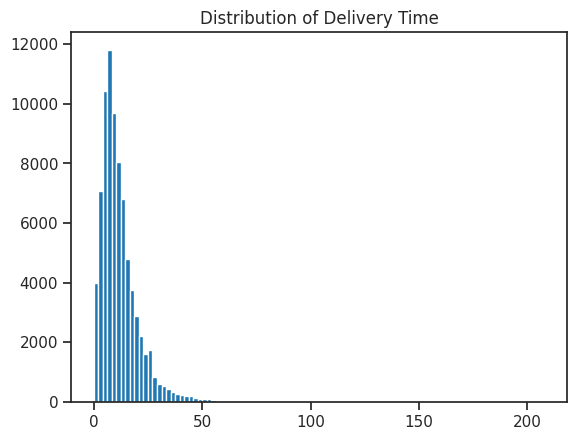

In [ ]:
# Distribution of target variable
plt.hist(train[target], bins=100)
plt.title("Distribution of Delivery Time")
plt.show()

Distribution of the number of delivery days is right-skewed, suggesting potential outliers.

## 8.3. Continuous predictors

In [ ]:
continuous = ['price',
              'freight_value',
              'payment_value',
              'product_weight_g',
              'product_length_cm',
              'product_height_cm',
              'product_width_cm']

**1. Descriptive statistics of continuous predictors**

In [ ]:
continuous_data = train[continuous]
continuous_data.describe().round(1)

,price,freight_value,payment_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,79233.0,79233.0,79233.0,79233.0,79233.0,79233.0,79233.0
mean,119.7,20.0,171.8,2110.5,30.3,16.6,23.1
std,180.3,15.9,267.9,3769.1,16.1,13.5,11.7
min,0.8,0.0,0.0,0.0,7.0,2.0,6.0
25%,39.9,13.1,61.0,300.0,18.0,8.0,15.0
50%,74.9,16.3,108.1,700.0,25.0,13.0,20.0
75%,132.1,21.2,188.8,1800.0,38.0,20.0,30.0
max,6499.0,409.7,13664.1,40425.0,105.0,105.0,118.0


**2. Distribution of continuous predictors.**

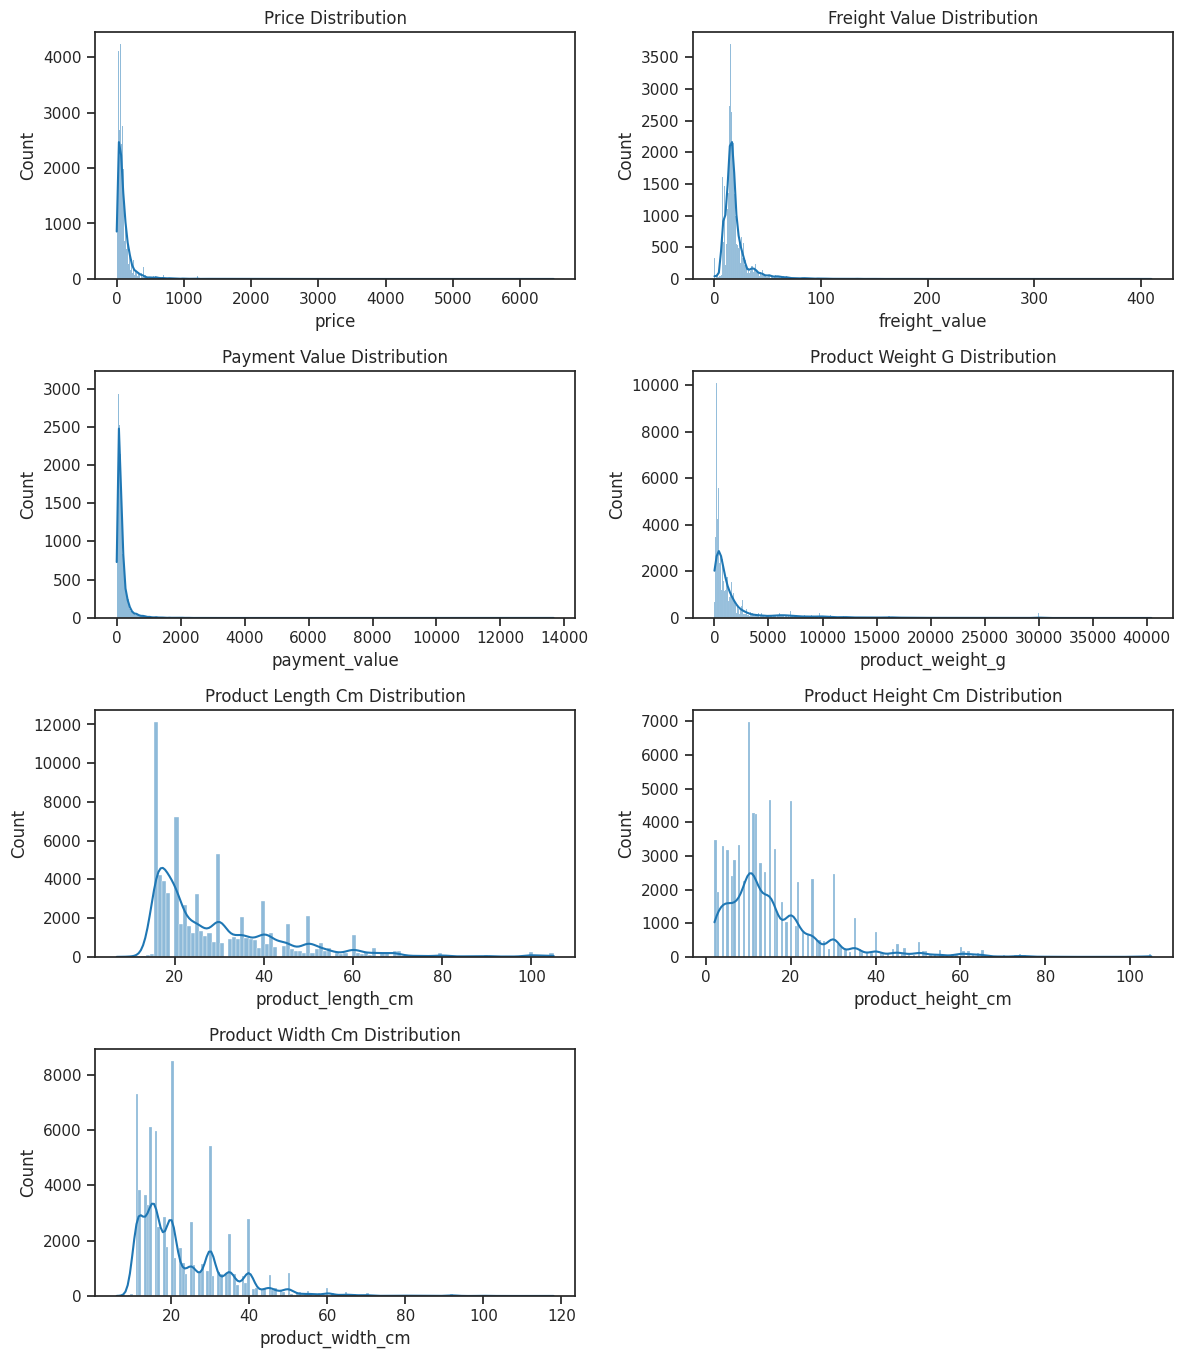

In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(12,20))
axes = axes.flatten()

# Plot the distribution of continuous predictors
for i, col in enumerate(continuous):
    sns.histplot(train[col], kde=True, ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()
plt.show()

**3. Distribution of the relationship between target and continuous predictors.**

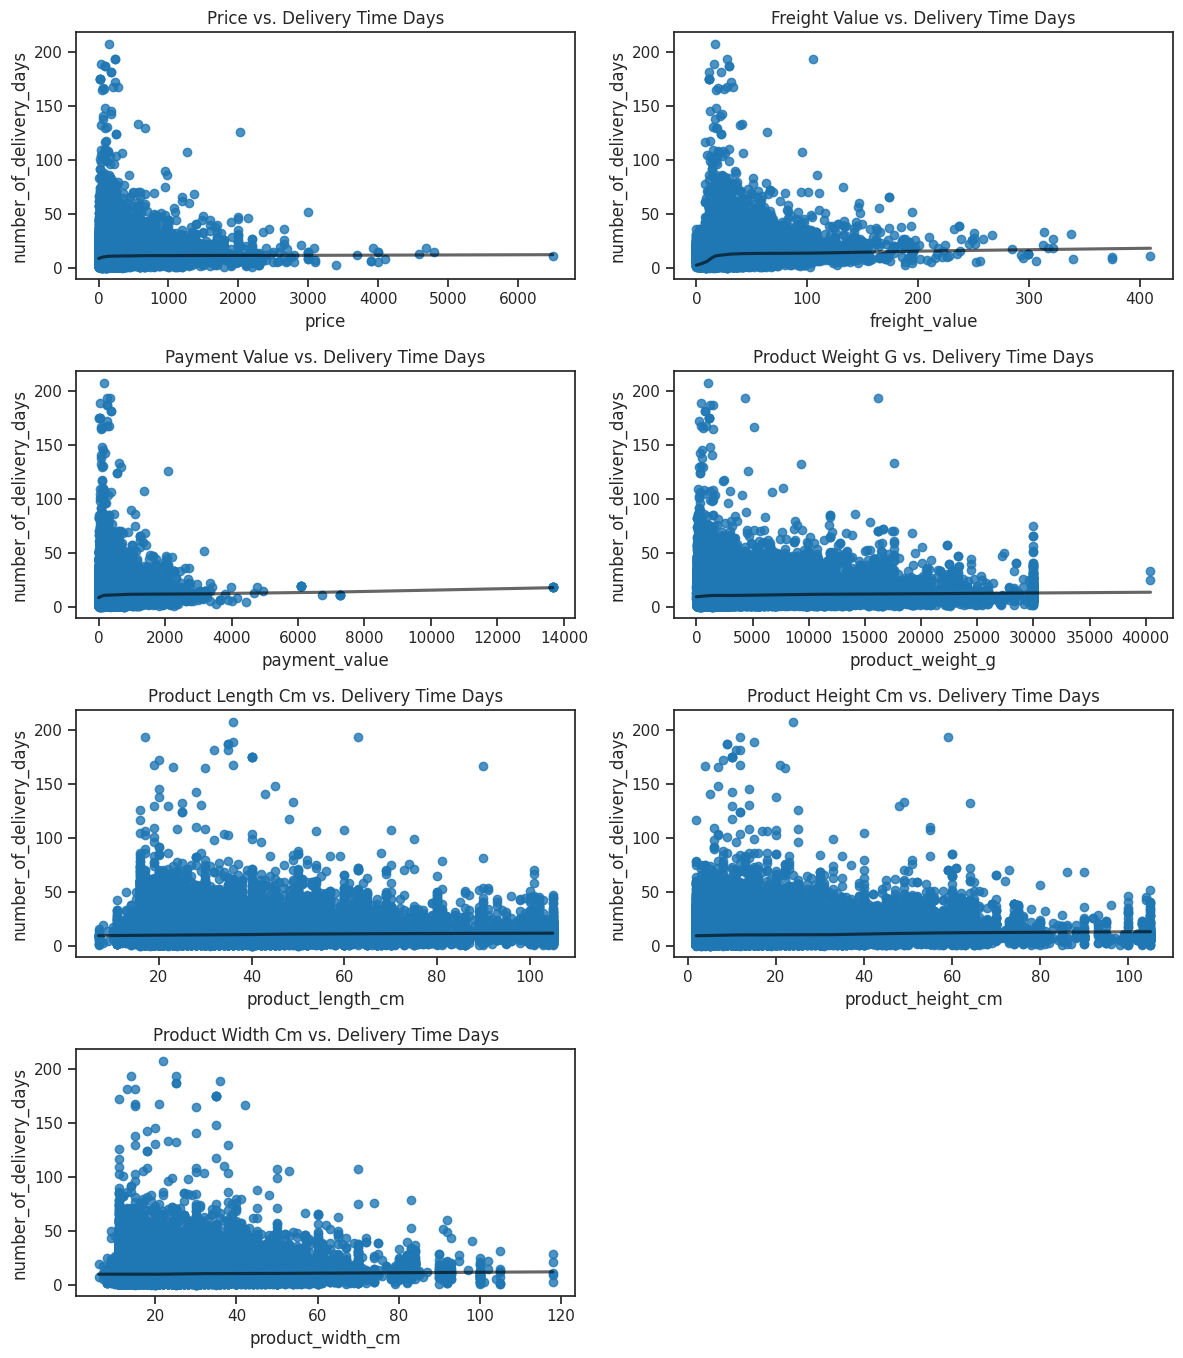

In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(12, 20))
axes = axes.flatten()

# Plot the distribution of continuous predictors vs target variable
for i, col in enumerate(continuous):
    sns.regplot(x=col, y='number_of_delivery_days', data=train, ax=axes[i], lowess=True, line_kws={'color':'black', 'alpha':0.6})
    axes[i].set_title(f'{col.replace("_", " ").title()} vs. Delivery Time Days')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout()
plt.show()

**4. Relationship between target and continuous predictors.**

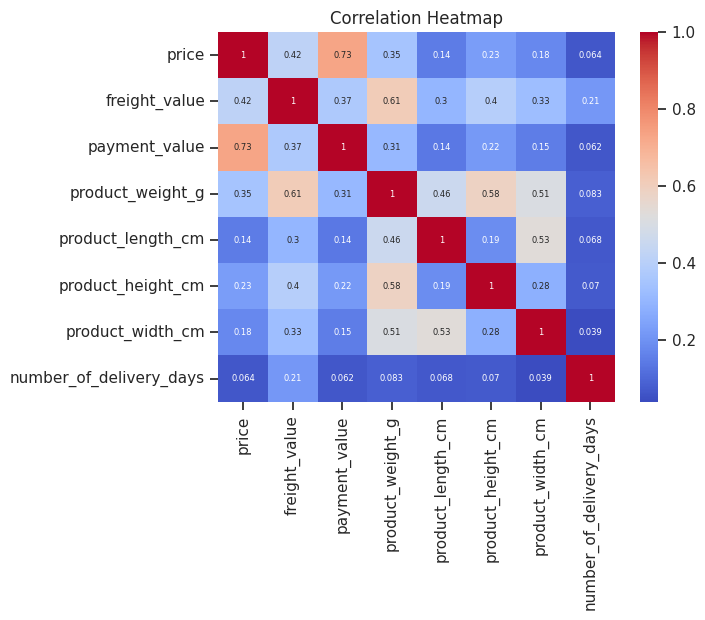

In [ ]:
# Heatmap - Correlation between continuous variables and number_of_delivery_days
correlation_matrix = train[continuous + ['number_of_delivery_days']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 6})
plt.title('Correlation Heatmap')
plt.show()

*  Understanding both linear and non-linear relationships between variables
*  Here we will examine and compare Pearson correlation (measures linear relationships) and $\phi_k$ correlation (captures both linear and non-linear relationships).


In [ ]:
continuous_train_data = train[continuous + ['number_of_delivery_days']]

# Calculate Pearson correlation
pearson_corr = continuous_train_data.corr(method='pearson')
pearson_with_target = pearson_corr[target].drop(target)

# Calculate Phi-K correlation
phi_k_matrix = continuous_train_data.phik_matrix(continuous_train_data.columns)
phi_k_with_target = phi_k_matrix[target].drop(target)

# Create a comparison DataFrame
correlation_comparison = pd.DataFrame({
    'Pearson': pearson_with_target['number_of_delivery_days'],
    r'Phi-K': phi_k_with_target['number_of_delivery_days'],
}).round(3)

correlation_comparison

,Pearson,Phi-K
price,0.064,0.028
freight_value,0.214,0.112
payment_value,0.062,0.000
product_weight_g,0.083,0.054
product_length_cm,0.068,0.065
product_height_cm,0.070,0.080
product_width_cm,0.039,0.030


### **Key Takeaways from EDA of continuous predictors**
* Potential outliers in `payment_value`
* Some numerical features are skewed and might need transformation.
* The graphs show potential non-linear relationship between the target and some continuous predictors
* The heatmap shows potential interaction effects between product length, height and width.
* `freight_value` has the highest **linear** correlation with the target (corr = 0.214)


## 8.4. Categorical predictors

**1. customer_city**

In [ ]:
# Counts for 'customer_city'
no_customer_city_categories = train['customer_city'].nunique()
print("Number of unique customer_city categories:", no_customer_city_categories)
train['customer_city'].value_counts(normalize=False)

Number of unique customer_city categories: 3656


,count
customer_city,
sao paulo,12461
rio de janeiro,5488
belo horizonte,2244
brasilia,1704
campinas,1210
...,...
lavrinhas,1
cotipora,1
ipiranga do sul,1


In [ ]:
# Counts of customer_city that appear only once
single_occurrence_cities = (train['customer_city'].value_counts() == 1).sum()
print(f"Number of cities appearing only once: {single_occurrence_cities}")

Number of cities appearing only once: 1026


In [ ]:
# customer_city VS average number_of_delivery_days
train.groupby('customer_city')['number_of_delivery_days'].mean().sort_values(ascending=False)

,number_of_delivery_days
customer_city,
novo brasil,148.0
capinzal do norte,109.0
santa cruz de goias,86.0
marcelino vieira,78.0
santaluz,75.0
...,...
pedra bela,3.5
contenda,3.0
acucena,3.0


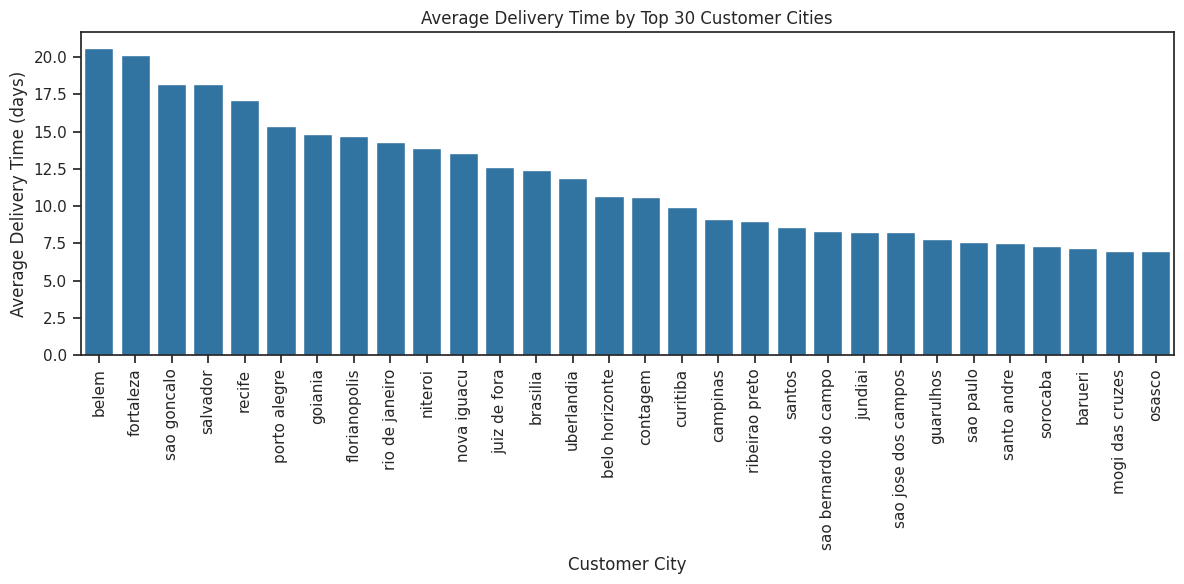

In [ ]:
# Average number_of_delivery_days for the top 30 customer cities by count
top_customer_city = train['customer_city'].value_counts().head(30).index
average_delivery_time_by_customer_city = train[train['customer_city'].isin(top_customer_city)].groupby('customer_city')['number_of_delivery_days'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_customer_city.index, y=average_delivery_time_by_customer_city.values)
plt.xticks(rotation=90)
plt.title('Average Delivery Time by Top 30 Customer Cities')
plt.xlabel('Customer City')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

In [ ]:
# Phi-K correlation between customer_city and target
columns_for_phik = train[['customer_city', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['customer_city', 'number_of_delivery_days']
print(f"Phi-K Correlation Customer City vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['number_of_delivery_days']
Phi-K Correlation Customer City vs Delivery Time: 0.67


**2. customer_state**

In [ ]:
# Counts for 'customer_state'
no_customer_state_categories = train['customer_state'].nunique()
print("Number of unique customer_state categories:", no_customer_state_categories)
train['customer_state'].value_counts(normalize=False)

Number of unique customer_state categories: 27


,count
customer_state,
SP,33425
RJ,10256
MG,9339
RS,4404
PR,4060
SC,2870
BA,2671
DF,1710
GO,1612


In [ ]:
# customer_state VS average number_of_delivery_days
train.groupby('customer_state')['number_of_delivery_days'].mean().sort_values(ascending=False)

,number_of_delivery_days
customer_state,
RR,30.575758
AP,28.641791
AM,24.582609
AL,24.308475
PA,22.965007
MA,21.319343
AC,21.084507
PB,20.453333
CE,20.354308


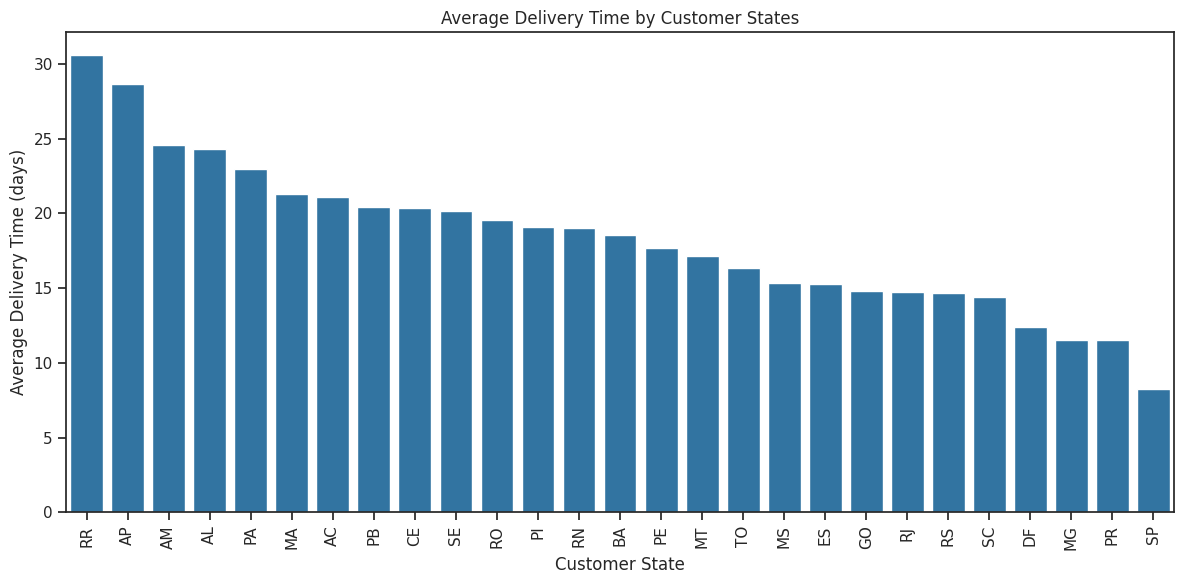

In [ ]:
# Average number_of_delivery_days for the customer states by count
average_delivery_time_by_customer_state = train.groupby('customer_state')['number_of_delivery_days'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_customer_state.index, y=average_delivery_time_by_customer_state.values)
plt.xticks(rotation=90)
plt.title('Average Delivery Time by Customer States')
plt.xlabel('Customer State')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

In [ ]:
# Phi-K correlation between customer_state and target
columns_for_phik = train[['customer_state', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['customer_state', 'number_of_delivery_days']
print(f"Phi-K Correlation Customer State vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['number_of_delivery_days']
Phi-K Correlation Customer State vs Delivery Time: 0.307


**3. seller_city**

In [ ]:
# Counts for 'seller_city'
no_seller_city_categories = train['seller_city'].nunique()
print("Number of unique seller_city categories:", no_seller_city_categories)
train['seller_city'].value_counts(normalize=False)

Number of unique seller_city categories: 559


,count
seller_city,
sao paulo,19760
ibitinga,5678
santo andre,2144
curitiba,2127
sao jose do rio preto,1844
...,...
abadia de goias,1
vitoria de santo antao,1
pinhalzinho,1


In [ ]:
# Counts of seller_city that appear only once
single_occurrence_cities = (train['seller_city'].value_counts() == 1).sum()
print(f"Number of cities appearing only once: {single_occurrence_cities}")

Number of cities appearing only once: 63


In [ ]:
# seller_city VS average number_of_delivery_days
train.groupby('seller_city')['number_of_delivery_days'].mean().sort_values(ascending=False)

,number_of_delivery_days
seller_city,
feira de santana,92.500000
manaus,47.333333
portoferreira,47.000000
monte alto,30.666667
curitibanos,29.722222
...,...
ipe,3.000000
sao sebastiao da grama/sp,3.000000
ferraz de vasconcelos,2.000000


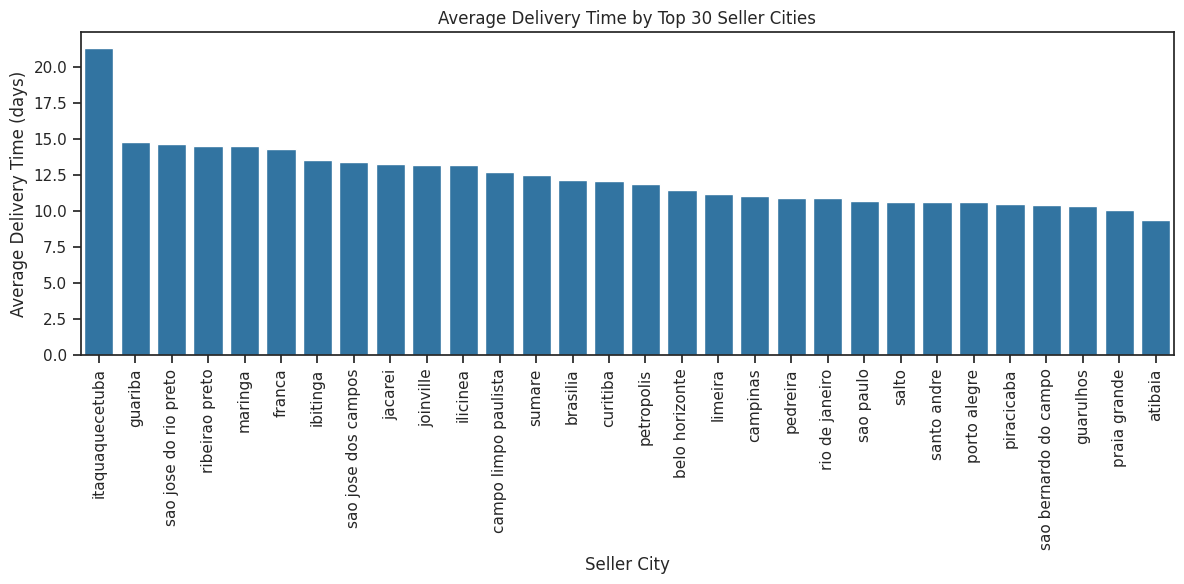

In [ ]:
# Average number_of_delivery_days for the top 30 seller cities by count
top_seller_city = train['seller_city'].value_counts().head(30).index
average_delivery_time_by_seller_city = train[train['seller_city'].isin(top_seller_city)].groupby('seller_city')['number_of_delivery_days'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_seller_city.index, y=average_delivery_time_by_seller_city.values)
plt.xticks(rotation=90)
plt.title('Average Delivery Time by Top 30 Seller Cities')
plt.xlabel('Seller City')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

In [ ]:
# Phi-K correlation between seller_city and target
columns_for_phik = train[['seller_city', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['seller_city', 'number_of_delivery_days']
print(f"Phi-K Correlation Seller City vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['number_of_delivery_days']
Phi-K Correlation Seller City vs Delivery Time: 0.326


**4. seller_state**

In [ ]:
# Counts for 'seller_state'
no_seller_state_categories = train['seller_state'].nunique()
print("Number of unique seller_state categories:", no_seller_state_categories)
train['seller_state'].value_counts(normalize=False)

Number of unique seller_state categories: 22


,count
seller_state,
SP,56520
MG,6120
PR,6113
RJ,3393
SC,2921
RS,1527
DF,646
BA,475
GO,361


In [ ]:
# seller_state VS average number_of_delivery_days
train.groupby('seller_state')['number_of_delivery_days'].mean().sort_values(ascending=False)

,number_of_delivery_days
seller_state,
AM,47.333333
RO,17.400000
MA,16.659649
CE,16.454545
PI,14.333333
RN,13.815789
MT,13.670213
BA,13.402105
PA,13.125000


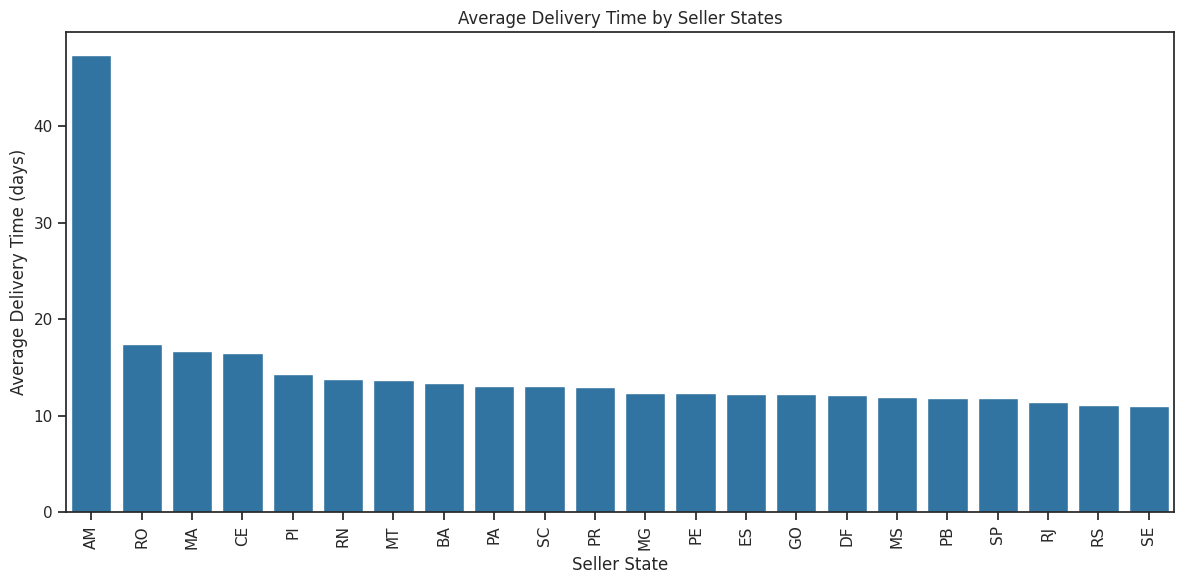

In [ ]:
# Average number_of_delivery_days for the seller states by count
average_delivery_time_by_seller_state = train.groupby('seller_state')['number_of_delivery_days'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_seller_state.index, y=average_delivery_time_by_seller_state.values)
plt.xticks(rotation=90)
plt.title('Average Delivery Time by Seller States')
plt.xlabel('Seller State')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

In [ ]:
# Phi-K correlation between seller_state and target
columns_for_phik = train[['seller_state', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['seller_state', 'number_of_delivery_days']
print(f"Phi-K Correlation Seller State vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['number_of_delivery_days']
Phi-K Correlation Seller State vs Delivery Time: 0.104


**5. product_category_name_english**

In [ ]:
# Counts for 'product_category_name_english'
no_product_category_name_english_categories = train['product_category_name_english'].nunique()
print("Number of unique product_category_name_english categories:", no_product_category_name_english_categories)
train['product_category_name_english'].value_counts(normalize=False)

Number of unique product_category_name_english categories: 71


,count
product_category_name_english,
bed_bath_table,8209
health_beauty,6749
sports_leisure,6159
furniture_decor,6006
computers_accessories,5546
...,...
home_comfort_2,16
la_cuisine,12
cds_dvds_musicals,8


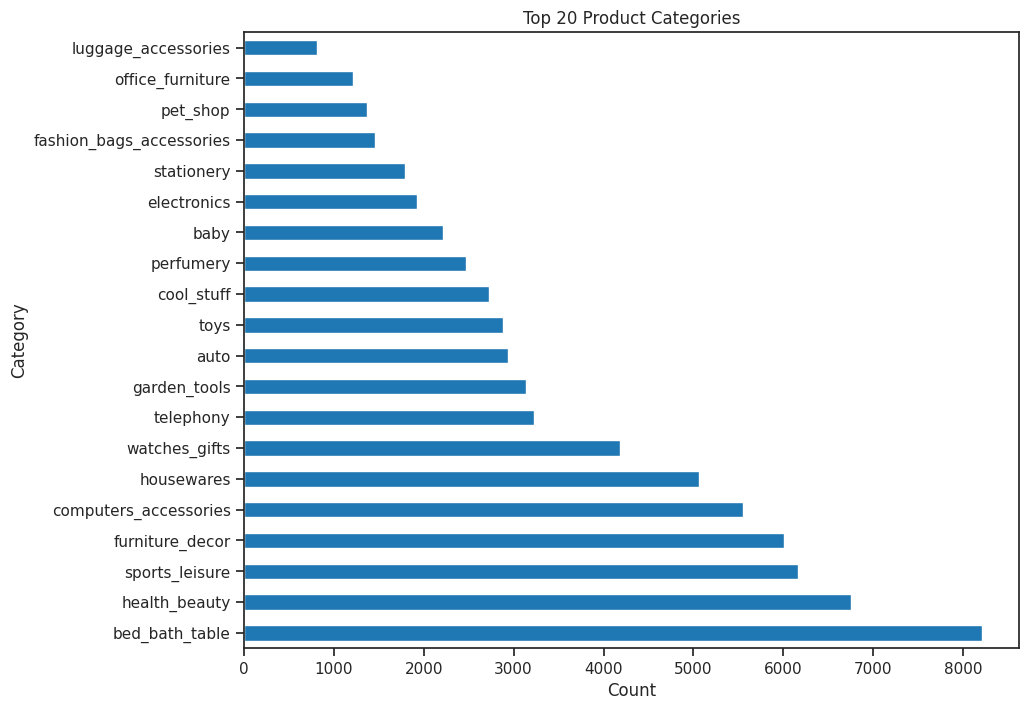

In [ ]:
# Distribution
train['product_category_name_english'].value_counts().head(20).plot(kind='barh', figsize=(10,8))
plt.title('Top 20 Product Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

In [ ]:
# product_category_name_english VS average number_of_delivery_days
train.groupby('product_category_name_english')['number_of_delivery_days'].mean().sort_values(ascending=False)

,number_of_delivery_days
product_category_name_english,
office_furniture,20.537449
security_and_services,19.000000
home_comfort_2,15.250000
christmas_supplies,15.048544
fashion_shoes,14.631868
...,...
party_supplies,8.756757
fashion_childrens_clothes,8.333333
books_imported,7.051282


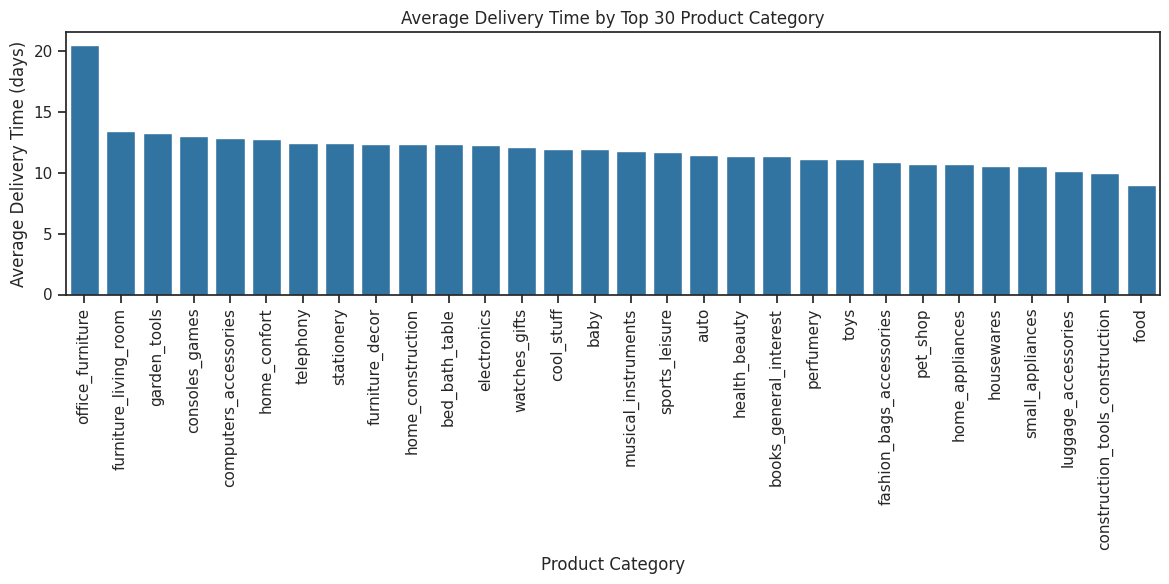

In [ ]:
# Average number_of_delivery_days for the top 30 product categories by count
top_product_category = train['product_category_name_english'].value_counts().head(30).index
average_delivery_time_by_product_category = train[train['product_category_name_english'].isin(top_product_category)].groupby('product_category_name_english')['number_of_delivery_days'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_product_category.index, y=average_delivery_time_by_product_category.values)
plt.xticks(rotation=90)
plt.title('Average Delivery Time by Top 30 Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

In [ ]:
# Phi-K correlation between product_category_name_english and target
columns_for_phik = train[['product_category_name_english', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['product_category_name_english', 'number_of_delivery_days']
print(f"Phi-K Correlation Product Category vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['number_of_delivery_days']
Phi-K Correlation Product Category vs Delivery Time: 0.109


**6. payment_type**

In [ ]:
# Counts for 'payment_type'
no_payment_type_categories = train['payment_type'].nunique()
print("Number of unique payment_type categories:", no_payment_type_categories)
train['payment_type'].value_counts(normalize=False)

Number of unique payment_type categories: 4


,count
payment_type,
credit_card,58517
boleto,15420
voucher,4171
debit_card,1125


In [ ]:
# payment_type VS average number_of_delivery_days
train.groupby('payment_type')['number_of_delivery_days'].mean().sort_values(ascending=False)

,number_of_delivery_days
payment_type,
boleto,12.932361
voucher,12.266603
credit_card,11.750927
debit_card,10.368000


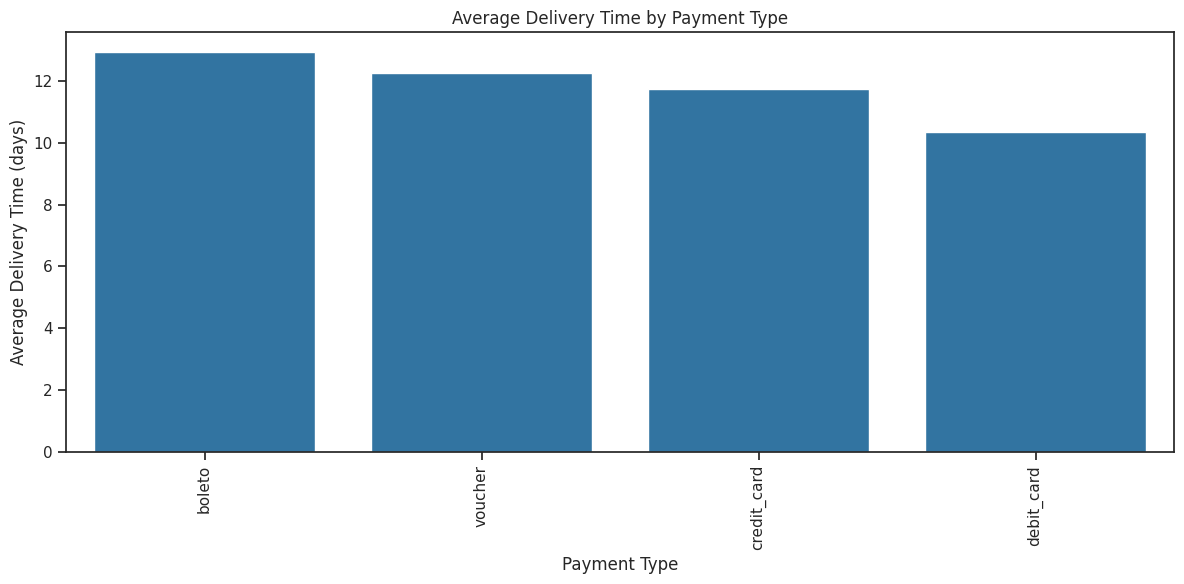

In [ ]:
# Average number_of_delivery_days by payment_type
average_delivery_time_by_payment_type= train.groupby('payment_type')['number_of_delivery_days'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_payment_type.index, y=average_delivery_time_by_payment_type.values)
plt.xticks(rotation=90)
plt.title('Average Delivery Time by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

In [ ]:
# Phi-K correlation between payment_type and target
columns_for_phik = train[['payment_type', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['payment_type', 'number_of_delivery_days']
print(f"Phi-K Correlation Payment Type vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['number_of_delivery_days']
Phi-K Correlation Payment Type vs Delivery Time: 0.026


### **Key takeaway from EDA of categorical predictors**
* Phi-K Correlation between Customer City vs Delivery Time: **0.67**
* Phi-K Correlation between Customer State vs Delivery Time: **0.307**
* Phi-K Correlation between Seller City vs Delivery Time: **0.326**
* Phi-K Correlation between Seller State vs Delivery Time: **0.104**
* Phi-K Correlation between Product Category vs Delivery Time: **0.109**
* Phi-K Correlation between Payment Type vs Delivery Time: **0.026**

## 8.5. Discrete predictors

In [ ]:
discrete = ['payment_installments',
            'product_name_length',
            'product_photos_qty']

**1. Visualising the distribution of discrete predictors**

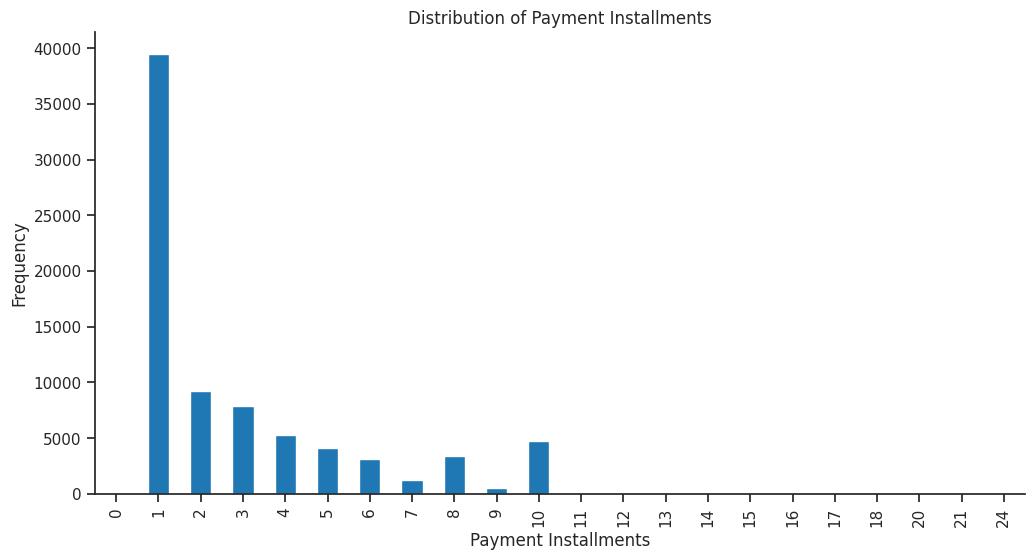

In [ ]:
# payment_installments
train['payment_installments'] = train['payment_installments'].astype(int)

plt.figure(figsize=(12, 6))

train['payment_installments'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of Payment Installments')
plt.xlabel('Payment Installments')
plt.ylabel('Frequency')

sns.despine()
plt.show()

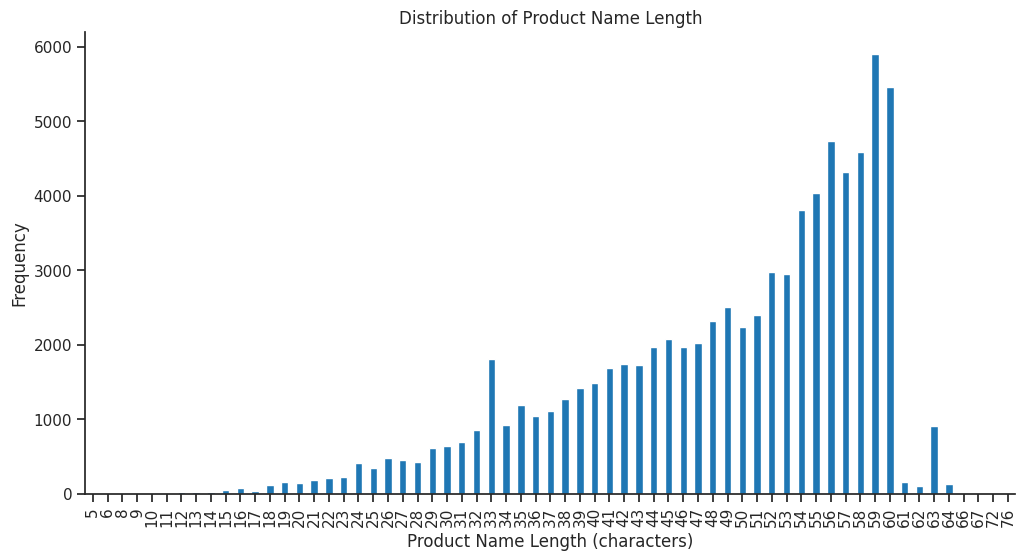

In [ ]:
# product_name_length
train['product_name_length'] = train['product_name_length'].astype(int)

plt.figure(figsize=(12, 6))

train['product_name_length'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of Product Name Length')
plt.xlabel('Product Name Length (characters)')
plt.ylabel('Frequency')

sns.despine()
plt.show()

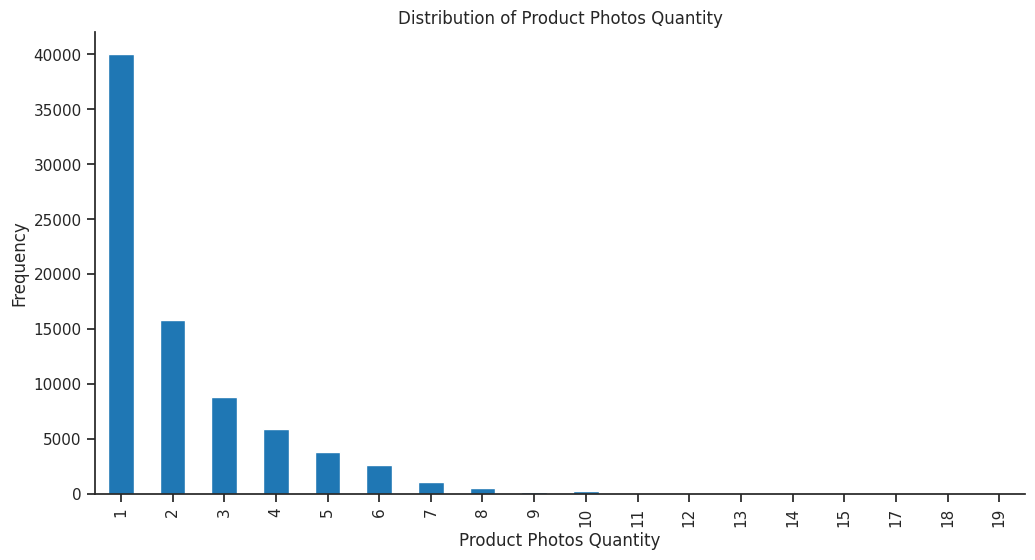

In [ ]:
# product_photos_qty
train['product_photos_qty'] = train['product_photos_qty'].astype(int)

plt.figure(figsize=(12, 6))

train['product_photos_qty'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of Product Photos Quantity')
plt.xlabel('Product Photos Quantity')
plt.ylabel('Frequency')

sns.despine()
plt.show()

**2. Boxplot to show relationship between discrete predictors and target**

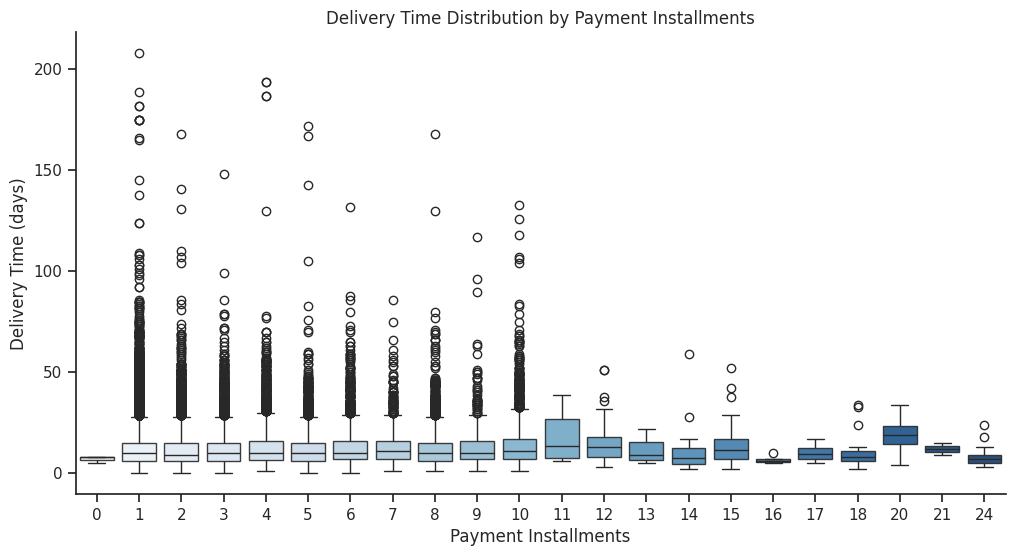

In [ ]:
# Boxplot of number_of_delivery_days by payment_installments
plt.figure(figsize=(12, 6))
sns.boxplot(x=train['payment_installments'], y=train['number_of_delivery_days'], boxprops=dict(alpha=.9), palette='Blues')
sns.despine()
plt.title('Delivery Time Distribution by Payment Installments')
plt.xlabel('Payment Installments')
plt.ylabel('Delivery Time (days)')
plt.show()

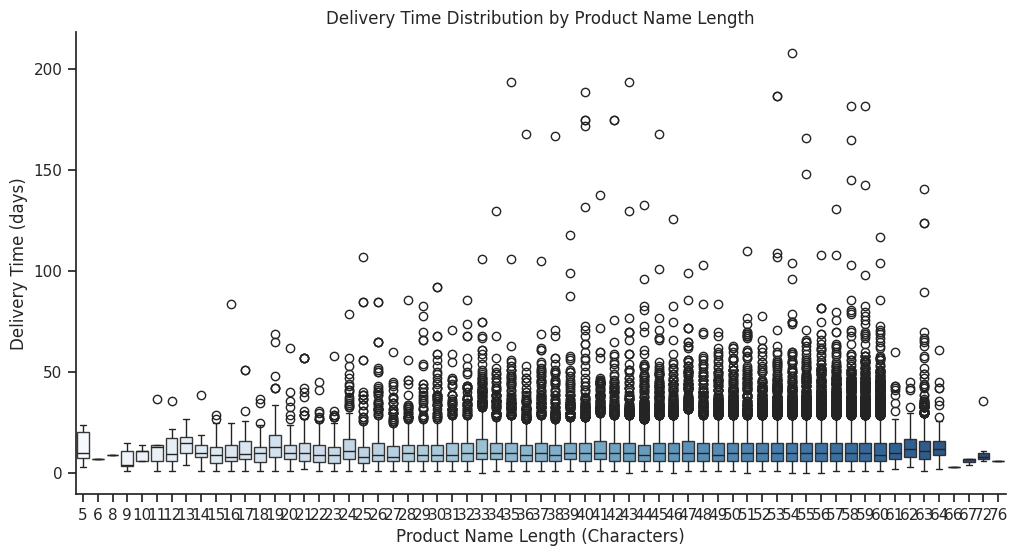

In [ ]:
# Boxplot of number_of_delivery_days by product_name_length
plt.figure(figsize=(12, 6))
sns.boxplot(x=train['product_name_length'], y=train['number_of_delivery_days'], boxprops=dict(alpha=.9), palette='Blues')
sns.despine()
plt.title('Delivery Time Distribution by Product Name Length')
plt.xlabel('Product Name Length (Characters)')
plt.ylabel('Delivery Time (days)')
plt.show()

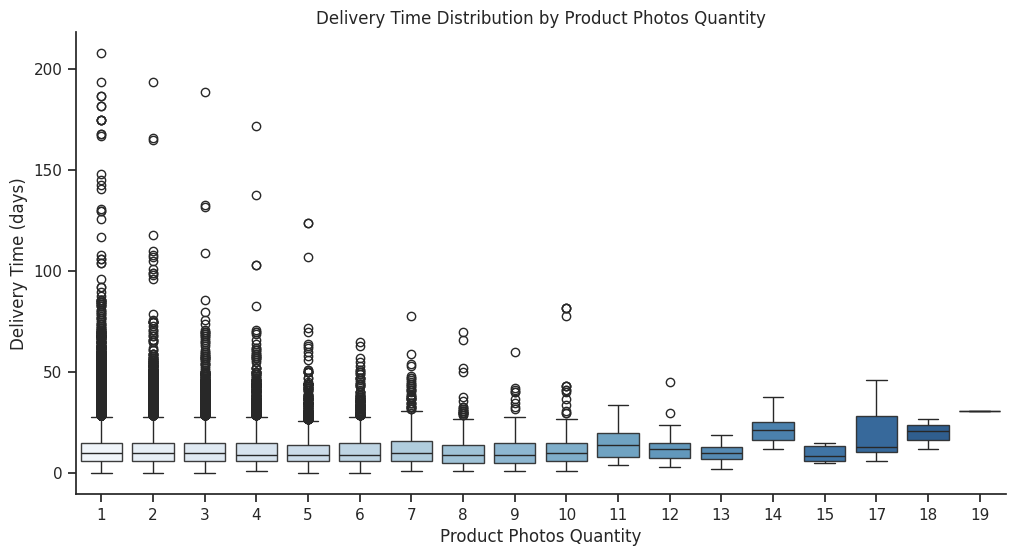

In [ ]:
# Boxplot of number_of_delivery_days by product_photos_qty
plt.figure(figsize=(12, 6))
sns.boxplot(x=train['product_photos_qty'], y=train['number_of_delivery_days'], boxprops=dict(alpha=.9), palette='Blues')
sns.despine()
plt.title('Delivery Time Distribution by Product Photos Quantity')
plt.xlabel('Product Photos Quantity')
plt.ylabel('Delivery Time (days)')
plt.show()

**3. Correlation between discrete predictors and target**

In [ ]:
# Phi-K correlation between payment_installments and target
columns_for_phik = train[['payment_installments', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['payment_installments', 'number_of_delivery_days']
print(f"Phi-K Correlation Payment Installments vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['payment_installments', 'number_of_delivery_days']
Phi-K Correlation Payment Installments vs Delivery Time: 0.02


In [ ]:
# Phi-K correlation between product_name_length and target
columns_for_phik = train[['product_name_length', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['product_name_length', 'number_of_delivery_days']
print(f"Phi-K Correlation Product Name Length vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['product_name_length', 'number_of_delivery_days']
Phi-K Correlation Product Name Length vs Delivery Time: 0.023


In [ ]:
# Phi-K correlation between product_photos_qty and target
columns_for_phik = train[['product_photos_qty', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['product_photos_qty', 'number_of_delivery_days']
print(f"Phi-K Correlation Product Photos Qty vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['product_photos_qty', 'number_of_delivery_days']
Phi-K Correlation Product Photos Qty vs Delivery Time: 0.021


## 8.6. Datetime predictors

**1. order_purchase_timestamp**

In [ ]:
# Extract hour of the day of order_purchase_timestamp
train['order_purchase_timestamp_hour'] = train['order_purchase_timestamp'].dt.hour
valid['order_purchase_timestamp_hour'] = valid['order_purchase_timestamp'].dt.hour

# Phi-K correlation
columns_for_phik = train[['order_purchase_timestamp_hour', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_purchase_timestamp_hour', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Purchase Timestamp Hour vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['order_purchase_timestamp_hour', 'number_of_delivery_days']
Phi-K Correlation Order Purchase Timestamp Hour vs Delivery Time: 0.01833


In [ ]:
# Extract day of the week of order_purchase_timestamp
train['order_purchase_timestamp_day'] = train['order_purchase_timestamp'].dt.dayofweek
valid['order_purchase_timestamp_day'] = valid['order_purchase_timestamp'].dt.dayofweek

# Phi-K correlation
columns_for_phik = train[['order_purchase_timestamp_day', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_purchase_timestamp_day', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Purchase Timestamp Day vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['order_purchase_timestamp_day', 'number_of_delivery_days']
Phi-K Correlation Order Purchase Timestamp Day vs Delivery Time: 0.00926


In [ ]:
# Extract month of the year of order_purchase_timestamp
train['order_purchase_timestamp_month'] = train['order_purchase_timestamp'].dt.month
valid['order_purchase_timestamp_month'] = valid['order_purchase_timestamp'].dt.month

# Phi-K correlation
columns_for_phik = train[['order_purchase_timestamp_month', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_purchase_timestamp_month', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Purchase Timestamp Month vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['order_purchase_timestamp_month', 'number_of_delivery_days']
Phi-K Correlation Order Purchase Timestamp Month vs Delivery Time: 0.21713


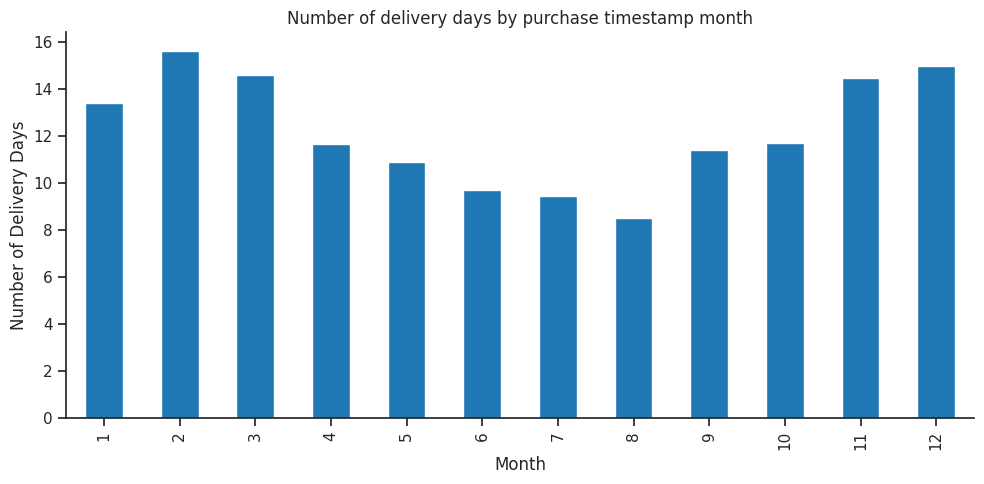

In [ ]:
# Visualise relationship
purchase_timestamp_month_delivery_days = train.groupby('order_purchase_timestamp_month')['number_of_delivery_days'].mean()

plt.figure(figsize=(10, 5))
purchase_timestamp_month_delivery_days.plot(kind='bar')
plt.title('Number of delivery days by purchase timestamp month')
plt.xlabel('Month')
plt.ylabel('Number of Delivery Days')
plt.tight_layout()
sns.despine()
plt.show()

**2. order_approved_at**

In [ ]:
# Extract hour of the day of order_approved_at
train['order_approved_at_hour'] = train['order_approved_at'].dt.hour
valid['order_approved_at_hour'] = valid['order_approved_at'].dt.hour

# Phi-K correlation
columns_for_phik = train[['order_approved_at_hour', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_approved_at_hour', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Approved At Hour vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['order_approved_at_hour', 'number_of_delivery_days']
Phi-K Correlation Order Approved At Hour vs Delivery Time: 0.02669


In [ ]:
# Extract day of the week of order_approved_at
train['order_approved_at_day'] = train['order_approved_at'].dt.dayofweek
valid['order_approved_at_day'] = valid['order_approved_at'].dt.dayofweek

# Phi-K correlation
columns_for_phik = train[['order_approved_at_day', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_approved_at_day', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Approved At Day vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['order_approved_at_day', 'number_of_delivery_days']
Phi-K Correlation Order Approved At Day vs Delivery Time: 0.01251


In [ ]:
# Extract month of the year of order_approved_at
train['order_approved_at_month'] = train['order_approved_at'].dt.month
valid['order_approved_at_month'] = valid['order_approved_at'].dt.month

# Phi-K correlation
columns_for_phik = train[['order_approved_at_month', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_approved_at_month', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Approved At Month vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['order_approved_at_month', 'number_of_delivery_days']
Phi-K Correlation Order Approved At Month vs Delivery Time: 0.21741


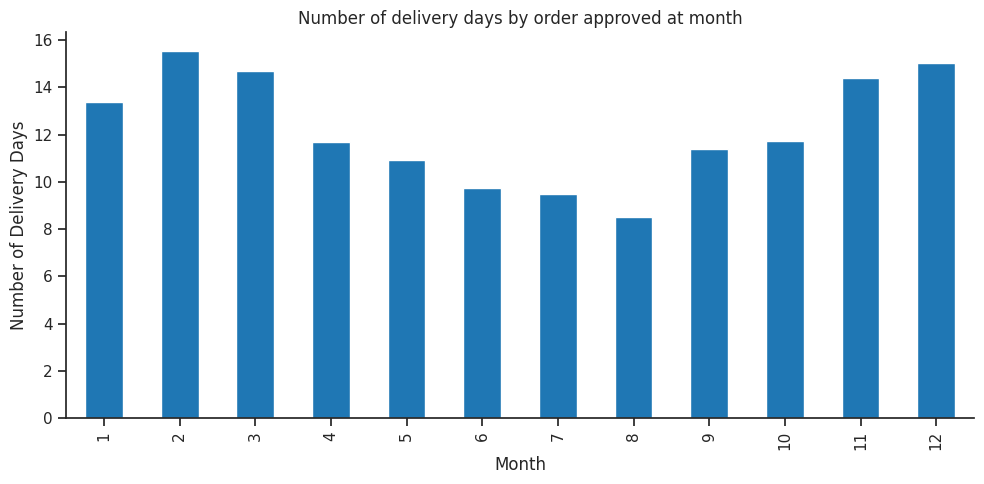

In [ ]:
# Visualise relationship
order_approved_at_month_delivery_days = train.groupby('order_approved_at_month')['number_of_delivery_days'].mean()

plt.figure(figsize=(10, 5))
order_approved_at_month_delivery_days.plot(kind='bar')
plt.title('Number of delivery days by order approved at month')
plt.xlabel('Month')
plt.ylabel('Number of Delivery Days')
plt.tight_layout()
sns.despine()
plt.show()

**3. order_delivered_carrier_date**

In [ ]:
# Extract hour of the day of order_delivered_carrier_date
train['order_delivered_carrier_date_hour'] = train['order_delivered_carrier_date'].dt.hour
valid['order_delivered_carrier_date_hour'] = valid['order_delivered_carrier_date'].dt.hour

# Phi-K correlation
columns_for_phik = train[['order_delivered_carrier_date_hour', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_delivered_carrier_date_hour', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Delivered Carrier Date Hour vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['order_delivered_carrier_date_hour', 'number_of_delivery_days']
Phi-K Correlation Order Delivered Carrier Date Hour vs Delivery Time: 0.133


In [ ]:
# Extract day of the week of order_approved_at
train['order_delivered_carrier_date_day'] = train['order_delivered_carrier_date'].dt.dayofweek
valid['order_delivered_carrier_date_day'] = valid['order_delivered_carrier_date'].dt.dayofweek

# Phi-K correlation
columns_for_phik = train[['order_delivered_carrier_date_day', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_delivered_carrier_date_day', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Delivered Carrier Date Day vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['order_delivered_carrier_date_day', 'number_of_delivery_days']
Phi-K Correlation Order Delivered Carrier Date Day vs Delivery Time: 0.035


In [ ]:
# Extract month of the year of order_approved_at
train['order_delivered_carrier_date_month'] = train['order_delivered_carrier_date'].dt.month
valid['order_delivered_carrier_date_month'] = valid['order_delivered_carrier_date'].dt.month

# Phi-K correlation
columns_for_phik = train[['order_delivered_carrier_date_month', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_delivered_carrier_date_month', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Delivered Carrier Date Month vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['order_delivered_carrier_date_month', 'number_of_delivery_days']
Phi-K Correlation Order Delivered Carrier Date Month vs Delivery Time: 0.217


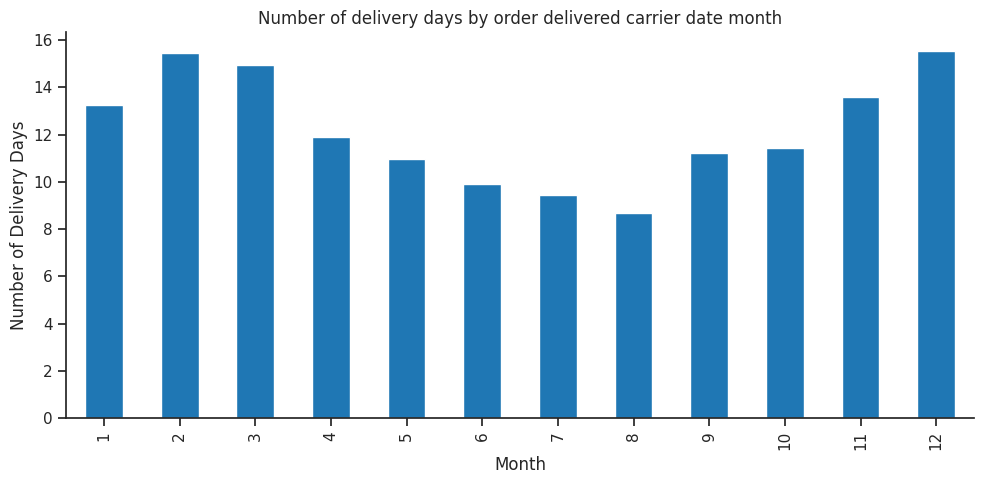

In [ ]:
# Visualise relationship
order_delivered_carrier_date_month_delivery_days = train.groupby('order_delivered_carrier_date_month')['number_of_delivery_days'].mean()

plt.figure(figsize=(10, 5))
order_delivered_carrier_date_month_delivery_days.plot(kind='bar')
plt.title('Number of delivery days by order delivered carrier date month')
plt.xlabel('Month')
plt.ylabel('Number of Delivery Days')
plt.tight_layout()
sns.despine()
plt.show()

**4. shipping_limit_date**

In [ ]:
# Extract hour of the day of order_delivered_carrier_date
train['shipping_limit_date_hour'] = train['shipping_limit_date'].dt.hour
valid['shipping_limit_date_hour'] = valid['shipping_limit_date'].dt.hour

# Phi-K correlation
columns_for_phik = train[['shipping_limit_date_hour', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['shipping_limit_date_hour', 'number_of_delivery_days']
print(f"Phi-K Correlation Shipping Limit Date Hour vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['shipping_limit_date_hour', 'number_of_delivery_days']
Phi-K Correlation Shipping Limit Date Hour vs Delivery Time: 0.029


In [ ]:
# Extract day of the week of order_approved_at
train['shipping_limit_date_day'] = train['shipping_limit_date'].dt.dayofweek
valid['shipping_limit_date_day'] = valid['shipping_limit_date'].dt.dayofweek

# Phi-K correlation
columns_for_phik = train[['shipping_limit_date_day', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['shipping_limit_date_day', 'number_of_delivery_days']
print(f"Phi-K Correlation Shipping Limit Date Day vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['shipping_limit_date_day', 'number_of_delivery_days']
Phi-K Correlation Shipping Limit Date Day vs Delivery Time: 0.017


In [ ]:
# Extract month of the year of order_approved_at
train['shipping_limit_date_month'] = train['shipping_limit_date'].dt.month
valid['shipping_limit_date_month'] = valid['shipping_limit_date'].dt.month

# Phi-K correlation
columns_for_phik = train[['shipping_limit_date_month', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['shipping_limit_date_month', 'number_of_delivery_days']
print(f"Phi-K Correlation Shipping Limit Date Month vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['shipping_limit_date_month', 'number_of_delivery_days']
Phi-K Correlation Shipping Limit Date Month vs Delivery Time: 0.218


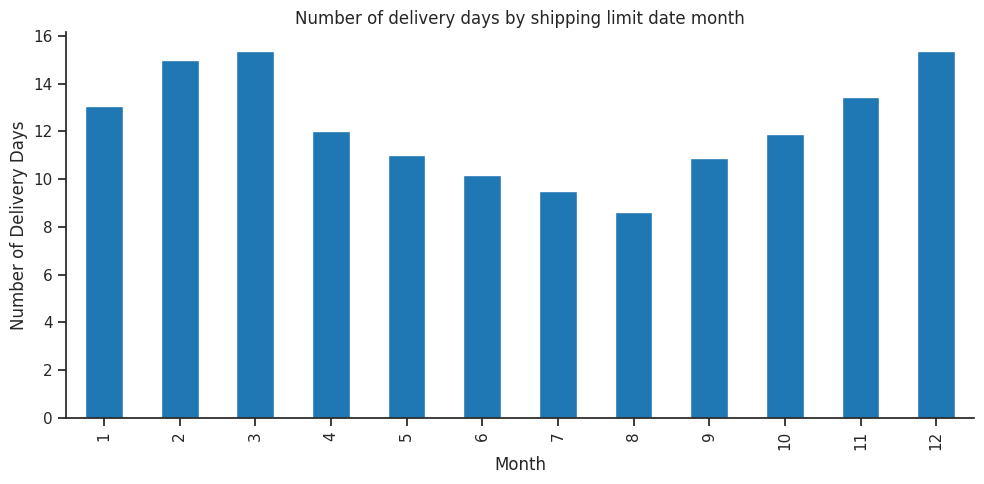

In [ ]:
# Visualise relationship
shipping_limite_date_month_delivery_days = train.groupby('shipping_limit_date_month')['number_of_delivery_days'].mean()

plt.figure(figsize=(10, 5))
shipping_limite_date_month_delivery_days.plot(kind='bar')
plt.title('Number of delivery days by shipping limit date month')
plt.xlabel('Month')
plt.ylabel('Number of Delivery Days')
plt.tight_layout()
sns.despine()
plt.show()

## 8.7. ID predictors

**1. seller_id**

In [ ]:
# counts of sellers
no_seller_categories = train['seller_id'].nunique()
print("Number of unique sellers:", no_seller_categories)

Number of unique sellers: 2716


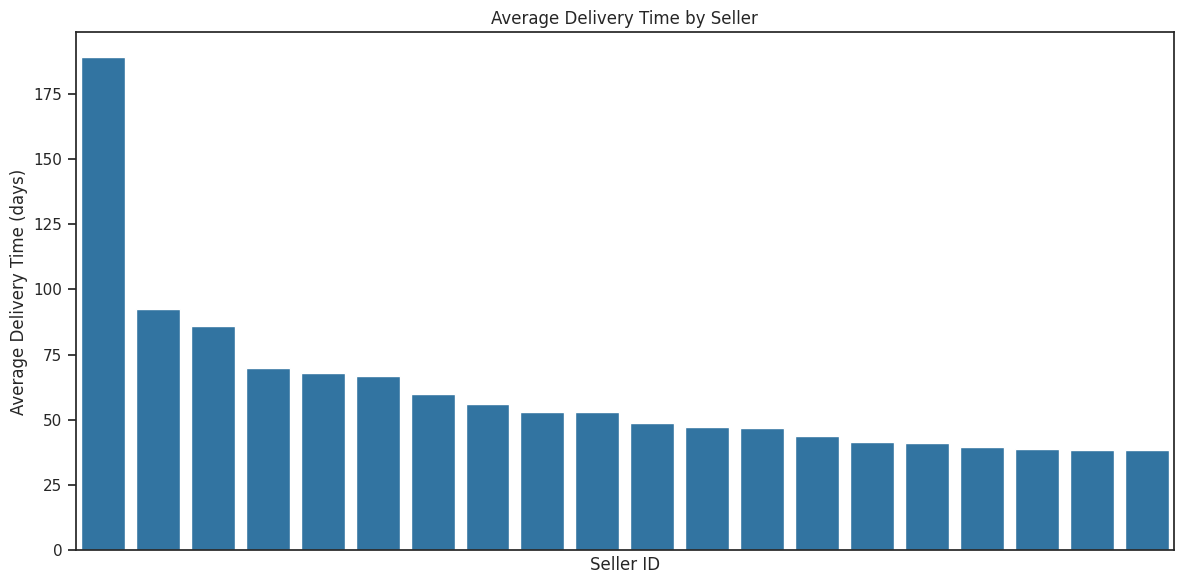

In [ ]:
# Average delivery days for each seller
average_delivery_time_by_seller = train.groupby('seller_id')['number_of_delivery_days'].mean().sort_values(ascending=False)

# Visualisation of the top 20 sellers longest delivery days
plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_seller.index[:20], y=average_delivery_time_by_seller.values[:20])

# Remove x axis values
plt.xticks([])
plt.title('Average Delivery Time by Seller')
plt.xlabel('Seller ID')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

**2. product_id**

In [ ]:
# counts of sellers
no_product_categories = train['product_id'].nunique()
print("Number of unique products:", no_product_categories)

Number of unique products: 25856


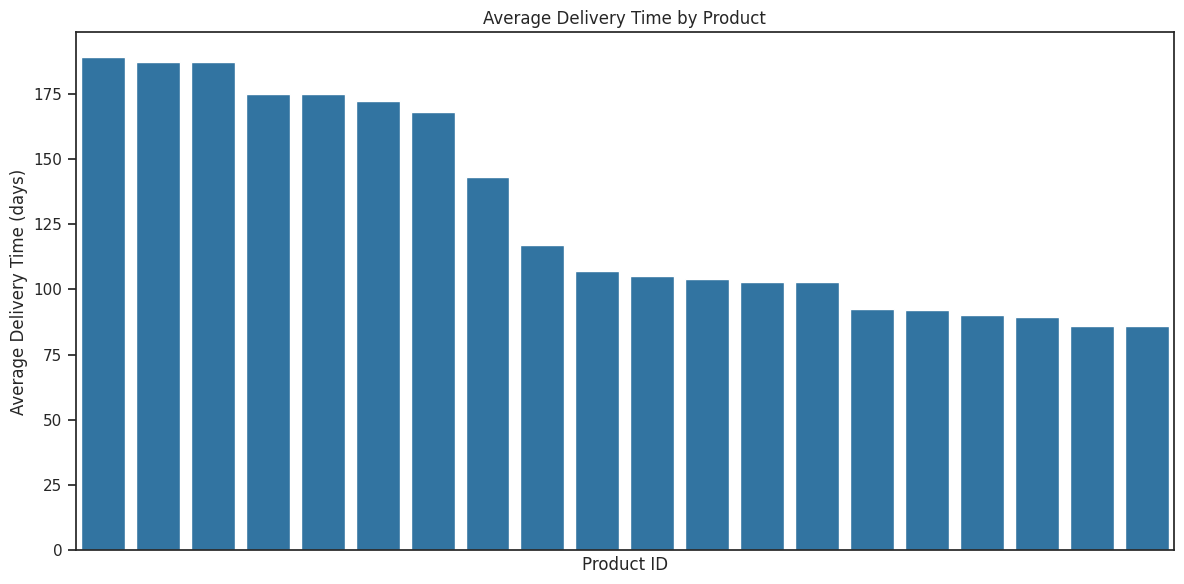

In [ ]:
# Average delivery days for each product
average_delivery_time_by_product = train.groupby('product_id')['number_of_delivery_days'].mean().sort_values(ascending=False)

# Visualisation of the top 20 sellers longest delivery days
plt.figure(figsize=(12, 6))
sns.barplot(x=average_delivery_time_by_product.index[:20], y=average_delivery_time_by_product.values[:20])

# Remove x axis values
plt.xticks([])
plt.title('Average Delivery Time by Product')
plt.xlabel('Product ID')
plt.ylabel('Average Delivery Time (days)')
plt.tight_layout()
plt.show()

# 9. Feature Engineering

## 9.1. Created features

### **1. Customer-Seller Distance**

**Business reasoning**: the further the distance the seller is from the customer, the longer the delivery time.

In [ ]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, [lat1, lng1, lat2, lng2])
    dlat = lat2 - lat1
    dlng = lng2 - lng1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlng/2)**2
    return 2 * 6371 * np.arcsin(np.sqrt(a))  # Earth radius in km

# Create the distance column in train
train['customer_seller_distance_km'] = haversine(
    train['customer_lat'], train['customer_lng'],
    train['seller_lat'], train['seller_lng']
)

# Create the distance column in valid
valid['customer_seller_distance_km'] = haversine(
    valid['customer_lat'], valid['customer_lng'],
    valid['seller_lat'], valid['seller_lng']
)

# Create the distance column in test
test['customer_seller_distance_km'] = haversine(
    test['customer_lat'], test['customer_lng'],
    test['seller_lat'], test['seller_lng']
)

In [ ]:
train['customer_seller_distance_km'].describe()

,customer_seller_distance_km
count,79233.000000
mean,596.650353
std,587.311279
min,0.000000
25%,191.319973
50%,433.160176
75%,791.091479
max,8677.911622


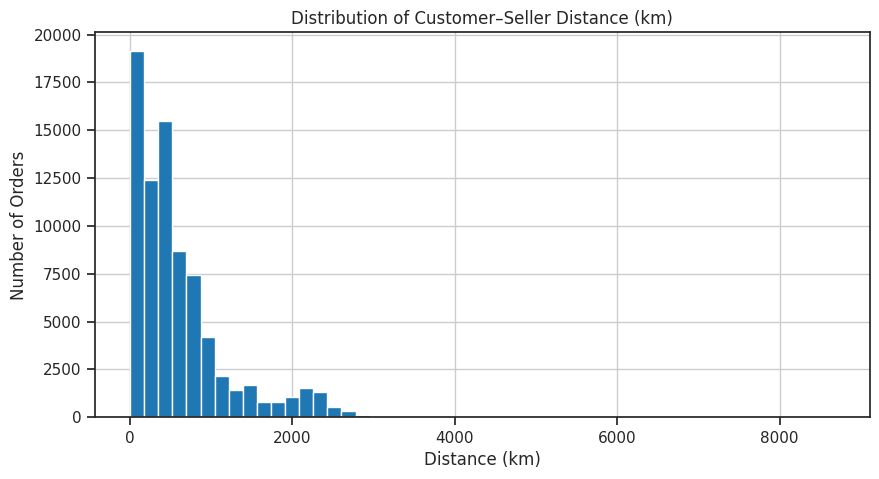

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(train['customer_seller_distance_km'], bins=50)
plt.title('Distribution of Customer–Seller Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

**Relationship with Target Variable Analysis**

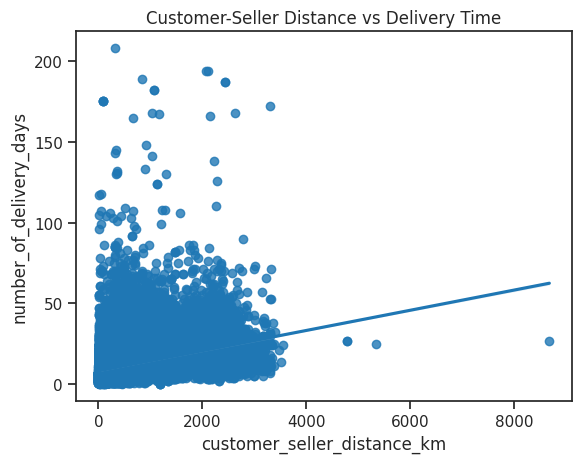

In [ ]:
sns.regplot(x='customer_seller_distance_km', y='number_of_delivery_days', data=train)
plt.title('Customer-Seller Distance vs Delivery Time')
plt.show()

In [ ]:
# Pearson correlation
correlation = train['customer_seller_distance_km'].corr(train['number_of_delivery_days'])
print(f"Pearson Correlation Customer-Seller Distance vs Delivery Time: {correlation.round(3)}")

Pearson Correlation Customer-Seller Distance vs Delivery Time: 0.393


In [ ]:
# Phi-K correlation
columns_for_phik = train[['customer_seller_distance_km', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['customer_seller_distance_km', 'number_of_delivery_days']
print(f"Phi-K Correlation Customer-Seller Distance vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['customer_seller_distance_km', 'number_of_delivery_days']
Phi-K Correlation Customer-Seller Distance vs Delivery Time: 0.199


**Outlier Analysis**

In [ ]:
# Identify outliers
Q1 = train['customer_seller_distance_km'].quantile(0.25)
Q3 = train['customer_seller_distance_km'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['customer_seller_distance_km'] < lower_bound) | (train['customer_seller_distance_km'] > upper_bound)]
print(f"Number of outliers using IQR: {len(outliers)}")

Number of outliers using IQR: 6053


In [ ]:
# Capping the outlier values at a certain percentile
lower_percentile = train['customer_seller_distance_km'].quantile(0.05)
upper_percentile = train['customer_seller_distance_km'].quantile(0.95)

train['customer_seller_distance_km_capped'] = train['customer_seller_distance_km'].clip(lower=lower_percentile, upper=upper_percentile)
valid['customer_seller_distance_km_capped'] = valid['customer_seller_distance_km'].clip(lower=lower_percentile, upper=upper_percentile)
test['customer_seller_distance_km_capped'] = test['customer_seller_distance_km'].clip(lower=lower_percentile, upper=upper_percentile)

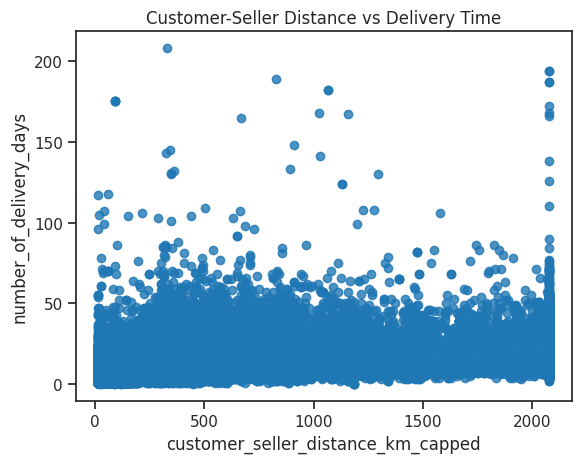

In [ ]:
sns.regplot(x='customer_seller_distance_km_capped', y='number_of_delivery_days', data=train)
plt.title('Customer-Seller Distance vs Delivery Time')
plt.show()

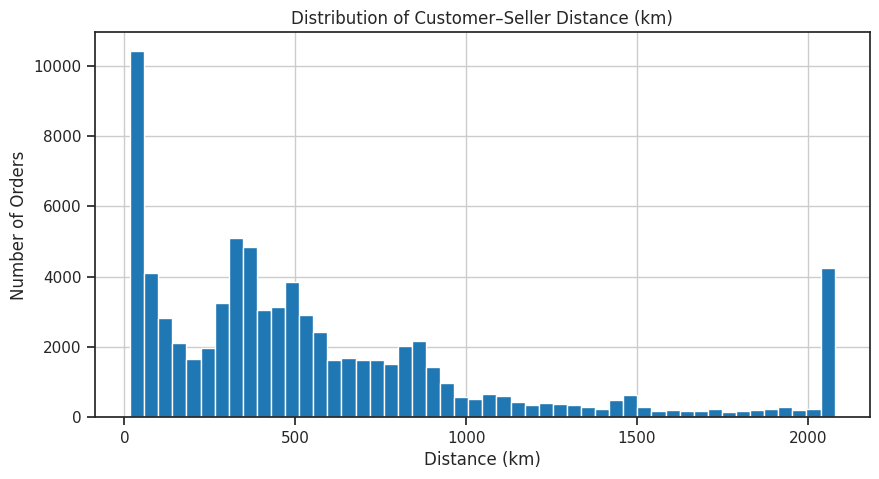

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(train['customer_seller_distance_km_capped'], bins=50)
plt.title('Distribution of Customer–Seller Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

**Try Log Distribution**

In [ ]:
# train_log = train.copy()
# train_log['customer_seller_distance_km_capped_log'] = np.log(train['customer_seller_distance_km_capped'])

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.hist(train_log['customer_seller_distance_km_capped_log'], bins=50)
# plt.title('Distribution of Customer–Seller Distance (km)')
# plt.xlabel('Distance (km)')
# plt.ylabel('Number of Orders')
# plt.grid(True)
# plt.show()

In [ ]:
# sns.regplot(x='customer_seller_distance_km_capped_log', y='number_of_delivery_days', data=train_log)
# plt.title('Customer-Seller Distance vs Delivery Time')
# plt.show()

### **2. Product Size**

**Business reasoning**: the bulkier the product size, the longer the delivery time due to increased complexity in organising shipment.

In [ ]:
# Product size
train['product_size'] = train['product_length_cm'] * train['product_height_cm'] * train['product_width_cm']
valid['product_size'] = valid['product_length_cm'] * valid['product_height_cm'] * valid['product_width_cm']
test['product_size'] = test['product_length_cm'] * test['product_height_cm'] * test['product_width_cm']

Text(0, 0.5, 'Number of Orders')

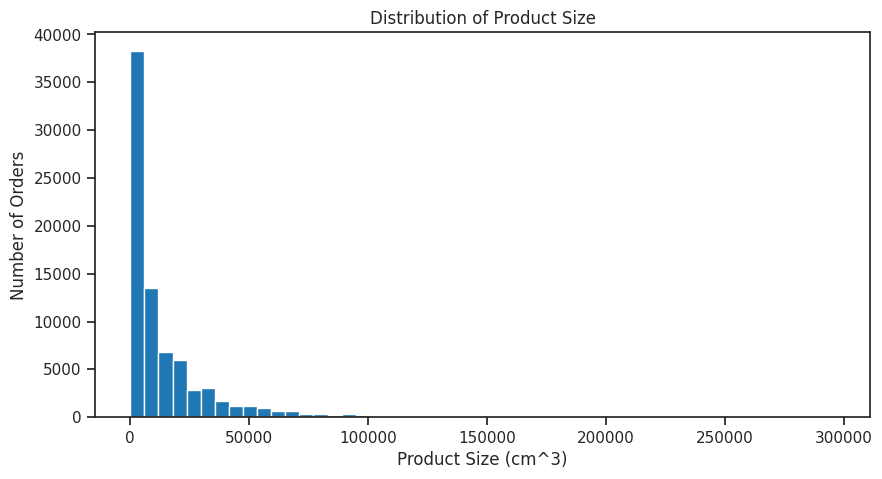

In [ ]:
# Distribution of product_size
plt.figure(figsize=(10, 5))
plt.hist(train['product_size'], bins=50)
plt.title('Distribution of Product Size')
plt.xlabel('Product Size (cm^3)')
plt.ylabel('Number of Orders')

**Relationship with Target Variable Analysis**

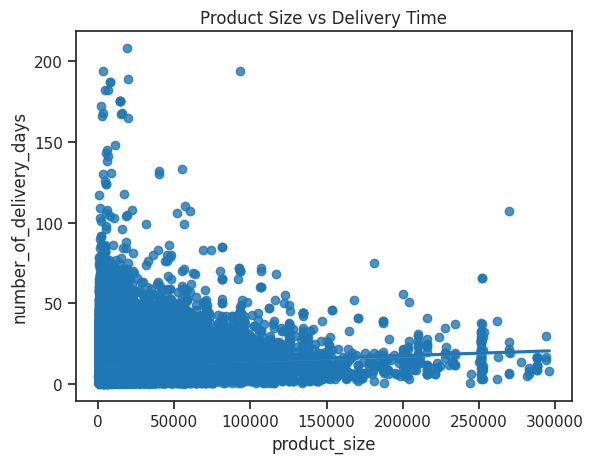

In [ ]:
# Relationship with number_of_delivery_days
sns.regplot(x='product_size', y='number_of_delivery_days', data=train)
plt.title('Product Size vs Delivery Time')
plt.show()

In [ ]:
# Pearson correlation
correlation = train['product_size'].corr(train['number_of_delivery_days'])
print(f"Correlation Product Size vs Delivery Time: {correlation.round(5)}")

Correlation Product Size vs Delivery Time: 0.07741


In [ ]:
# Phi-K correlation
columns_for_phik = train[['product_size', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['product_size', 'number_of_delivery_days']
print(f"Phi-K Correlation Product Size vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['product_size', 'number_of_delivery_days']
Phi-K Correlation Product Size vs Delivery Time: 0.09624


**Different combinations in Product Size (Trial and Error)**

In [ ]:
train_product_size = train.copy()
valid_product_size = valid.copy()
# test_product_size = test.copy()

**a. Length vs Height**

In [ ]:
train_product_size['product_length_height'] = train_product_size['product_length_cm'] * train_product_size['product_height_cm']
valid_product_size['product_length_height'] = valid_product_size['product_length_cm'] * valid_product_size['product_height_cm']
# test['product_length_height'] = test['product_length_cm'] * test['product_height_cm'] * test['product_width_cm']

In [ ]:
# Pearson correlation
correlation = train_product_size['product_length_height'].corr(train_product_size['number_of_delivery_days'])
print(f"Correlation Product Length & Height vs Delivery Time: {correlation.round(5)}")

Correlation Product Length & Height vs Delivery Time: 0.0943


In [ ]:
# Phi-K correlation
columns_for_phik = train_product_size[['product_length_height', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['product_length_height', 'number_of_delivery_days']
print(f"Phi-K Correlation Product Length & Height vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['product_length_height', 'number_of_delivery_days']
Phi-K Correlation Product Length & Height vs Delivery Time: 0.09912


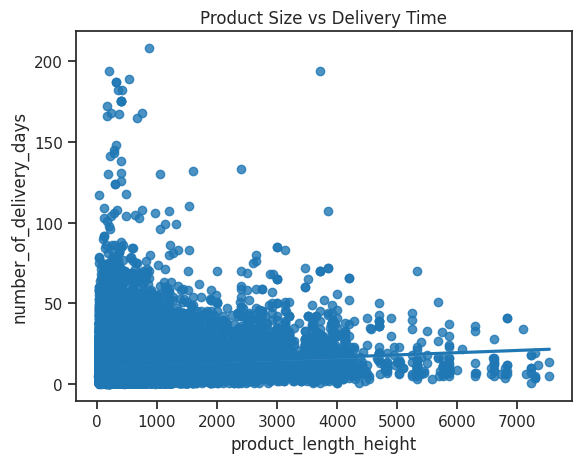

In [ ]:
sns.regplot(x='product_length_height', y='number_of_delivery_days', data=train_product_size)
plt.title('Product Size vs Delivery Time')
plt.show()

**b. Length vs Width**

In [ ]:
train_product_size['product_length_width'] = train_product_size['product_length_cm'] * train_product_size['product_width_cm']
valid_product_size['product_length_width'] = valid_product_size['product_length_cm'] * valid_product_size['product_width_cm']
# test['product_length_height'] = test['product_length_cm'] * test['product_height_cm'] * test['product_width_cm']

In [ ]:
# Pearson correlation
correlation = train_product_size['product_length_width'].corr(train_product_size['number_of_delivery_days'])
print(f"Correlation Product Length & Width vs Delivery Time: {correlation.round(5)}")

Correlation Product Length & Width vs Delivery Time: 0.05516


In [ ]:
# Phi-K correlation
columns_for_phik = train_product_size[['product_length_width', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['product_length_width', 'number_of_delivery_days']
print(f"Phi-K Correlation Product Length & Width vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['product_length_width', 'number_of_delivery_days']
Phi-K Correlation Product Length & Width vs Delivery Time: 0.05142


**c. Height vs Width**

In [ ]:
train_product_size['product_height_width'] = train_product_size['product_height_cm'] * train_product_size['product_width_cm']
valid_product_size['product_height_width'] = valid_product_size['product_height_cm'] * valid_product_size['product_width_cm']
# test['product_length_height'] = test['product_length_cm'] * test['product_height_cm'] * test['product_width_cm']

In [ ]:
# Pearson correlation
correlation = train_product_size['product_height_width'].corr(train_product_size['number_of_delivery_days'])
print(f"Correlation Product Height & Width vs Delivery Time: {correlation.round(5)}")

Correlation Product Height & Width vs Delivery Time: 0.06148


In [ ]:
# Phi-K correlation
columns_for_phik = train_product_size[['product_height_width', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['product_height_width', 'number_of_delivery_days']
print(f"Phi-K Correlation Product Height & Width vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['product_height_width', 'number_of_delivery_days']
Phi-K Correlation Product Height & Width vs Delivery Time: 0.03663


### **3. Seller Process Time**

**Business reasoning**:
* The longer it takes for the seller to hand the package over to the shipping carrier, the longer the delivery time.
* Some sellers may be faster or slower than others.

Will be measured in days:

In [ ]:
# Calculate seller_process_time
train['seller_process_time'] = (pd.to_datetime(train['order_delivered_carrier_date']) - pd.to_datetime(train['order_approved_at'])).dt.days

# Calculate the average seller_process_time for each seller_id
average_seller_process_time = train.groupby('seller_id')['seller_process_time'].mean()

# Map the average seller_process_time back to each seller_id
train['average_seller_process_time'] = train['seller_id'].map(average_seller_process_time)
valid['average_seller_process_time'] = valid['seller_id'].map(average_seller_process_time)
test['average_seller_process_time'] = test['seller_id'].map(average_seller_process_time)

**Relationship with Target Variable Analysis**

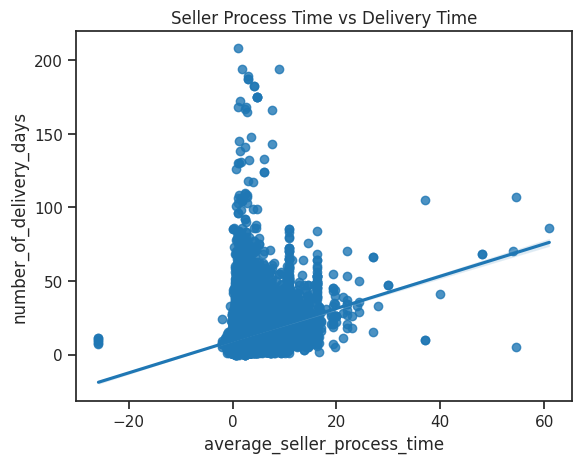

In [ ]:
sns.regplot(x='average_seller_process_time', y='number_of_delivery_days', data=train)
plt.title('Seller Process Time vs Delivery Time')
plt.show()

In [ ]:
# Pearson correlation
correlation = train['average_seller_process_time'].corr(train['number_of_delivery_days'])
print(f"Correlation Average Delivery Time by Seller vs Delivery Time: {correlation.round(3)}")

Correlation Average Delivery Time by Seller vs Delivery Time: 0.25


In [ ]:
# Phi-K correlation
columns_for_phik = train[['average_seller_process_time', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['average_seller_process_time', 'number_of_delivery_days']
print(f"Phi-K Correlation Average Delivery Time by Seller vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['average_seller_process_time', 'number_of_delivery_days']
Phi-K Correlation Average Delivery Time by Seller vs Delivery Time: 0.239


**Outlier Analysis**

In [ ]:
# Identify outliers
Q1 = train['average_seller_process_time'].quantile(0.25)
Q3 = train['average_seller_process_time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['average_seller_process_time'] < lower_bound) | (train['average_seller_process_time'] > upper_bound)]
print(f"Number of outliers using IQR: {len(outliers)}")

Number of outliers using IQR: 4606


In [ ]:
# Capping the outlier values at a certain percentile
lower_percentile = train['average_seller_process_time'].quantile(0.05)
upper_percentile = train['average_seller_process_time'].quantile(0.95)

train['average_seller_process_time_capped'] = train['average_seller_process_time'].clip(lower=lower_percentile, upper=upper_percentile)
valid['average_seller_process_time_capped'] = valid['average_seller_process_time'].clip(lower=lower_percentile, upper=upper_percentile)
test['average_seller_process_time_capped'] = test['average_seller_process_time'].clip(lower=lower_percentile, upper=upper_percentile)

### **4. Number of items in order**

In [ ]:
# Number of items in each order
train['order_quantity'] = train.groupby('order_id')['order_item_id'].transform('max')
valid['order_quantity'] = valid.groupby('order_id')['order_item_id'].transform('max')
test['order_quantity'] = test.groupby('order_id')['order_item_id'].transform('max')

In [ ]:
# Pearson correlation
correlation = train['order_quantity'].corr(train['number_of_delivery_days'])
print(f"Correlation Order Quantity vs Delivery Time: {correlation.round(3)}")

Correlation Order Quantity vs Delivery Time: -0.019


In [ ]:
# Phi-K correlation
columns_for_phik = train[['order_quantity', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_quantity', 'number_of_delivery_days']
print(f"Phi-K Correlation Order Quantity vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['order_quantity', 'number_of_delivery_days']
Phi-K Correlation Order Quantity vs Delivery Time: 0.0


### **5. Average Delivery Time by Product**

**Business reasoning**: some products may be delivered faster or slower than others (e.g. due to its characteristics like size).

In [ ]:
# Average delivery days for each product
average_delivery_time_by_product = train.groupby('product_id')['number_of_delivery_days'].mean()

# Map the average seller_process_time back to each product_id
train['average_delivery_time_by_product'] = train['product_id'].map(average_delivery_time_by_product)
valid['average_delivery_time_by_product'] = valid['product_id'].map(average_delivery_time_by_product)
test['average_delivery_time_by_product'] = test['product_id'].map(average_delivery_time_by_product)

**Relationship with Target Variable Analysis**

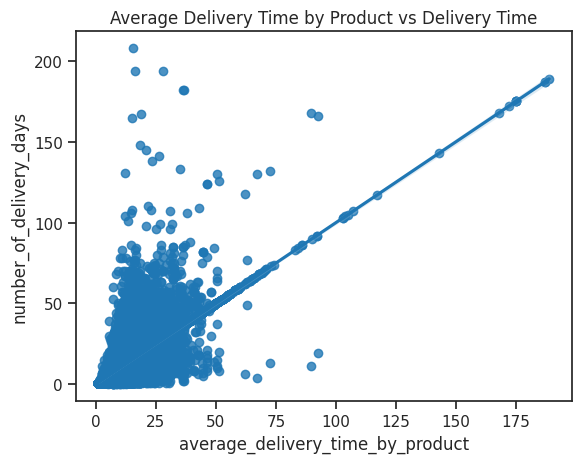

In [ ]:
sns.regplot(x='average_delivery_time_by_product', y='number_of_delivery_days', data=train)
plt.title('Average Delivery Time by Product vs Delivery Time')
plt.show()

In [ ]:
# Pearson correlation
correlation = train['average_delivery_time_by_product'].corr(train['number_of_delivery_days'])
print(f"Correlation Average Delivery Time by Product vs Delivery Time: {correlation.round(3)}")

Correlation Average Delivery Time by Product vs Delivery Time: 0.673


In [ ]:
# Phi-K correlation
columns_for_phik = train[['average_delivery_time_by_product', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['average_delivery_time_by_product', 'number_of_delivery_days']
print(f"Phi-K Correlation Average Delivery Time by Product vs Delivery Time: {phi_k.round(3)}")

interval columns not set, guessing: ['average_delivery_time_by_product', 'number_of_delivery_days']
Phi-K Correlation Average Delivery Time by Product vs Delivery Time: 0.844


### **6. Order Approval Processing Time**

**Business reasoning**: the longer the time to process an order for approval, the longer the delivery time.

In [ ]:
# Order Approval Processing Time (purchase date to approval date)
train['order_approval_process_time'] = (pd.to_datetime(train['order_approved_at']) - pd.to_datetime(train['order_purchase_timestamp'])).dt.days
valid['order_approval_process_time'] = (pd.to_datetime(valid['order_approved_at']) - pd.to_datetime(valid['order_purchase_timestamp'])).dt.days
test['order_approval_process_time'] = (pd.to_datetime(test['order_approved_at']) - pd.to_datetime(test['order_purchase_timestamp'])).dt.days

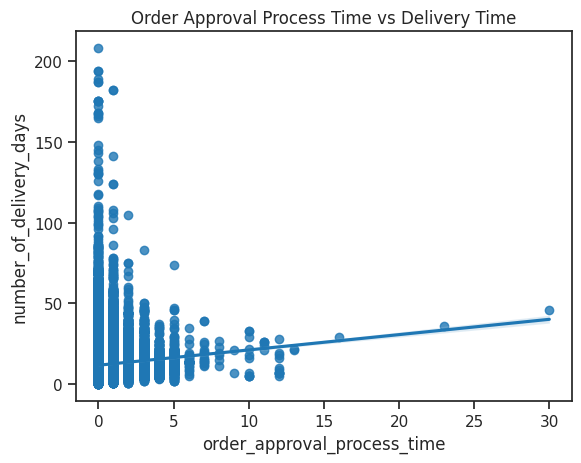

In [ ]:
sns.regplot(x='order_approval_process_time', y='number_of_delivery_days', data=train)
plt.title('Order Approval Process Time vs Delivery Time')
plt.show()

In [ ]:
# Pearson correlation
correlation = train['order_approval_process_time'].corr(train['number_of_delivery_days'])
print(f"Correlation Order Approval Processing Time vs Delivery Time: {correlation.round(5)}")

Correlation Order Approval Processing Time vs Delivery Time: 0.07472


In [ ]:
# Phi-K correlation
columns_for_phik = train[['order_approval_process_time', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['order_approval_process_time', 'number_of_delivery_days']
print(f"Phi-K Order Approval Processing Time vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['order_approval_process_time', 'number_of_delivery_days']
Phi-K Order Approval Processing Time vs Delivery Time: 0.02593


### **7. Seller Shipping Delay**

In [ ]:
# Order Seller Processing Time (purchase date to approval date)
train['seller_shipping_delay'] = (pd.to_datetime(train['order_delivered_carrier_date']) - pd.to_datetime(train['shipping_limit_date'])).dt.days
valid['seller_shipping_delay'] = (pd.to_datetime(valid['order_delivered_carrier_date']) - pd.to_datetime(valid['shipping_limit_date'])).dt.days

# if positive = delay
# if negative = no delay

In [ ]:
# Pearson correlation
correlation = train['seller_shipping_delay'].corr(train['number_of_delivery_days'])
print(f"Correlation Seller Seller Shipping Delay vs Delivery Time: {correlation.round(5)}")

Correlation Seller Seller Shipping Delay vs Delivery Time: 0.12649


In [ ]:
# Phi-K correlation
columns_for_phik = train[['seller_shipping_delay', 'number_of_delivery_days']]
phi_k_matrix = columns_for_phik.phik_matrix()
phi_k = phi_k_matrix.loc['seller_shipping_delay', 'number_of_delivery_days']
print(f"Phi-K Seller Shipping Delay vs Delivery Time: {phi_k.round(5)}")

interval columns not set, guessing: ['seller_shipping_delay', 'number_of_delivery_days']
Phi-K Seller Shipping Delay vs Delivery Time: 0.03418


## 9.2. Feature transformations and engineering techniques

1. Scaling numerical features
2. Categorical encoding (including dummy encoding, one-hot encoding, Label Encoding)

## 9.3. Feature selection process

**1. Target variable**

In [ ]:
target = ['number_of_delivery_days']

**2. Predictors**

In [ ]:
# List of all predictors available to use

predictors = ['customer_seller_distance_km', 'customer_seller_distance_km_capped',
              'product_size',
              'average_seller_process_time', 'average_seller_process_time_capped',
              'order_quantity',
              'average_delivery_time_by_product',
              'price',
              'freight_value',
              'payment_value',
              'product_weight_g',
              'customer_city',
              'customer_state',
              'seller_city',
              'seller_state',
              'product_category_name_english',
              'payment_type',
              'payment_installments',
              'payment_sequential',
              'product_name_length',
              'product_photos_qty',
              'product_description_length',
              'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
              'shipping_limit_date_hour', 'shipping_limit_date_day', 'shipping_limit_date_month']

In [ ]:
# available features that are not currently considered
excluded_features = ['order_estimated_delivery_date',
                     'order_approval_process_time',
                     'order_approved_at_hour', 'order_approved_at_day', 'order_approved_at_month',
                     'order_delivered_carrier_date_hour', 'order_delivered_carrier_date_day', 'order_delivered_carrier_date_month']

# 10. Model Training

## 10.1. Linear Regression

In [ ]:
train_lin = train.copy()
valid_lin = valid.copy()

### **10.1.1. Simple Linear Regression**

**Justification:** First considered the variable with the highest linear correlation with the target, which is `customer_seller_distance_km`.

**Using customer_seller_distance_km**

In [ ]:
# Simple Linear Regression
slr_model = smf.ols(formula='number_of_delivery_days ~ customer_seller_distance_km', data=train_lin).fit()

In [ ]:
# Make predictions using validation data
y_pred_slr = slr_model.predict({'customer_seller_distance_km': valid_lin['customer_seller_distance_km']})

# Evaluate performance
mae_slr = mean_absolute_error(valid_lin['number_of_delivery_days'], y_pred_slr)
r2_slr = r2_score(valid_lin['number_of_delivery_days'], y_pred_slr)
rmse_slr = np.sqrt(mean_squared_error(valid_lin['number_of_delivery_days'], y_pred_slr))

print(f"Simple Linear Regression Performance:")
print(f"RMSE: {rmse_slr:.3f}")
print(f"MAE: {mae_slr:.3f}")
print(f"R²: {r2_slr:.3f}")

Simple Linear Regression Performance:
RMSE: 8.624
MAE: 5.539
R²: 0.154


**Using customer_seller_distance_km_capped**

In [ ]:
# Simple Linear Regression
slr_model = smf.ols(formula='number_of_delivery_days ~ customer_seller_distance_km_capped', data=train_lin).fit()

In [ ]:
# Make predictions using validation data
y_pred_slr = slr_model.predict({'customer_seller_distance_km_capped': valid_lin['customer_seller_distance_km_capped']})

# Evaluate performance
mae_slr = mean_absolute_error(valid_lin['number_of_delivery_days'], y_pred_slr)
r2_slr = r2_score(valid_lin['number_of_delivery_days'], y_pred_slr)
rmse_slr = np.sqrt(mean_squared_error(valid_lin['number_of_delivery_days'], y_pred_slr))

print(f"Simple Linear Regression Performance:")
print(f"RMSE: {rmse_slr:.3f}")
print(f"MAE: {mae_slr:.3f}")
print(f"R²: {r2_slr:.3f}")

Simple Linear Regression Performance:
RMSE: 8.600
MAE: 5.518
R²: 0.158


### **10.1.2. Multiple Linear Regression**

**Encoding of categorical variables**

In [ ]:
# Dummy encoding payment_type
payment_type_encoded_train_lin = pd.get_dummies(train_lin['payment_type'], prefix='payment_type', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_lin = pd.concat([train_lin.drop('payment_type', axis=1), payment_type_encoded_train_lin], axis=1)

payment_type_encoded_valid_lin = pd.get_dummies(valid_lin['payment_type'], prefix='payment_type', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_lin = pd.concat([valid_lin.drop('payment_type', axis=1), payment_type_encoded_valid_lin], axis=1)

In [ ]:
# Dummy encoding product_category_name_english
product_category_name_english_encoded_train_lin = pd.get_dummies(train_lin['product_category_name_english'], prefix='product_category_name_english', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_lin = pd.concat([train_lin.drop('product_category_name_english', axis=1), product_category_name_english_encoded_train_lin], axis=1)

product_category_name_english_encoded_valid_lin = pd.get_dummies(valid_lin['product_category_name_english'], prefix='product_category_name_english', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_lin = pd.concat([valid_lin.drop('product_category_name_english', axis=1), product_category_name_english_encoded_valid_lin], axis=1)

In [ ]:
# Dummy encoding customer_state
customer_state_encoded_train_lin = pd.get_dummies(train_lin['customer_state'], prefix='customer_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_lin = pd.concat([train_lin.drop('customer_state', axis=1), customer_state_encoded_train_lin], axis=1)

customer_state_encoded_valid_lin = pd.get_dummies(valid_lin['customer_state'], prefix='customer_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_lin = pd.concat([valid_lin.drop('customer_state', axis=1), customer_state_encoded_valid_lin], axis=1)

In [ ]:
# Dummy encoding seller_state
seller_state_encoded_train_lin = pd.get_dummies(train_lin['seller_state'], prefix='seller_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_lin = pd.concat([train_lin.drop('seller_state', axis=1), seller_state_encoded_train_lin], axis=1)

seller_state_encoded_valid_lin = pd.get_dummies(valid_lin['seller_state'], prefix='seller_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_lin = pd.concat([valid_lin.drop('seller_state', axis=1), seller_state_encoded_valid_lin], axis=1)

📊 **Version 1: Multiple Linear Regression**

* Considered all the numerical variables in the dataset
* Except for `average_delivery_time_by_product` due to high cardinality.

In [ ]:
# create a variable called customer_seller_distance_km_capped_squared
train_lin['customer_seller_distance_km_capped_squared'] = train_lin['customer_seller_distance_km_capped'] ** 2
valid_lin['customer_seller_distance_km_capped_squared'] = valid_lin['customer_seller_distance_km_capped'] ** 2

numerical_variables = ['customer_seller_distance_km_capped',
                       'customer_seller_distance_km_capped_squared',
                       'product_size',
              'average_seller_process_time_capped',
              'order_quantity',
              'average_delivery_time_by_product',
              'price',
              'freight_value',
              'payment_value',
              'product_weight_g',
              'payment_installments',
              'payment_sequential',
              'product_name_length',
              'product_photos_qty',
              'product_description_length',
              'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
              'shipping_limit_date_hour', 'shipping_limit_date_day', 'shipping_limit_date_month']

In [ ]:
train_lin[['customer_seller_distance_km_capped', 'customer_seller_distance_km_capped_squared','product_size','product_length_cm','product_width_cm','product_height_cm']].corr().round(2)

,customer_seller_distance_km_capped,customer_seller_distance_km_capped_squared,product_size,product_length_cm,product_width_cm,product_height_cm
customer_seller_distance_km_capped,1.00,0.76,-0.01,-0.01,-0.02,0.00
customer_seller_distance_km_capped_squared,0.76,1.00,-0.01,-0.02,-0.03,-0.00
product_size,-0.01,-0.01,1.00,0.54,0.62,0.72
product_length_cm,-0.01,-0.02,0.54,1.00,0.53,0.19
product_width_cm,-0.02,-0.03,0.62,0.53,1.00,0.28
product_height_cm,0.00,-0.00,0.72,0.19,0.28,1.00


In [ ]:
#VIF to test multicollinearity
1/(1-(0.53)**2)

1.3906271728549577

In [ ]:
# Model 1: Multiple Linear Regression with all numerical variables
mlr_model_1 = smf.ols(formula='number_of_delivery_days ~ ' + ' + '.join(numerical_variables), data=train_lin).fit()

In [ ]:
# Drop rows with NaN values in validation data
columns_to_check = ['number_of_delivery_days'] + numerical_variables
valid_pred = valid_lin.dropna(subset=columns_to_check).copy()

In [ ]:
# Make predictions
y_pred_mlr_1 = mlr_model_1.predict(valid_pred)

# Evaluate performance
mae_mlr_1 = mean_absolute_error(valid_pred['number_of_delivery_days'], y_pred_mlr_1)
r2_mlr_1 = r2_score(valid_pred['number_of_delivery_days'], y_pred_mlr_1)
rmse_mlr_1 = np.sqrt(mean_squared_error(valid_pred['number_of_delivery_days'], y_pred_mlr_1))

print(f"Multiple Linear Regression Performance (Model 1):")
print(f"RMSE: {rmse_mlr_1:.3f}")
print(f"MAE: {mae_mlr_1:.3f}")
print(f"R²: {r2_mlr_1:.3f}")

Multiple Linear Regression Performance (Model 1):
RMSE: 8.733
MAE: 5.381
R²: 0.137


📊 **Version 2: Multiple Linear Regression**

* **Backward Selection for feature selection**

In [ ]:
def backward_selected(data, response, nominated = []):
    remaining = set(data.columns)
    remaining.remove(response)
    if nominated:
        print("you nominated variables %s" %nominated)
    nominated = set(nominated)
    remaining^=nominated
    formula = "{} ~ {} + 1".format(response,' + '.join(remaining | nominated))
    current_score = smf.ols(formula, data).fit().rsquared_adj
    print("adj_r2 if all variables included: %f" %current_score)
    best_new_score = current_score
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(remaining^{candidate}|nominated))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            print("deleting %s increases adj_r2 from %f to %f" %(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(remaining|nominated))
    model = smf.ols(formula, data).fit()
    print("final model is %s, with adj_r2 of %f" %(formula, model.rsquared_adj))
    return model

In [ ]:
model_bs = backward_selected(train_lin[['number_of_delivery_days'] + numerical_variables], 'number_of_delivery_days', nominated=[])

adj_r2 if all variables included: 0.511893
deleting product_size increases adj_r2 from 0.511893 to 0.511897
deleting product_photos_qty increases adj_r2 from 0.511897 to 0.511901
deleting shipping_limit_date_day increases adj_r2 from 0.511901 to 0.511904
final model is number_of_delivery_days ~ product_weight_g + average_seller_process_time_capped + shipping_limit_date_month + freight_value + order_quantity + customer_seller_distance_km_capped + order_purchase_timestamp_day + shipping_limit_date_hour + product_name_length + product_description_length + order_purchase_timestamp_month + payment_installments + payment_sequential + customer_seller_distance_km_capped_squared + payment_value + price + order_purchase_timestamp_hour + average_delivery_time_by_product + 1, with adj_r2 of 0.511904


* **Forward selection**

In [ ]:
def forward_selected(data, response, nominated=[]):
    remaining = set(data.columns)
    selected = nominated.copy()
    remaining.remove(response)
    remaining.difference_update(selected)
    current_score, best_new_score = 0.0, 0.0

    if nominated:
        formula = "{} ~ {} + 1".format(response, ' + '.join(nominated))
        model = smf.ols(formula, data=data).fit()
        current_score = model.rsquared_adj
        best_new_score = current_score
        print("You nominated variable(s) {}, the adj_r2 is: {:.6f}".format(nominated, current_score))

    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            model = smf.ols(formula, data=data).fit()
            scores_with_candidates.append((model.rsquared_adj, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]
        if current_score < best_new_score:
            print("Adding {} increases adj_r2 from {:.6f} to {:.6f}".format(best_candidate, current_score, best_new_score))
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    model = smf.ols(formula, data=data).fit()
    print("Final model is {}, with adj_r2 of {:.6f}".format(formula, model.rsquared_adj))
    return model

In [ ]:
model_fs = forward_selected(train_lin[['number_of_delivery_days'] + numerical_variables], 'number_of_delivery_days', nominated=[])

Adding average_delivery_time_by_product increases adj_r2 from 0.000000 to 0.453545
Adding customer_seller_distance_km_capped increases adj_r2 from 0.453545 to 0.505375
Adding customer_seller_distance_km_capped_squared increases adj_r2 from 0.505375 to 0.508856
Adding order_purchase_timestamp_month increases adj_r2 from 0.508856 to 0.509768
Adding average_seller_process_time_capped increases adj_r2 from 0.509768 to 0.510356
Adding order_purchase_timestamp_day increases adj_r2 from 0.510356 to 0.510720
Adding payment_value increases adj_r2 from 0.510720 to 0.511066
Adding shipping_limit_date_hour increases adj_r2 from 0.511066 to 0.511387
Adding freight_value increases adj_r2 from 0.511387 to 0.511577
Adding order_purchase_timestamp_hour increases adj_r2 from 0.511577 to 0.511688
Adding payment_installments increases adj_r2 from 0.511688 to 0.511743
Adding product_weight_g increases adj_r2 from 0.511743 to 0.511783
Adding product_description_length increases adj_r2 from 0.511783 to 0.511

* **Final model from selected numerical features from backward selection.**

In [ ]:
# Choose best variables from backward selection
selected_numerical_variables = ['customer_seller_distance_km_capped',
                       'customer_seller_distance_km_capped_squared',
                       'average_seller_process_time_capped',
                       'order_purchase_timestamp_day',
                      'order_purchase_timestamp_month']

In [ ]:
# Model 2: Multiple Linear Regression with selected numerical variables
mlr_model_2 = smf.ols(formula='number_of_delivery_days ~ ' + ' + '.join(selected_numerical_variables), data=train_lin).fit()

In [ ]:
# Drop rows with NaN values in validation data
columns_to_check = ['number_of_delivery_days'] + selected_numerical_variables
valid_pred_2 = valid_lin.dropna(subset=columns_to_check).copy()

In [ ]:
# Make predictions
y_pred_mlr_2 = mlr_model_2.predict(valid_pred_2)

# Evaluate performance
mae_mlr_2 = mean_absolute_error(valid_pred_2['number_of_delivery_days'], y_pred_mlr_2)
r2_mlr_2 = r2_score(valid_pred_2['number_of_delivery_days'], y_pred_mlr_2)
rmse_mlr_2 = np.sqrt(mean_squared_error(valid_pred_2['number_of_delivery_days'], y_pred_mlr_2))

print(f"Multiple Linear Regression Performance (Model 2):")
print(f"RMSE: {rmse_mlr_2:.3f}")
print(f"MAE: {mae_mlr_2:.3f}")
print(f"R²: {r2_mlr_2:.3f}")

Multiple Linear Regression Performance (Model 2):
RMSE: 8.288
MAE: 5.166
R²: 0.217


📊 **Version 3: Multiple Linear Regression**

* Using selected numerical features from backward selection.
* Include categorical variables

In [ ]:
selected_numerical_variables = ['customer_seller_distance_km_capped',
                       'customer_seller_distance_km_capped_squared',
                       'average_seller_process_time_capped',
                       'order_purchase_timestamp_day',
                      'order_purchase_timestamp_month']

payment_type_encoded_cols = payment_type_encoded_train_lin.columns.tolist()
product_category_name_english_encoded_cols = product_category_name_english_encoded_train_lin.columns.tolist()
customer_state_encoded_cols = customer_state_encoded_train_lin.columns.tolist()
seller_state_encoded_cols = seller_state_encoded_train_lin.columns.tolist()

all_predictor_variables = selected_numerical_variables + payment_type_encoded_cols + product_category_name_english_encoded_cols + customer_state_encoded_cols + seller_state_encoded_cols

# drop seller_state_BA in all_predictor_variables
all_predictor_variables.remove('seller_state_BA')
all_predictor_variables.remove('seller_state_PA')

In [ ]:
# Model 3: Multiple Linear Regression with numerical + categorical variables
mlr_model_3 = smf.ols(formula='number_of_delivery_days ~ ' + ' + '.join(all_predictor_variables), data=train_lin).fit()

In [ ]:
# Drop rows with NaN values in validation data
columns_to_check = ['number_of_delivery_days'] + all_predictor_variables
valid_pred_3 = valid_lin.dropna(subset=columns_to_check).copy()

In [ ]:
y_pred_mlr_3 = mlr_model_3.predict(valid_pred_3)

# Evaluate performance
mae_mlr_3 = mean_absolute_error(valid_pred_3['number_of_delivery_days'], y_pred_mlr_3)
r2_mlr_3 = r2_score(valid_pred_3['number_of_delivery_days'], y_pred_mlr_3)
rmse_mlr_3 = np.sqrt(mean_squared_error(valid_pred_3['number_of_delivery_days'], y_pred_mlr_3))

print(f"Multiple Linear Regression Performance (Model 3):")
print(f"RMSE: {rmse_mlr_3:.3f}")
print(f"MAE: {mae_mlr_3:.3f}")
print(f"R²: {r2_mlr_3:.3f}")

Multiple Linear Regression Performance (Model 3):
RMSE: 8.056
MAE: 4.978
R²: 0.260


**Error Analysis**

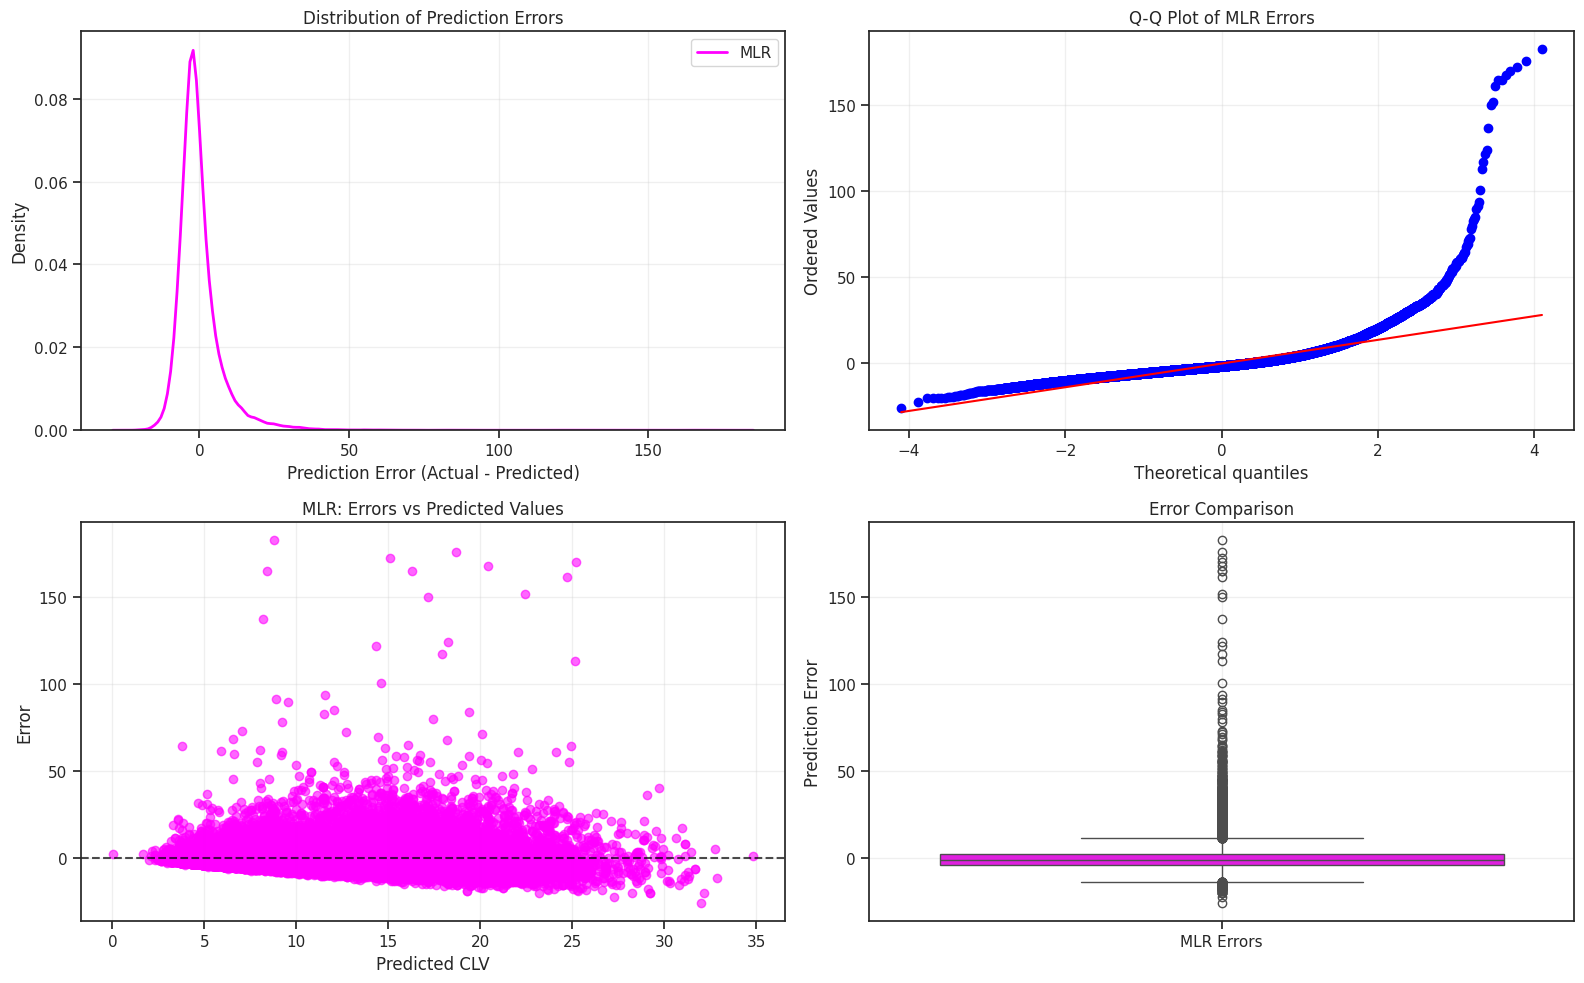

In [ ]:
# Error analysis of mlr_model_3
colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

# Calculate prediction errors
y_pred_mlr_3 = mlr_model_3.predict(valid_pred_3)

lin_errors = valid_pred_3['number_of_delivery_days'] - y_pred_mlr_3

# Create a figure for prediction residule analysis
plt.figure(figsize=(16, 10))

# 1. Error distributions with KDE
plt.subplot(2, 2, 1)
sns.kdeplot(lin_errors, color=colours[4], linewidth=2, label='MLR')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Q-Q plot
plt.subplot(2, 2, 2)
from scipy import stats
fig = stats.probplot(lin_errors, plot=plt, fit=True)
plt.title('Q-Q Plot of MLR Errors')
plt.grid(True, alpha=0.3)

# 3. Errors vs Predicted Values (to check heteroscedasticity)
plt.subplot(2, 2, 3)
plt.scatter(y_pred_mlr_3, lin_errors, alpha=0.6, color=colours[4])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('MLR: Errors vs Predicted Values')
plt.xlabel('Predicted CLV')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)

# 4. Error boxplots for comparison
plt.subplot(2, 2, 4)
error_df = pd.DataFrame({
    'MLR Errors': lin_errors})
sns.boxplot(data=error_df, palette=[colours[4], colours[0]])
plt.title('Error Comparison')
plt.ylabel('Prediction Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### **10.1.3. Regularised Regression**

In [ ]:
from sklearn.preprocessing import StandardScaler
selected_numerical_variables = ['customer_seller_distance_km_capped',
                       'customer_seller_distance_km_capped_squared',
                       'average_seller_process_time_capped',
                       'order_purchase_timestamp_day',
                      'order_purchase_timestamp_month']

# Initialise scaler and fit on training data
scaler = StandardScaler()
train_lin[selected_numerical_variables] = scaler.fit_transform(train_lin[selected_numerical_variables])
valid_lin[selected_numerical_variables] = scaler.transform(valid_lin[selected_numerical_variables])  # Use same scaling

print("Numerical features standardised:", selected_numerical_variables)

✅ Numerical features standardised: ['customer_seller_distance_km_capped', 'customer_seller_distance_km_capped_squared', 'average_seller_process_time_capped', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month']


**Ridge Regression**

In [ ]:
# Ridge
y_train = train_lin['number_of_delivery_days']
y_valid = valid_lin['number_of_delivery_days']

predictors_ridge = selected_numerical_variables + payment_type_encoded_cols + product_category_name_english_encoded_cols + customer_state_encoded_cols + seller_state_encoded_cols

predictors_ridge.remove('seller_state_BA')
predictors_ridge.remove('seller_state_PA')

# We'll generate an array of alpha values ranging from very big to very small
alphas = 10**np.linspace(10,-2,10)*0.5

ridgecv = RidgeCV(alphas = alphas, cv = 10, scoring = 'neg_mean_squared_error')
ridgecv.fit(train_lin[predictors_ridge], y_train)
ridgecv.alpha_

np.float64(2.320794416806396)

In [ ]:
# Make predictions
valid_lin = valid_lin.dropna(subset=['number_of_delivery_days'])
valid_lin = valid_lin.dropna(subset=selected_numerical_variables)
train_lin = train_lin.dropna(subset=['number_of_delivery_days'])
train_lin = train_lin.dropna(subset=selected_numerical_variables)

y_train = train_lin['number_of_delivery_days']
y_valid = valid_lin['number_of_delivery_days']

y_pred_ridge = ridgecv.predict(valid_lin[predictors_ridge])

# Evaluation metrics
mae_ridge = mean_absolute_error(y_valid, y_pred_ridge)
r2_ridge = r2_score(y_valid, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_valid, y_pred_ridge))

print(f"Ridge Regression Performance:")
print(f"RMSE: {rmse_ridge:.3f}")
print(f"MAE: {mae_ridge:.3f}")
print(f"R²: {r2_ridge:.3f}")

Ridge Regression Performance:
RMSE: 8.056
MAE: 4.977
R²: 0.260


**Lasso Regression**

In [ ]:
# Lasso
predictors_lasso = selected_numerical_variables + payment_type_encoded_cols + product_category_name_english_encoded_cols + customer_state_encoded_cols + seller_state_encoded_cols

predictors_lasso.remove('seller_state_BA')
predictors_lasso.remove('seller_state_PA')

alphas = 10**np.linspace(10, -2, 100) * 0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(train_lin[predictors_lasso], y_train)

# Print optimal lambda (alpha) value
print('Optimal lambda value = {}'.format(lassocv.alpha_))

Optimal lambda value = 0.005


In [ ]:
# Select the non-zero coefficeints from lassocv that are in selected_numerical_variables
lasso_coef = pd.Series(lassocv.coef_, index=train_lin[predictors_lasso].columns)
nonzero_lasso_coef = lasso_coef[lasso_coef != 0]
selected_lasso_numerical_variables = nonzero_lasso_coef[nonzero_lasso_coef.index.isin(selected_numerical_variables)].index.tolist()
print("Selected numerical variables from LassoCV with non-zero coefficients:")
selected_lasso_numerical_variables

Selected numerical variables from LassoCV with non-zero coefficients:


['customer_seller_distance_km_capped',
 'customer_seller_distance_km_capped_squared',
 'average_seller_process_time_capped',
 'order_purchase_timestamp_day',
 'order_purchase_timestamp_month']

In [ ]:
# Find any columns that are not common in selected_lasso_numerical_variables and selected_numerical_variables

print("Columns not common in all_predictor_variables_lasso and all_predictor_variables:")
print(list(set(selected_lasso_numerical_variables) ^ set(selected_numerical_variables)))

Columns not common in all_predictor_variables_lasso and all_predictor_variables:
[]


## 10.2. Generalised Additive Models (GAMs)

In [ ]:
train_gams = train.copy()
valid_gams = valid.copy()

### **10.2.1. Regression Spline (Predictors = 1, Degree = 3, Knots = 5)**

In [ ]:
from sklearn.preprocessing import SplineTransformer

# Define variables
feature = 'customer_seller_distance_km_capped'
target  = 'number_of_delivery_days'

# Drop NaNs only
mask_train = train_gams[feature].notna() & train_gams[target].notna()
X_train_gams   = train_gams.loc[mask_train, [feature]].values
y_train_gams   = train_gams.loc[mask_train, target].values

mask_val = valid_gams[feature].notna() & valid_gams[target].notna()
X_val_gams    = valid_gams.loc[mask_val, [feature]].values
y_val_gams    = valid_gams.loc[mask_val, target].values

# Build degree-3 spline with 5 knots
spline = SplineTransformer(n_knots=5, degree=3, knots='uniform', include_bias=False)
X_train_spline_og = spline.fit_transform(X_train_gams)

# Fit linear regression
model_gams_1 = LinearRegression()
model_gams_1.fit(X_train_spline_og, y_train_gams)

# Make predictions on validation set
X_val_spline_og = spline.transform(X_val_gams)
y_pred_val_gams_1   = model_gams_1.predict(X_val_spline_og)

# Evaluate performance
rmse_spline_og = np.sqrt(mean_squared_error(y_val_gams, y_pred_val_gams_1))
mae_spline_og  = mean_absolute_error(y_val_gams, y_pred_val_gams_1)
r2_spline_og = r2_score(y_val_gams, y_pred_val_gams_1)

print(f"Regression Spline (Predictors = 1, Degree = 3, Knots = 5) Performance:")
print(f"RMSE: {rmse_spline_og:.4f}")
print(f"MAE: {mae_spline_og:.4f}")
print(f"R2: {r2_spline_og:.4f}")

Regression Spline (Predictors = 1, Degree = 3, Knots = 5) Performance:
RMSE: 8.5022
MAE: 5.3991
R2: 0.1774


### **10.2.2. Natural Spline (Predictor = 1)**

In [ ]:
from patsy import dmatrix
# Build natural spline basis with 5 degrees of freedom (equiv. to 5 knots)
X_train_spline_natural = dmatrix("cr(x, df=5) - 1", {"x": X_train_gams}, return_type='dataframe')

# Fit linear regression
model_gams_2 = LinearRegression()
model_gams_2.fit(X_train_spline_natural, y_train_gams)

# Transform validation data and predict
X_val_spline_natural = dmatrix("cr(x, df=5) - 1", {"x": X_val_gams}, return_type='dataframe')
y_pred_val_gams_2 = model_gams_2.predict(X_val_spline_natural)

rmse_spline_natural = np.sqrt(mean_squared_error(y_val_gams, y_pred_val_gams_2))
mae_spline_natural = mean_absolute_error(y_val_gams, y_pred_val_gams_2)
r2_spline_natural = r2_score(y_val_gams, y_pred_val_gams_2)

print(f"Natural Spline (df = 5) Performance:")
print(f"RMSE: {rmse_spline_natural:.4f}")
print(f"MAE: {mae_spline_natural:.4f}")
print(f"R2: {r2_spline_natural:.4f}")

Natural Spline (df = 5) Performance:
RMSE: 8.5012
MAE: 5.3944
R2: 0.1776


### **10.2.3. Regression Spline with full predictors**

**Encoding of categorical variables**

In [ ]:
# Dummy encoding payment_type
payment_type_encoded_train_gams = pd.get_dummies(train_gams['payment_type'], prefix='payment_type', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_gams = pd.concat([train_gams.drop('payment_type', axis=1), payment_type_encoded_train_gams], axis=1)

payment_type_encoded_valid_gams = pd.get_dummies(valid_gams['payment_type'], prefix='payment_type', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_gams = pd.concat([valid_gams.drop('payment_type', axis=1), payment_type_encoded_valid_gams], axis=1)

In [ ]:
# Dummy encoding product_category_name_english
product_category_name_english_encoded_train_gams = pd.get_dummies(train_gams['product_category_name_english'], prefix='product_category_name_english', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_gams = pd.concat([train_gams.drop('product_category_name_english', axis=1), product_category_name_english_encoded_train_gams], axis=1)

product_category_name_english_encoded_valid_gams = pd.get_dummies(valid_gams['product_category_name_english'], prefix='product_category_name_english', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_gams = pd.concat([valid_gams.drop('product_category_name_english', axis=1), product_category_name_english_encoded_valid_gams], axis=1)

In [ ]:
# Dummy encoding customer_state
customer_state_encoded_train_gams = pd.get_dummies(train_gams['customer_state'], prefix='customer_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_gams = pd.concat([train_gams.drop('customer_state', axis=1), customer_state_encoded_train_gams], axis=1)

customer_state_encoded_valid_gams = pd.get_dummies(valid_gams['customer_state'], prefix='customer_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_gams = pd.concat([valid_gams.drop('customer_state', axis=1), customer_state_encoded_valid_gams], axis=1)

In [ ]:
# Dummy encoding seller_state
seller_state_encoded_train_gams = pd.get_dummies(train_gams['seller_state'], prefix='seller_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
train_gams = pd.concat([train_gams.drop('seller_state', axis=1), seller_state_encoded_train_gams], axis=1)

seller_state_encoded_valid_gams = pd.get_dummies(valid_gams['seller_state'], prefix='seller_state', drop_first=True)
# Concatenate the dummy variables and drop the original column
valid_gams = pd.concat([valid_gams.drop('seller_state', axis=1), seller_state_encoded_valid_gams], axis=1)

**Numerical features**

In [ ]:
# from Backward Selection
selected_numerical_variables = ['customer_seller_distance_km_capped',
              'average_seller_process_time_capped',
              'order_quantity',
              'average_delivery_time_by_product',
              'price',
              'freight_value',
              'payment_value',
              'product_weight_g',
              'payment_installments',
              'payment_sequential',
              'product_photos_qty',
              'product_description_length',
              'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
              'shipping_limit_date_hour', 'shipping_limit_date_month']

In [ ]:
payment_type_encoded_cols = payment_type_encoded_train_gams.columns.tolist()
product_category_name_english_encoded_cols = product_category_name_english_encoded_train_gams.columns.tolist()
customer_state_encoded_cols = customer_state_encoded_train_gams.columns.tolist()
seller_state_encoded_cols = seller_state_encoded_train_gams.columns.tolist()
all_predictor_variables_gams = selected_numerical_variables + payment_type_encoded_cols + product_category_name_english_encoded_cols + customer_state_encoded_cols + seller_state_encoded_cols

# drop seller_state_BA in all_predictor_variables
all_predictor_variables_gams.remove('seller_state_BA')
all_predictor_variables_gams.remove('seller_state_PA')

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer

target = 'number_of_delivery_days'
spline_features = ['customer_seller_distance_km_capped', 'average_seller_process_time_capped', 'order_quantity',
                   'price', 'freight_value', 'payment_value', 'product_weight_g',
                   'payment_installments', 'payment_sequential', 'product_photos_qty', 'product_description_length',
                                 'order_purchase_timestamp_hour', 'order_purchase_timestamp_day', 'order_purchase_timestamp_month',
              'shipping_limit_date_hour', 'shipping_limit_date_month']

# These features are likely to benefit from spline transformations

linear_features = list(set(all_predictor_variables_gams) - set(spline_features))

# Prepare Training and Validation Data
X_train = train_gams[all_predictor_variables_gams].copy()
y_train = train_gams[target].copy()
X_val = valid_gams[all_predictor_variables_gams].copy()
y_val = valid_gams[target].copy()

# Drop rows with missing values in train/val
train_mask = X_train.notna().all(axis=1) & y_train.notna()
val_mask = X_val.notna().all(axis=1) & y_val.notna()
X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_val = X_val[val_mask]
y_val = y_val[val_mask]

# Define Preprocessing for Columns
preprocessor = ColumnTransformer(
    transformers=[
        ('spline', SplineTransformer(n_knots=4, degree=1, include_bias=False), spline_features),
        ('linear', 'passthrough', linear_features),
    ]
)

# Define Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),  # optional but often helpful
    ('regressor', LinearRegression())
])

# Fit Model
pipeline.fit(X_train, y_train)

# Predict on Validation
y_pred = pipeline.predict(X_val)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Regession spline with full predictors Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R2 : {r2:.4f}")

Validation RMSE: 8.3376
Validation MAE : 5.0998
Validation R2 : 0.2137


### **10.2.4. Natural Spline with full predictors**



*   **Baseline natural spline model**



In [ ]:
from patsy import dmatrix

target = 'number_of_delivery_days'

# Define categorical dummies (already encoded)
categorical_encoded_cols = payment_type_encoded_cols + product_category_name_english_encoded_cols + customer_state_encoded_cols + seller_state_encoded_cols

# Identify numeric features from training set
numeric_features = train_gams[spline_features].select_dtypes(include=np.number).columns.tolist()

# Features for natural spline transformation (numerical and non-dummy)
natural_spline_features = list(set(numeric_features) - set(categorical_encoded_cols))

linear_features = list(set(all_predictor_variables_gams) - set(natural_spline_features))

# Prepare raw data
X_train_raw = train_gams[all_predictor_variables_gams].copy()
y_train = train_gams[target].copy()
X_val_raw = valid_gams[all_predictor_variables_gams].copy()
y_val = valid_gams[target].copy()

# Drop missing values
train_mask = X_train_raw.notna().all(axis=1) & y_train.notna()
val_mask = X_val_raw.notna().all(axis=1) & y_val.notna()

X_train_raw = X_train_raw[train_mask]
y_train = y_train[train_mask]
X_val_raw = X_val_raw[val_mask]
y_val = y_val[val_mask]

# Build natural spline basis with df=5
def make_cr_basis(df, features, df_spline=5):
    out = []
    for feat in features:
        basis = dmatrix(f"cr({feat}, df={df_spline}) - 1", data=df, return_type='dataframe')
        basis.columns = [f"{feat}_cr{i}" for i in range(basis.shape[1])]
        out.append(basis)
    return pd.concat(out, axis=1)

X_train_spline = make_cr_basis(X_train_raw, spline_features)
X_val_spline = make_cr_basis(X_val_raw, spline_features)

# Linear passthrough features
X_train_linear = X_train_raw[linear_features].reset_index(drop=True)
X_val_linear = X_val_raw[linear_features].reset_index(drop=True)

# Combine all features
X_train_final = pd.concat([X_train_spline.reset_index(drop=True), X_train_linear], axis=1)
X_val_final = pd.concat([X_val_spline.reset_index(drop=True), X_val_linear], axis=1)

# Scale and fit model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val_final)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_val_scaled)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Natural Spline with full predictors Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

Validation RMSE (natural spline, df=5): 8.3031
Validation MAE  (natural spline, df=5): 5.0868
Validation R2  (natural spline, df=5): 0.2202




*   **Hyperparameter tuning of natural spline model**



In [ ]:
!pip install pygam==0.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.4 MB/s eta 0:00:00


In [ ]:
import scipy.sparse

def to_array(self):
    return self.toarray()

scipy.sparse.spmatrix.A = property(to_array)

In [ ]:
import numpy as np
if not hasattr(np, 'int'):
    np.int = int

import optuna
from pygam import LinearGAM, s, l
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from functools import reduce
from operator import add

# Define predictors

categorical_encoded_cols = (
    payment_type_encoded_cols +
    product_category_name_english_encoded_cols +
    customer_state_encoded_cols +
    seller_state_encoded_cols
)

numeric_features = train_gams[all_predictor_variables_gams].select_dtypes(include=np.number).columns.tolist()

spline_features = list(set(numeric_features) - set(categorical_encoded_cols))
linear_features = list(set(all_predictor_variables_gams) - set(spline_features))
ordered_features = spline_features + linear_features

# Training and validation data

X_train = train_gams[ordered_features].copy()
y_train = train_gams['number_of_delivery_days'].copy()
train_mask = X_train.notna().all(axis=1) & y_train.notna()
X_train = X_train[train_mask].to_numpy()
y_train = y_train[train_mask].to_numpy()

X_val = valid_gams[ordered_features].copy()
y_val = valid_gams['number_of_delivery_days'].copy()
val_mask = X_val.notna().all(axis=1) & y_val.notna()
X_val = X_val[val_mask].to_numpy()
y_val = y_val[val_mask].to_numpy()

# Define Optuna objective function

def gam_objective(trial):
    lambda_splines = [trial.suggest_float(f'lambda_spline_{i}', 1e-4, 1e4, log=True)
                      for i in range(len(spline_features))]
    lambda_linear = trial.suggest_float('lambda_linear', 1e-4, 1e4, log=True)
    lambdas = lambda_splines + [lambda_linear] * len(linear_features)

    spline_terms = [s(i) for i in range(len(spline_features))]
    linear_terms = [l(i) for i in range(len(spline_features), len(ordered_features))]
    terms = reduce(add, spline_terms + linear_terms)

    model = LinearGAM(terms, lam=lambdas)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    print(f"Trial Metrics → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return rmse  # optimize on RMSE

# Run Optuna study

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(gam_objective, n_trials=100, timeout=300)

print("\nBest RMSE:", study.best_value)
print("Best Params:", study.best_params)

# STrain final optimized GAM on training data

best_lambdas = list(study.best_params.values())
lambda_splines = best_lambdas[:-1]
lambda_linear = best_lambdas[-1]
final_lambdas = lambda_splines + [lambda_linear] * len(linear_features)

spline_terms = [s(i) for i in range(len(spline_features))]
linear_terms = [l(i) for i in range(len(spline_features), len(ordered_features))]
terms = reduce(add, spline_terms + linear_terms)

optimized_gam = LinearGAM(terms, lam=final_lambdas)
optimized_gam.fit(X_train, y_train)

# Step 6: Evaluate final model on validation set

y_pred_val = optimized_gam.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Natural Spline with full predictors Performance:")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE : {mae_val:.4f}")
print(f"R²  : {r2_val:.4f}")

[I 2025-05-30 04:11:55,436] A new study created in memory with name: no-name-3d20ae30-b0cb-4ecf-abf7-e05b713a1023
[I 2025-05-30 04:13:03,707] Trial 0 finished with value: 8.251125904810687 and parameters: {'lambda_spline_0': 0.09915644566638401, 'lambda_spline_1': 4033.8008326003933, 'lambda_spline_2': 71.77141927992021, 'lambda_spline_3': 6.155564318973028, 'lambda_spline_4': 0.0017707168643537846, 'lambda_spline_5': 0.0017699302940633358, 'lambda_spline_6': 0.00029152036385288323, 'lambda_spline_7': 849.9808989183019, 'lambda_spline_8': 6.4405075539937195, 'lambda_spline_9': 46.19347374377384, 'lambda_spline_10': 0.00014610865886287216, 'lambda_spline_11': 5744.851636320435, 'lambda_spline_12': 456.6054873446131, 'lambda_spline_13': 0.004997040685255816, 'lambda_spline_14': 0.002848391870910803, 'lambda_spline_15': 0.0029324868872723803, 'lambda_spline_16': 0.027160511446548512, 'lambda_linear': 1.5777981883365035}. Best is trial 0 with value: 8.251125904810687.


Trial Metrics → RMSE: 8.2511, MAE: 4.9143, R²: 0.2299


[I 2025-05-30 04:13:34,163] Trial 1 finished with value: 8.239875238631845 and parameters: {'lambda_spline_0': 0.2854697857797185, 'lambda_spline_1': 0.02137140731637301, 'lambda_spline_2': 7.849159562555091, 'lambda_spline_3': 0.001306023180353164, 'lambda_spline_4': 0.02173487707341741, 'lambda_spline_5': 0.08528933855762823, 'lambda_spline_6': 0.4452048365748854, 'lambda_spline_7': 191.16469627784303, 'lambda_spline_8': 0.0039572205641009274, 'lambda_spline_9': 1.2997969313168272, 'lambda_spline_10': 5.486767416600916, 'lambda_spline_11': 0.00023528990899815348, 'lambda_spline_12': 7.250347382396653, 'lambda_spline_13': 0.0023130924416844114, 'lambda_spline_14': 0.0003314459707751232, 'lambda_spline_15': 3900.1768308022133, 'lambda_spline_16': 5309.5322690092235, 'lambda_linear': 293.21000471832986}. Best is trial 1 with value: 8.239875238631845.


Trial Metrics → RMSE: 8.2399, MAE: 4.9856, R²: 0.2320


[I 2025-05-30 04:14:05,112] Trial 2 finished with value: 8.333422319775092 and parameters: {'lambda_spline_0': 0.02734702913886812, 'lambda_spline_1': 0.0006044730070370807, 'lambda_spline_2': 29.775853025212687, 'lambda_spline_3': 0.3320625892007933, 'lambda_spline_4': 0.000946903842177445, 'lambda_spline_5': 0.9149877525022196, 'lambda_spline_6': 0.00018841183049085134, 'lambda_spline_7': 1881.755597772031, 'lambda_spline_8': 0.011755466083160767, 'lambda_spline_9': 19.960815242513796, 'lambda_spline_10': 0.031166541263980527, 'lambda_spline_11': 1.4472520367197634, 'lambda_spline_12': 2.364189230878976, 'lambda_spline_13': 0.0030118659882617197, 'lambda_spline_14': 5710.5379511268075, 'lambda_spline_15': 158.87756931672592, 'lambda_spline_16': 3280.888962660632, 'lambda_linear': 1440.8501080722583}. Best is trial 1 with value: 8.239875238631845.


Trial Metrics → RMSE: 8.3334, MAE: 5.0078, R²: 0.2145


[I 2025-05-30 04:14:36,366] Trial 3 finished with value: 8.207146900443307 and parameters: {'lambda_spline_0': 6.0701556941418096, 'lambda_spline_1': 2371.340289933656, 'lambda_spline_2': 0.0005104344952682508, 'lambda_spline_3': 0.003697114486625516, 'lambda_spline_4': 0.0002300479202014584, 'lambda_spline_5': 0.04005370050283179, 'lambda_spline_6': 0.12865252594826798, 'lambda_spline_7': 0.014818090886467109, 'lambda_spline_8': 426.4813784432929, 'lambda_spline_9': 0.0714540111723761, 'lambda_spline_10': 0.017679748286442643, 'lambda_spline_11': 2.1956780751275677, 'lambda_spline_12': 0.0013408920002835425, 'lambda_spline_13': 261.56272064707497, 'lambda_spline_14': 0.00039482545946332466, 'lambda_spline_15': 7854.083114461339, 'lambda_spline_16': 150.64619068942054, 'lambda_linear': 0.003887992802407561}. Best is trial 3 with value: 8.207146900443307.


Trial Metrics → RMSE: 8.2071, MAE: 4.9055, R²: 0.2381


[I 2025-05-30 04:15:10,129] Trial 4 finished with value: 8.210665097908576 and parameters: {'lambda_spline_0': 0.00011070747281639221, 'lambda_spline_1': 333.9576740674947, 'lambda_spline_2': 45.170900739091465, 'lambda_spline_3': 67.92933207180882, 'lambda_spline_4': 147.96628616069324, 'lambda_spline_5': 0.00039116250066838345, 'lambda_spline_6': 0.07374385355858322, 'lambda_spline_7': 0.0008451863533931648, 'lambda_spline_8': 803.2068562667243, 'lambda_spline_9': 9.691366432023926, 'lambda_spline_10': 0.044379683310623495, 'lambda_spline_11': 0.00032245328248123556, 'lambda_spline_12': 0.030750952591044503, 'lambda_spline_13': 0.03994538177154865, 'lambda_spline_14': 68.68302692995739, 'lambda_spline_15': 12.602588933700142, 'lambda_spline_16': 1252.281430305366, 'lambda_linear': 0.5994036749692414}. Best is trial 3 with value: 8.207146900443307.


Trial Metrics → RMSE: 8.2107, MAE: 4.9353, R²: 0.2374


[I 2025-05-30 04:15:38,598] Trial 5 finished with value: 8.21289368627531 and parameters: {'lambda_spline_0': 0.0009052196389541902, 'lambda_spline_1': 50.811064995935865, 'lambda_spline_2': 121.97768563438403, 'lambda_spline_3': 3.091844051450655, 'lambda_spline_4': 147.14226590398798, 'lambda_spline_5': 0.8919998285789841, 'lambda_spline_6': 1.5200666650051613, 'lambda_spline_7': 0.2632256136809146, 'lambda_spline_8': 0.00015971768764426244, 'lambda_spline_9': 0.0007296782748701785, 'lambda_spline_10': 0.00017841587142327403, 'lambda_spline_11': 12.339094493965549, 'lambda_spline_12': 0.03272260339283022, 'lambda_spline_13': 1.1710232809812855, 'lambda_spline_14': 1821.9304379346577, 'lambda_spline_15': 0.009870470007366716, 'lambda_spline_16': 0.19189487864144905, 'lambda_linear': 110.76667222301116}. Best is trial 3 with value: 8.207146900443307.


Trial Metrics → RMSE: 8.2129, MAE: 4.8998, R²: 0.2370


[I 2025-05-30 04:16:15,225] Trial 6 finished with value: 8.20955904200691 and parameters: {'lambda_spline_0': 0.006766830902084547, 'lambda_spline_1': 0.00041289467186975294, 'lambda_spline_2': 0.020797523481449698, 'lambda_spline_3': 0.0019488135833929646, 'lambda_spline_4': 2738.9318023929804, 'lambda_spline_5': 291.7178717777821, 'lambda_spline_6': 11.674278567621291, 'lambda_spline_7': 936.8816255577204, 'lambda_spline_8': 268.7674155561062, 'lambda_spline_9': 0.0031085687091743953, 'lambda_spline_10': 1381.885271152788, 'lambda_spline_11': 2.064134227234294, 'lambda_spline_12': 288.08539486929266, 'lambda_spline_13': 1474.7907308930864, 'lambda_spline_14': 0.034996756820693704, 'lambda_spline_15': 0.0007593034903208885, 'lambda_spline_16': 0.006660108438734098, 'lambda_linear': 0.2611333312395902}. Best is trial 3 with value: 8.207146900443307.


Trial Metrics → RMSE: 8.2096, MAE: 4.9014, R²: 0.2376


[I 2025-05-30 04:16:49,723] Trial 7 finished with value: 8.217029130364526 and parameters: {'lambda_spline_0': 350.0403644805157, 'lambda_spline_1': 768.8553948726385, 'lambda_spline_2': 0.00011366245816554806, 'lambda_spline_3': 1.2189290308386742, 'lambda_spline_4': 0.21841779839274014, 'lambda_spline_5': 0.005982221423148767, 'lambda_spline_6': 0.0009097518316981085, 'lambda_spline_7': 0.05022516489125325, 'lambda_spline_8': 3493.635816569525, 'lambda_spline_9': 0.03851442834399526, 'lambda_spline_10': 1.41359491400579, 'lambda_spline_11': 42.08735868263735, 'lambda_spline_12': 0.0811029813203095, 'lambda_spline_13': 5946.434805027199, 'lambda_spline_14': 5007.0088559040905, 'lambda_spline_15': 0.010333759897666469, 'lambda_spline_16': 0.9505786310154973, 'lambda_linear': 0.025528569432507565}. Best is trial 3 with value: 8.207146900443307.


Trial Metrics → RMSE: 8.2170, MAE: 4.9040, R²: 0.2363


[I 2025-05-30 04:17:21,214] Trial 8 finished with value: 8.20329526841188 and parameters: {'lambda_spline_0': 0.018998703060878204, 'lambda_spline_1': 0.0001972856871531974, 'lambda_spline_2': 7.525141520487923, 'lambda_spline_3': 1.0505873950469633, 'lambda_spline_4': 0.00025812496493273694, 'lambda_spline_5': 0.016950078500941473, 'lambda_spline_6': 1845.5554056364172, 'lambda_spline_7': 0.00825078224477254, 'lambda_spline_8': 0.0014426433452224832, 'lambda_spline_9': 0.8234212719816322, 'lambda_spline_10': 7677.213757517439, 'lambda_spline_11': 0.008638576272048783, 'lambda_spline_12': 23.827823761203792, 'lambda_spline_13': 123.86737172447361, 'lambda_spline_14': 0.007963433393223609, 'lambda_spline_15': 66.94694890310828, 'lambda_spline_16': 0.08755179646617169, 'lambda_linear': 11.44054318382192}. Best is trial 8 with value: 8.20329526841188.


Trial Metrics → RMSE: 8.2033, MAE: 4.8930, R²: 0.2388

🎯 Best RMSE: 8.20329526841188
📌 Best Params: {'lambda_spline_0': 0.018998703060878204, 'lambda_spline_1': 0.0001972856871531974, 'lambda_spline_2': 7.525141520487923, 'lambda_spline_3': 1.0505873950469633, 'lambda_spline_4': 0.00025812496493273694, 'lambda_spline_5': 0.016950078500941473, 'lambda_spline_6': 1845.5554056364172, 'lambda_spline_7': 0.00825078224477254, 'lambda_spline_8': 0.0014426433452224832, 'lambda_spline_9': 0.8234212719816322, 'lambda_spline_10': 7677.213757517439, 'lambda_spline_11': 0.008638576272048783, 'lambda_spline_12': 23.827823761203792, 'lambda_spline_13': 123.86737172447361, 'lambda_spline_14': 0.007963433393223609, 'lambda_spline_15': 66.94694890310828, 'lambda_spline_16': 0.08755179646617169, 'lambda_linear': 11.44054318382192}

✅ Final Validation Metrics:
📉 RMSE: 8.2033
📈 MAE : 4.8930
📊 R²  : 0.2388


**Error Analysis**

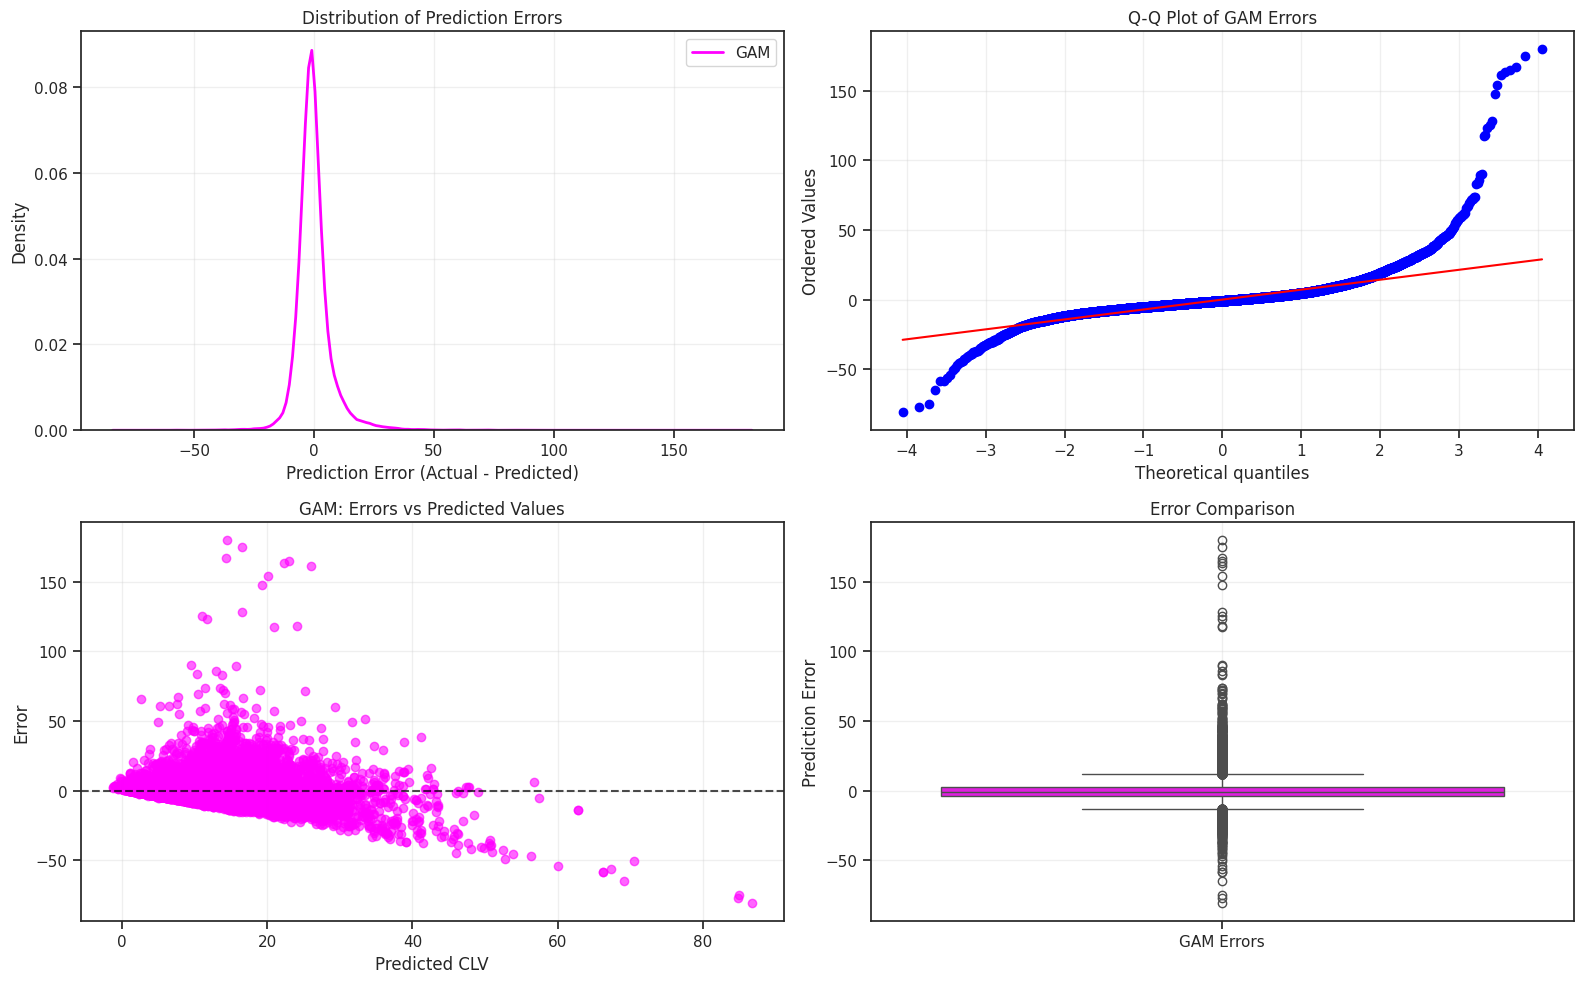

In [ ]:
colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

# Calculate prediction errors
y_pred_gam = optimized_gam.predict(X_val)

gam_errors = y_val - y_pred_val

# Create a figure for prediction residula analysis
plt.figure(figsize=(16, 10))

# 1. Error distributions with KDE
plt.subplot(2, 2, 1)
sns.kdeplot(gam_errors, color=colours[4], linewidth=2, label='GAM')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Q-Q plot
plt.subplot(2, 2, 2)
from scipy import stats
fig = stats.probplot(gam_errors, plot=plt, fit=True)
plt.title('Q-Q Plot of GAM Errors')
plt.grid(True, alpha=0.3)

# 3. Errors vs Predicted Values (to check heteroscedasticity)
plt.subplot(2, 2, 3)
plt.scatter(y_pred_gam, gam_errors, alpha=0.6, color=colours[4])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('GAM: Errors vs Predicted Values')
plt.xlabel('Predicted CLV')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)

# 4. Error boxplots for comparison
plt.subplot(2, 2, 4)
error_df = pd.DataFrame({
    'GAM Errors': gam_errors})
sns.boxplot(data=error_df, palette=[colours[4], colours[0]])
plt.title('Error Comparison')
plt.ylabel('Prediction Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10.3. Random Forests

**Random Forest Predictors and Set-Up**

* Excluding `customer_city` and `seller_city`

In [ ]:
train_rf = train.copy()
valid_rf = valid.copy()

In [ ]:
predictors_rf = ['customer_seller_distance_km',
              'product_size',
              'average_seller_process_time',
              'order_quantity',
              'average_delivery_time_by_product',
              'price',
              'freight_value',
              'payment_value',
              'product_weight_g',
              'payment_installments',
              'payment_sequential',
              'product_name_length',
              'product_photos_qty',
              'product_description_length',
              'order_purchase_timestamp_month',
              'shipping_limit_date_month']

In [ ]:
categorical_features_rf = ['customer_state',
                        'seller_state',
                        'product_category_name_english',
                        'payment_type']

In [ ]:
# One Hot encoding payment_type
payment_type_encoded_train_rf = pd.get_dummies(train_rf['payment_type'], prefix='payment_type')
payment_type_encoded_valid_rf = pd.get_dummies(valid_rf['payment_type'], prefix='payment_type')

In [ ]:
# One Hot encoding product_category_name_english
product_category_name_english_encoded_train_rf = pd.get_dummies(train_rf['product_category_name_english'], prefix='product_category_name_english')
product_category_name_english_encoded_valid_rf = pd.get_dummies(valid_rf['product_category_name_english'], prefix='product_category_name_english')

In [ ]:
# One Hot encoding customer_state
customer_state_encoded_train_rf = pd.get_dummies(train_rf['customer_state'], prefix='customer_state')
customer_state_encoded_valid_rf = pd.get_dummies(valid_rf['customer_state'], prefix='customer_state')

In [ ]:
# One Hot encoding seller_state
seller_state_encoded_train_rf = pd.get_dummies(train_rf['seller_state'], prefix='seller_state')
seller_state_encoded_valid_rf = pd.get_dummies(valid_rf['seller_state'], prefix='seller_state')

**Initial Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train_rf = pd.concat([
    train_rf[predictors_rf],
    payment_type_encoded_train_rf,
    product_category_name_english_encoded_train_rf,
    customer_state_encoded_train_rf,
    seller_state_encoded_train_rf
], axis=1)


X_valid_rf = pd.concat([
    valid_rf[predictors_rf],
    payment_type_encoded_valid_rf,
    product_category_name_english_encoded_valid_rf,
    customer_state_encoded_valid_rf,
    seller_state_encoded_valid_rf
], axis=1)

y = train_rf[target]

rfr =  RandomForestRegressor(n_estimators=100,  criterion='squared_error',  max_features = 5, min_samples_leaf= 5)
rfr.fit(X_train_rf, y)

RandomForestRegressor(max_features=5, min_samples_leaf=5)

In [ ]:
# Align columns
X_valid_rf = X_valid_rf.reindex(columns=X_train_rf.columns, fill_value=0)

# Make predictions on validation data
y_pred = rfr.predict(X_valid_rf)

# Evaluation metrics
mae_rf = mean_absolute_error(valid_rf[target], y_pred)
r2_rf = r2_score(valid_rf[target], y_pred)
rmse_rf = np.sqrt(mean_squared_error(valid_rf[target], y_pred))

print(f"Initial Random Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"R²: {r2_rf:.4f}")

Initial Random Forest Performance:
RMSE: 7.7552
MAE: 4.7001
R²: 0.3156


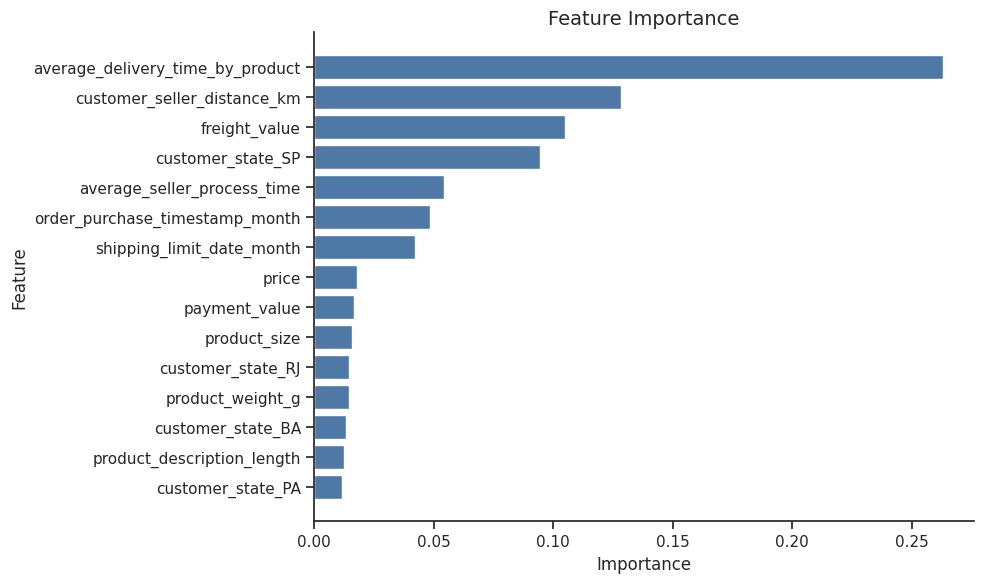

In [ ]:
def plot_feature_importance(model, feature_names, top_n=15):

    # Get feature importances
    importances = rfr.feature_importances_

    # Create DataFrame for better handling
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    feat_imp = feat_imp.sort_values('Importance', ascending=False)

    # Select top N features
    if len(feat_imp) > top_n:
        feat_imp = feat_imp.iloc[:top_n]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='#4E79A7')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance', fontsize=14)
    plt.gca().invert_yaxis()  # Display highest importance at the top
    plt.tight_layout()
    sns.despine()

    return feat_imp

plot_feature_importance(rfr, X_train_rf.columns)
plt.show()

**Optimised Random Forest**

In [ ]:
!pip install optuna
import optuna
from optuna.samplers import TPESampler

In [ ]:
X_train_rf = pd.concat([
    train_rf[predictors_rf],
    payment_type_encoded_train_rf,
    product_category_name_english_encoded_train_rf,
    customer_state_encoded_train_rf,
    seller_state_encoded_train_rf
], axis=1)

y = train_rf[target]

# Define objective with fixed n_estimators
def objective(trial):
    model = RandomForestRegressor(
        n_estimators=100,  # 🔒 Fixed to 100
        max_depth=trial.suggest_int('max_depth', 1, 15),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 5, 10),
        max_features=trial.suggest_int('max_features', 3, 15),
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(model, X_train_rf, y, cv=3, scoring='neg_mean_absolute_error')
    return -score.mean()

# Create and run the study using TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2025-05-30 04:18:36,149] A new study created in memory with name: no-name-9ddb1db7-ee12-41fa-8cc6-a07fc1ec6f1e


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-05-30 04:18:55,101] Trial 0 finished with value: 4.789748937152171 and parameters: {'max_depth': 6, 'min_samples_leaf': 10, 'max_features': 12}. Best is trial 0 with value: 4.789748937152171.
[I 2025-05-30 04:19:13,400] Trial 1 finished with value: 5.06629453872691 and parameters: {'max_depth': 9, 'min_samples_leaf': 5, 'max_features': 5}. Best is trial 0 with value: 4.789748937152171.
[I 2025-05-30 04:19:18,063] Trial 2 finished with value: 6.042394579727226 and parameters: {'max_depth': 1, 'min_samples_leaf': 10, 'max_features': 10}. Best is trial 0 with value: 4.789748937152171.
[I 2025-05-30 04:19:53,312] Trial 3 finished with value: 4.088702199598514 and parameters: {'max_depth': 11, 'min_samples_leaf': 5, 'max_features': 15}. Best is trial 3 with value: 4.088702199598514.
[I 2025-05-30 04:20:05,222] Trial 4 finished with value: 4.774741295154726 and parameters: {'max_depth': 13, 'min_samples_leaf': 6, 'max_features': 5}. Best is trial 3 with value: 4.088702199598514.
[I 2

In [ ]:
print("Best MAE:", study.best_value)
print("Best Parameters:", study.best_trial.params)

Best MAE: 3.8860665457636934
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'max_features': 15}


In [ ]:
# Retrieve best parameters
best_params = study.best_trial.params

# Train the model with best params
final_rf = RandomForestRegressor(
    n_estimators=100,  # same as during tuning
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train_rf, y)

RandomForestRegressor(max_depth=15, max_features=15, min_samples_leaf=5,
                      n_jobs=-1, random_state=42)

In [ ]:
X_valid_rf = pd.concat([
    valid_rf[predictors_rf],
    payment_type_encoded_valid_rf,
    product_category_name_english_encoded_valid_rf,
    customer_state_encoded_valid_rf,
    seller_state_encoded_valid_rf
], axis=1)

# Align columns
X_valid_rf = X_valid_rf.reindex(columns=X_train_rf.columns, fill_value=0)

# Make predictions on validation data
y_pred = final_rf.predict(X_valid_rf)

# Calculate MAE and RMSE
mae = mean_absolute_error(valid_rf[target], y_pred)
rmse = np.sqrt(mean_squared_error(valid_rf[target], y_pred))
r2 = r2_score(valid_rf[target], y_pred)

# Print results
print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R2: {r2:4f}")

Validation MAE: 4.5558
Validation RMSE: 7.6889
Validation R2: 0.327236


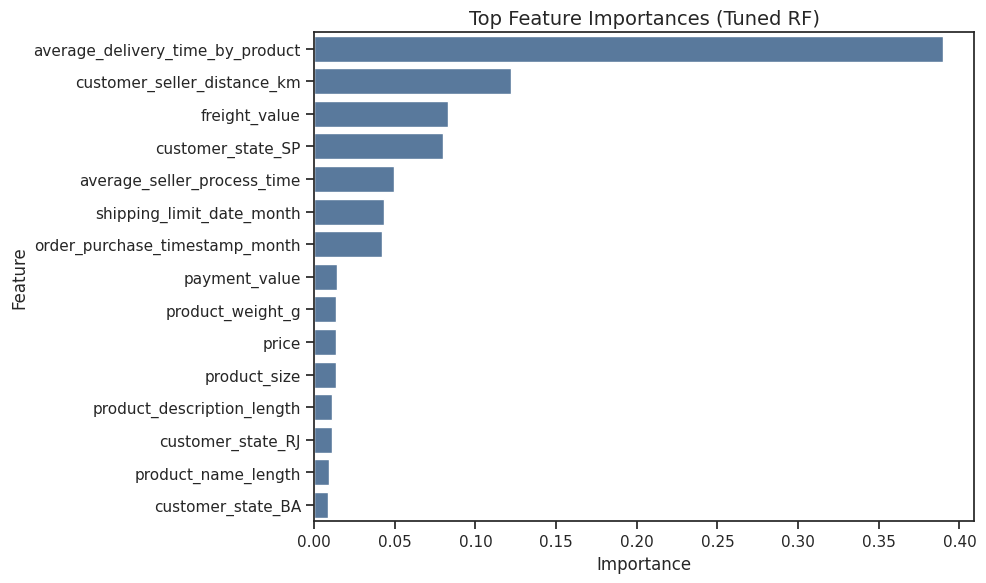

In [ ]:
# Extract and sort feature importances
feat_imp = pd.DataFrame({
    'Feature': X_valid_rf.columns,
    'Importance': final_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top N important features
top_n = 15
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp.head(top_n), x='Importance', y='Feature', color='#4E79A7')
plt.title('Top Feature Importances (Tuned RF)', fontsize=14)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 10.4. Gradient Boosting

### **10.4.1. XGBoost**

📊 **Version 1: XGBoost**

* Start with considering numerical variables.

In [ ]:
train_xgb = train.copy()
valid_xgb = valid.copy()

target_xgb = ['number_of_delivery_days']

predictors_xgb = ['freight_value',
                  'customer_seller_distance_km',
                  'average_seller_process_time',
                  'order_quantity',
                  'order_purchase_timestamp_month',
                  'order_approved_at_month',
                  'order_delivered_carrier_date_month',
                  'shipping_limit_date_month']

X_train = train_xgb.loc[:, predictors_xgb].copy()
Y_train = train_xgb[target_xgb].copy()

X_valid = valid_xgb.loc[:, predictors_xgb].copy()
Y_valid = valid_xgb[target_xgb].copy()

In [ ]:
import xgboost as xgb

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01,
    max_depth=6,              # XGBoost uses max_depth instead of num_leaves
    n_estimators=2000,
    subsample=0.8,            # Similar to bagging_fraction in LightGBM
    colsample_bytree=0.8,     # Similar to feature_fraction in LightGBM
    reg_lambda=1.0,           # L2 regularization
    reg_alpha=0.0,            # L1 regularization
    min_child_weight=1,       # Similar to min_data_in_leaf in LightGBM
    early_stopping_rounds=100
)

# Train the model
xgb_model.fit(
    X_train,
    Y_train,
    eval_set=[(X_valid, Y_valid)],

    verbose=False
)

# Make predictions
y_pred_xgb = xgb_model.predict(X_valid)


# Evaluate performance
rmse_xg = np.sqrt(mean_squared_error(Y_valid, y_pred_xgb))
mae_xg = mean_absolute_error(Y_valid, y_pred_xgb)
r2_xg = r2_score(Y_valid, y_pred_xgb)

print(f"XGBoost Performance:")
print(f"RMSE: {rmse_xg:.3f}")
print(f"MAE: {mae_xg:.3f}")
print(f"R²: {r2_xg:.3f}")

XGBoost Performance:
RMSE: 7.762
MAE: 4.705
R²: 0.314


### **10.4.2. CatBoost**

📊 **Version 1: CatBoost**

* Using default settings
* Using MAE as the loss function.
* Include categorical variables
    * Advanced categorical handling: CatBoost automatically encodes listed categorical variables.
* Will also now consider variables with high cardinality because Catboost can effectively handle high cardinality by utilising ordered target encoding. This includes `customer_city` and `seller_city`.
* Tree based methods are generally not affected by outliers.

In [ ]:
train_catboost = train.copy()
valid_catboost = valid.copy()

In [ ]:
target_catboost = ['number_of_delivery_days']

predictors_catboost = ['freight_value',
                       'customer_seller_distance_km',
                       'average_seller_process_time',
                       'seller_shipping_delay',
                       'customer_city',
                       'customer_state',
                       'seller_city',
                       'seller_state',
                       'payment_type',
                       'order_quantity',
                       'order_purchase_timestamp_month',
                       'order_approved_at_month',
                       'order_delivered_carrier_date_month',
                       'shipping_limit_date_month']

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

# Define the list of categorical features that are in the predictors list
categorical_features = ['customer_city',
                        'customer_state',
                        'seller_city',
                        'seller_state',
                        'payment_type']

# Initialise CatBoost regressor with default parameters
cb_model = CatBoostRegressor(loss_function='MAE', verbose=0)

# Train the model
cb_model.fit(
    train_catboost[predictors_catboost],
    train_catboost[target_catboost],
    cat_features=[predictors_catboost.index(col) for col in categorical_features if col in predictors_catboost],
    eval_set=(valid_catboost[predictors_catboost], valid_catboost[target_catboost]),
    early_stopping_rounds=100,
    verbose=False
)

# Make predictions using validation data
y_pred_default_cb = cb_model.predict(valid_catboost[predictors_catboost])

# Evaluate performance
rmse_default_cb = np.sqrt(mean_squared_error(valid_catboost[target_catboost], y_pred_default_cb))
mae_default_cb = mean_absolute_error(valid_catboost[target_catboost], y_pred_default_cb)
r2_default_cb = r2_score(valid_catboost[target_catboost], y_pred_default_cb)

print(f"CatBoost Performance:")
print(f"RMSE: {rmse_default_cb:.3f}")
print(f"MAE: {mae_default_cb:.3f}")
print(f"R²: {r2_default_cb:.3f}")
# Define the list of categorical features that are in the predictors list
categorical_features = ['customer_city',
                        'customer_state',
                        'seller_city',
                        'seller_state',
                        'payment_type']

# Initialise CatBoost regressor with default parameters
cb_model = CatBoostRegressor(loss_function='MAE', verbose=0)

# Train the model
cb_model.fit(
    train_catboost[predictors_catboost],
    train_catboost[target_catboost],
    cat_features=[predictors_catboost.index(col) for col in categorical_features if col in predictors_catboost],
    eval_set=(valid_catboost[predictors_catboost], valid_catboost[target_catboost]),
    early_stopping_rounds=100,
    verbose=False
)

# Make predictions using validation data
y_pred_default_cb = cb_model.predict(valid_catboost[predictors_catboost])

# Evaluate performance
rmse_default_cb = np.sqrt(mean_squared_error(valid_catboost[target_catboost], y_pred_default_cb))
mae_default_cb = mean_absolute_error(valid_catboost[target_catboost], y_pred_default_cb)
r2_default_cb = r2_score(valid_catboost[target_catboost], y_pred_default_cb)

print(f"CatBoost Performance:")
print(f"RMSE: {rmse_default_cb:.3f}")
print(f"MAE: {mae_default_cb:.3f}")
print(f"R²: {r2_default_cb:.3f}")

CatBoost Performance:
RMSE: 7.274
MAE: 3.916
R²: 0.398
CatBoost Performance:
RMSE: 7.274
MAE: 3.916
R²: 0.398


In [ ]:
# Feature importance of cb_model
feature_importance = pd.DataFrame({
    'Feature': predictors_catboost,
    'Importance': cb_model.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

                               Feature  Importance
3                seller_shipping_delay   21.484440
1          customer_seller_distance_km   15.654442
5                       customer_state   13.950939
2          average_seller_process_time   10.670251
13           shipping_limit_date_month    5.728472
12  order_delivered_carrier_date_month    5.610219
10      order_purchase_timestamp_month    5.412473
11             order_approved_at_month    4.533804
6                          seller_city    4.360158
4                        customer_city    3.665952
0                        freight_value    2.980357
7                         seller_state    2.781938
9                       order_quantity    1.606904
8                         payment_type    1.559650


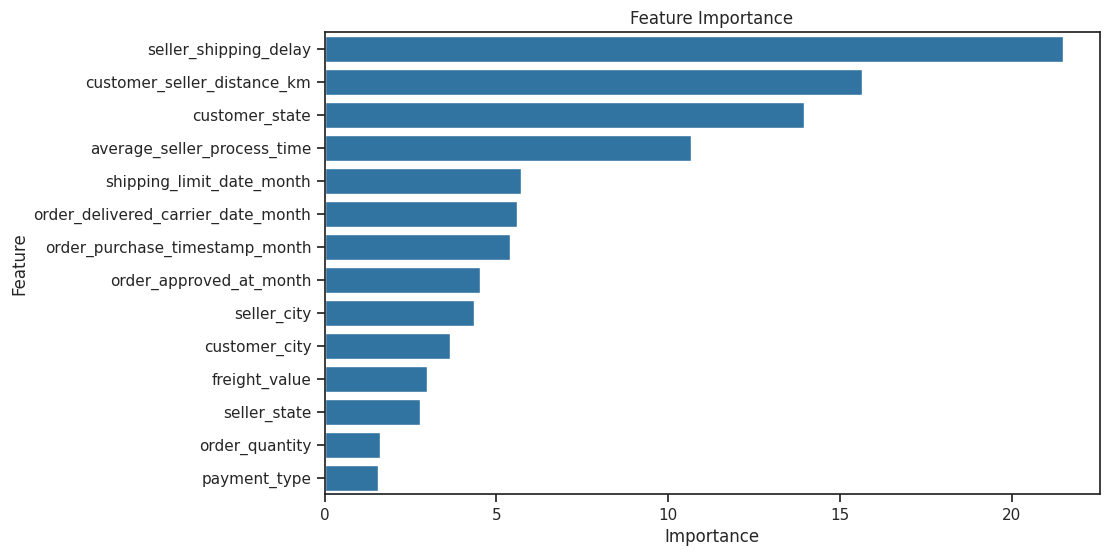

In [ ]:
# Visualise feature importance of cb_model
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### **10.4.3. LightGBM**

📊 **Version 1: LightGBM**

* Using default settings
* Included an additional two features: `average_delivery_time_by_seller` and `average_delivery_time_by_product`
* No scaling of numerical features is needed.
* Native categorical support but only works for categorical variables with an integer type. So we must convert the non-integer categorical variables into integers using `LabelEncoder`.
* Encode months as cyclical categorical features

In [ ]:
train_lightgbm = train.copy()
valid_lightgbm = valid.copy()

target_lightgbm = ['number_of_delivery_days']

predictors_lightgbm = ['freight_value',
                       'customer_seller_distance_km',
                       'average_seller_process_time',
                       'seller_shipping_delay',
                       'customer_city',
                       'customer_state',
                       'seller_city',
                       'seller_state',
                       'payment_type',
                       'order_quantity',
                       'order_purchase_timestamp_month',
                       'order_approved_at_month',
                       'order_delivered_carrier_date_month',
                       'shipping_limit_date_month']

X_train = train_lightgbm.loc[:, predictors_lightgbm].copy()
Y_train = train_lightgbm[target_lightgbm].copy()

X_valid = valid_lightgbm.loc[:, predictors_lightgbm].copy()
Y_valid = valid_lightgbm[target_lightgbm].copy()

In [ ]:
# Label Encoding of non-integer categorical features
from sklearn.preprocessing import OrdinalEncoder

categorical_lightgbm = ['customer_city',
                        'customer_state',
                        'seller_city',
                        'seller_state',
                        'payment_type']

# Use OrdinalEncoder to handle unknown values
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Apply Ordinal Encoding to each categorical column
for col in categorical_lightgbm:
    # Fit on the training data and transform both training and validation data
    X_train[col] = oe.fit_transform(X_train[[col]])
    X_valid[col] = oe.transform(X_valid[[col]])

# Convert encoded columns to integer type as OrdinalEncoder can return floats
for col in categorical_lightgbm:
    X_train[col] = X_train[col].astype(int)
    X_valid[col] = X_valid[col].astype(int)

In [ ]:
# Encoding of months columns
months_lightgbm = ['order_purchase_timestamp_month',
                   'shipping_limit_date_month']

# Apply sine and cosine transformations to the training data
for col in months_lightgbm:
    X_train[f'{col}_sin'] = np.sin(2 * np.pi * X_train[col] / 12)
    X_train[f'{col}_cos'] = np.cos(2 * np.pi * X_train[col] / 12)

# Apply sine and cosine transformations to the validation data
for col in months_lightgbm:
    X_valid[f'{col}_sin'] = np.sin(2 * np.pi * X_valid[col] / 12)
    X_valid[f'{col}_cos'] = np.cos(2 * np.pi * X_valid[col] / 12)

# Drop the original integer month columns
X_train = X_train.drop(columns=months_lightgbm)
X_valid = X_valid.drop(columns=months_lightgbm)

In [ ]:
# Update predictors list
predictors_lightgbm = ['freight_value',
                       'payment_type'
                       'customer_seller_distance_km',
                       'customer_city',
                       'customer_state',
                       'seller_city',
                       'seller_state',
                       'payment_type',
                       'order_quantity',
                       'product_size',
                       'order_purchase_timestamp_month',
                       'shipping_limit_date_month',
                       'average_seller_process_time',
                       'order_purchase_timestamp_month_sin',
                       'order_purchase_timestamp_month_cos',
                       'order_approved_at_month_sin',
                       'order_approved_at_month_cos',
                       'order_delivered_carrier_date_month_sin',
                       'order_delivered_carrier_date_month_cos',
                       'shipping_limit_date_month_sin',
                       'shipping_limit_date_month_cos',
                       'average_delivery_time_by_product']

In [ ]:
# LightGBM with default settings
import lightgbm as lgb

# Ensure categorical columns are category dtype
categorical_cols = ['customer_city', 'customer_state', 'seller_city', 'seller_state', 'payment_type']
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

# Initialize a simple LightGBM model with default parameters
default_lgbm = lgb.LGBMRegressor()

# Train the model
default_lgbm.fit(X_train, Y_train)

# Make predictions
y_pred_default = default_lgbm.predict(X_valid)

# Evaluate performance
rmse_default_lgbm = np.sqrt(mean_squared_error(Y_valid, y_pred_default))
mae_default_lgbm = mean_absolute_error(Y_valid, y_pred_default)
r2_default_lgbm = r2_score(Y_valid, y_pred_default)

print(f"LightGBM Performance:")
print(f"RMSE: {rmse_default_lgbm:.3f}")
print(f"MAE: {mae_default_lgbm:.3f}")
print(f"R²: {r2_default_lgbm:.3f}")

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3329
[LightGBM] [Info] Number of data points in the train set: 79233, number of used features: 16
[LightGBM] [Info] Start training from score 11.988363
LightGBM Performance:
RMSE: 7.030
MAE: 4.087
R²: 0.438


📊 **Version 2: LightGBM**

* Hyperparameter tuning through cross validation - optimising using Optuna.

In [ ]:
!pip install optuna
import optuna
from optuna.samplers import TPESampler

# Reconstruct the dataset to tune min_data_in_leaf
train_data = lgb.Dataset(X_train, Y_train)
valid_data = lgb.Dataset(X_valid, Y_train, reference = train_data)

def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,  # Fixed for stability
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'feature_pre_filter': False,
        'verbose': -1
    }

    # Perform cross-validation to ensure robust optimization
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=5000,
        nfold=5,
        stratified=False,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

    # Extract the best score and number of iterations
    best_score = min(cv_results['valid l2-mean'])
    trial.set_user_attr('num_trees', len(cv_results['valid l2-mean']))

    return best_score

# Create and run the study
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50, timeout = 120)

[I 2025-05-30 04:31:44,745] A new study created in memory with name: no-name-d5382303-6514-4ccd-afbb-82d13e254bb7


Training until validation scores don't improve for 50 rounds


[I 2025-05-30 04:40:22,298] Trial 0 finished with value: 42.75657712485112 and parameters: {'num_leaves': 97, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.5779972601681014, 'min_data_in_leaf': 6}. Best is trial 0 with value: 42.75657712485112.


Did not meet early stopping. Best iteration is:
[5000]	cv_agg's valid l2: 42.7566 + 2.55481


In [ ]:
# Display best parameters

params = study.best_params
num_trees = study.best_trial.user_attrs['num_trees']

print('Best parameters:')
print(params)

print(f'\nOptimal number of trees: {num_trees}')

Best parameters:
{'num_leaves': 97, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.5779972601681014, 'min_data_in_leaf': 6}

Optimal number of trees: 5000


In [ ]:
# Training the final LightGBM model with Optimized Hyparameters
import lightgbm as lgb

# Reconstruct the dataset to tune min_data_in_leaf
train_data = lgb.Dataset(X_train, Y_train)
valid_data = lgb.Dataset(X_valid, Y_train, reference = train_data)

params = {
 'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 97,
 'lambda_l1': 3.6010467344475403,
 'lambda_l2': 0.038720902953704193,
 'bagging_fraction': 0.7993292420985183,
 'bagging_freq': 2,
 'feature_fraction': 0.5779972601681014,
 'min_data_in_leaf': 6}

best_lightgbm_model = lgb.train(params, train_data, num_boost_round = 5000)

# Make predictions
y_pred_final = best_lightgbm_model.predict(X_valid)

# Evaluate the best model on the validation set
rmse_final_lgbm = np.sqrt(mean_squared_error(Y_valid, y_pred_final))
mae_final_lgbm = mean_absolute_error(Y_valid, y_pred_final)
r2_final_lgbm = r2_score(Y_valid, y_pred_final)

print(f"Final LightGBM Performance:")
print(f"RMSE: {rmse_final_lgbm:.3f}")
print(f"MAE: {mae_final_lgbm:.3f}")
print(f"R²: {r2_final_lgbm:.3f}")

Final LightGBM Performance:
RMSE: 6.758
MAE: 3.814
R²: 0.480


**Error Analysis**

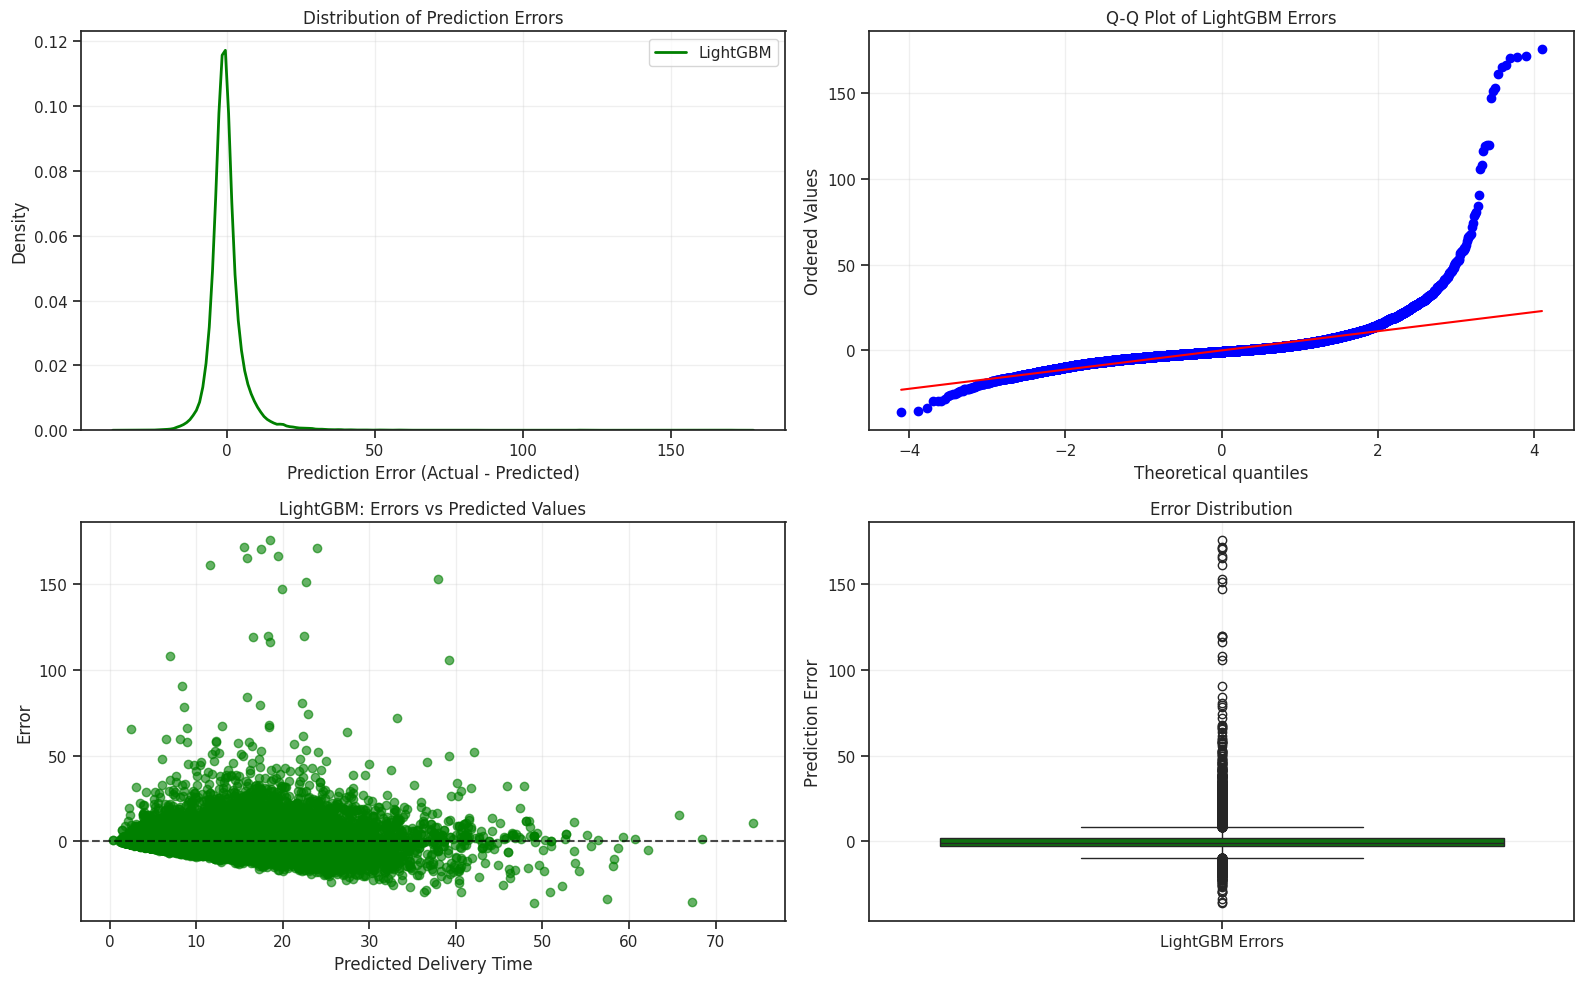

In [ ]:
colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

# Calculate prediction errors
y_pred_lightgbm = best_lightgbm_model.predict(X_valid)

lightgbm_errors = Y_valid.values.flatten() - y_pred_lightgbm # Flatten Y_valid if it's a DataFrame or Series

# Create a figure for prediction residual analysis
plt.figure(figsize=(16, 10))

# 1. Error distributions with KDE
plt.subplot(2, 2, 1)
sns.kdeplot(lightgbm_errors, color=colours[1], linewidth=2, label='LightGBM')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Q-Q plot
plt.subplot(2, 2, 2)
fig = stats.probplot(lightgbm_errors, plot=plt, fit=True)
plt.title('Q-Q Plot of LightGBM Errors')
plt.grid(True, alpha=0.3)

# 3. Errors vs Predicted Values (to check heteroscedasticity)
plt.subplot(2, 2, 3)
plt.scatter(y_pred_lightgbm, lightgbm_errors, alpha=0.6, color=colours[1])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('LightGBM: Errors vs Predicted Values')
plt.xlabel('Predicted Delivery Time')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)

# 4. Error boxplots for comparison
plt.subplot(2, 2, 4)
error_df = pd.DataFrame({
    'LightGBM Errors': lightgbm_errors})
sns.boxplot(data=error_df, palette=[colours[1]])
plt.title('Error Distribution')
plt.ylabel('Prediction Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10.5. Deep Learning

### 10.5.1 Simple Multilayer Perceptron (MLP)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
import tensorflow.keras.backend as K

In [ ]:
numerical_mlp = ['price',
              'freight_value',
              'payment_value',
              'product_weight_g',
              'product_size',
              'average_seller_process_time',
              'customer_seller_distance_km'
             ]

In [ ]:
categorical_features_mlp = ['customer_state',
                        'seller_state',
                        'product_category_name_english',
                        'payment_type']

In [ ]:
train_mlp = train.copy()
valid_mlp = valid.copy()

In [ ]:
# One Hot encoding payment_type
payment_type_encoded_train_mlp = pd.get_dummies(train_mlp['payment_type'], prefix='payment_type')
train_mlp = pd.concat([train_mlp.drop('payment_type', axis=1), payment_type_encoded_train_mlp], axis=1)

payment_type_encoded_valid_mlp = pd.get_dummies(valid_mlp['payment_type'], prefix='payment_type')
valid_mlp = pd.concat([valid_mlp.drop('payment_type', axis=1), payment_type_encoded_valid_mlp], axis=1)

In [ ]:
# One Hot encoding product_category_name_english
product_category_name_english_encoded_train_mlp = pd.get_dummies(train_mlp['product_category_name_english'], prefix='product_category_name_english')
train_mlp = pd.concat([train_mlp.drop('product_category_name_english', axis=1), product_category_name_english_encoded_train_mlp], axis=1)

product_category_name_english_encoded_valid_mlp = pd.get_dummies(valid_mlp['product_category_name_english'], prefix='product_category_name_english')
valid_mlp = pd.concat([valid_mlp.drop('product_category_name_english', axis=1), product_category_name_english_encoded_valid_mlp], axis=1)

In [ ]:
# One Hot encoding customer_state
customer_state_encoded_train_mlp = pd.get_dummies(train_mlp['customer_state'], prefix='customer_state')
train_mlp = pd.concat([train_mlp.drop('customer_state', axis=1), customer_state_encoded_train_mlp], axis=1)

customer_state_encoded_valid_mlp = pd.get_dummies(valid_mlp['customer_state'], prefix='customer_state')
valid_mlp = pd.concat([valid_mlp.drop('customer_state', axis=1), customer_state_encoded_valid_mlp], axis=1)

In [ ]:
# One Hot encoding seller_state
seller_state_encoded_train_mlp = pd.get_dummies(train_mlp['seller_state'], prefix='seller_state')
train_mlp = pd.concat([train_mlp.drop('seller_state', axis=1), seller_state_encoded_train_mlp], axis=1)

seller_state_encoded_valid_mlp = pd.get_dummies(valid_mlp['seller_state'], prefix='seller_state')
valid_mlp = pd.concat([valid_mlp.drop('seller_state', axis=1), seller_state_encoded_valid_mlp], axis=1)

In [ ]:
X_train_mlp = pd.concat([
    train_mlp[numerical_mlp],
    payment_type_encoded_train_mlp,
    product_category_name_english_encoded_train_mlp,
    customer_state_encoded_train_mlp,
    seller_state_encoded_train_mlp
], axis=1)

X_valid_mlp = pd.concat([
    valid_mlp[numerical_mlp],
    payment_type_encoded_valid_mlp,
    product_category_name_english_encoded_valid_mlp,
    customer_state_encoded_valid_mlp,
    seller_state_encoded_valid_mlp
], axis=1)

y_train = train_mlp[target]
y_valid = valid_mlp[target]

# Align columns
X_valid_mlp = valid_mlp.reindex(columns=X_train_mlp.columns, fill_value=0)
# Replace NaNs or Infs with 0 or mean (or drop them)
X_valid_mlp = X_valid_mlp.replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
input_dim = X_train_mlp.shape[1]

mlp_model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

mlp_model.fit(
    X_train_mlp, y_train,
    validation_data=(X_valid_mlp, y_valid),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 426846.0625 - mean_absolute_error: 237.5597 - root_mean_squared_error: 593.9694 - val_loss: 11712.2236 - val_mean_absolute_error: 64.5486 - val_root_mean_squared_error: 108.2230
Epoch 2/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 12884.6602 - mean_absolute_error: 49.6857 - root_mean_squared_error: 112.6767 - val_loss: 1878.2667 - val_mean_absolute_error: 27.1390 - val_root_mean_squared_error: 43.3390
Epoch 3/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3997.2227 - mean_absolute_error: 27.0154 - root_mean_squared_error: 62.7464 - val_loss: 1802.8341 - val_mean_absolute_error: 26.7742 - val_root_mean_squared_error: 42.4598
Epoch 4/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1356.7941 - mean_absolute_error: 17.9962 - root_mean_squared_error: 36.6582 - val_loss: 157.2853 - val_mean_absolute_error: 8.3433 - val_root_mean_squared_error: 12.5413
Epoch 5/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 672.11

**Standard scaling of features**

In [ ]:
# Standardise numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_mlp[numerical_mlp] = scaler.fit_transform(train_mlp[numerical_mlp])
valid_mlp[numerical_mlp] = scaler.fit_transform(valid_mlp[numerical_mlp])

In [ ]:
X_train_mlp = pd.concat([
    train_mlp[numerical_mlp],
    payment_type_encoded_train_mlp,
    product_category_name_english_encoded_train_mlp,
    customer_state_encoded_train_mlp,
    seller_state_encoded_train_mlp
], axis=1)

X_valid_mlp = pd.concat([
    valid_mlp[numerical_mlp],
    payment_type_encoded_valid_mlp,
    product_category_name_english_encoded_valid_mlp,
    customer_state_encoded_valid_mlp,
    seller_state_encoded_valid_mlp
], axis=1)

y_train = train_mlp[target]
y_valid = valid_mlp[target]

# Align columns
X_valid_mlp = valid_mlp.reindex(columns=X_train_mlp.columns, fill_value=0)
# Replace NaNs or Infs with 0 or mean (or drop them)
X_valid_mlp = X_valid_mlp.replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
input_dim = X_train_mlp.shape[1]

mlp_model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

mlp_model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

mlp_model.fit(
    X_train_mlp, y_train,
    validation_data=(X_valid_mlp, y_valid),
    epochs=15,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 92.6989 - mean_absolute_error: 6.2603 - root_mean_squared_error: 9.5287 - val_loss: 65.7497 - val_mean_absolute_error: 5.0244 - val_root_mean_squared_error: 8.1086
Epoch 2/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 67.6395 - mean_absolute_error: 5.2058 - root_mean_squared_error: 8.2227 - val_loss: 65.0747 - val_mean_absolute_error: 4.9555 - val_root_mean_squared_error: 8.0669
Epoch 3/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 65.5351 - mean_absolute_error: 4.9986 - root_mean_squared_error: 8.0933 - val_loss: 64.8122 - val_mean_absolute_error: 5.0844 - val_root_mean_squared_error: 8.0506
Epoch 4/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 62.7912 - mean_absolute_error: 4.9730 - root_mean_squared_error: 7.9230 - val_loss: 64.4535 - val_mean_absolute_error: 4.8463 - val_root_mean_squared_error: 8.0283
Epoch 5/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 61.7462 - mean_absolute_error: 4.9294 - root

## 10.6. Model Stacking

In [ ]:
y_valid_stack = valid[target].copy()
y_pred_mlr_3 = mlr_model_3.predict(valid_pred_3)
y_pred_final = best_lightgbm_model.predict(X_valid)

# Find minimum size across all prediction arrays
min_size = min(len(y_pred_mlr_3), len(y_pred_final), len(y_valid_stack))

# Truncate all to the same size
y_pred_mlr_3 = y_pred_mlr_3[:min_size]
y_pred_final = y_pred_final[:min_size]
y_valid_stack = y_valid_stack[:min_size]

# Stack
stack_X = np.vstack([y_pred_mlr_3, y_pred_final]).T

# Train meta-model (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stack_X, y_valid_stack)

# Predict
stack_preds = meta_model.predict(stack_X)

# Evaluation metrics
stack_rmse = np.sqrt(np.mean((y_valid_stack - stack_preds)**2))
stack_mae = mean_absolute_error(y_valid_stack, stack_preds)
stack_r2 = meta_model.score(stack_X, y_valid_stack)

print(f" Stacked Model RMSE : {stack_rmse:.4f}")
print(f" Stacked Model MAE  : {stack_mae:.4f}")
print(f" Stacked Model R2  : {stack_r2:.4f}")

 Stacked Model RMSE : 6.7612
 Stacked Model MAE  : 3.8047
 Stacked Model R2  : 0.4803


**Error Analysis**

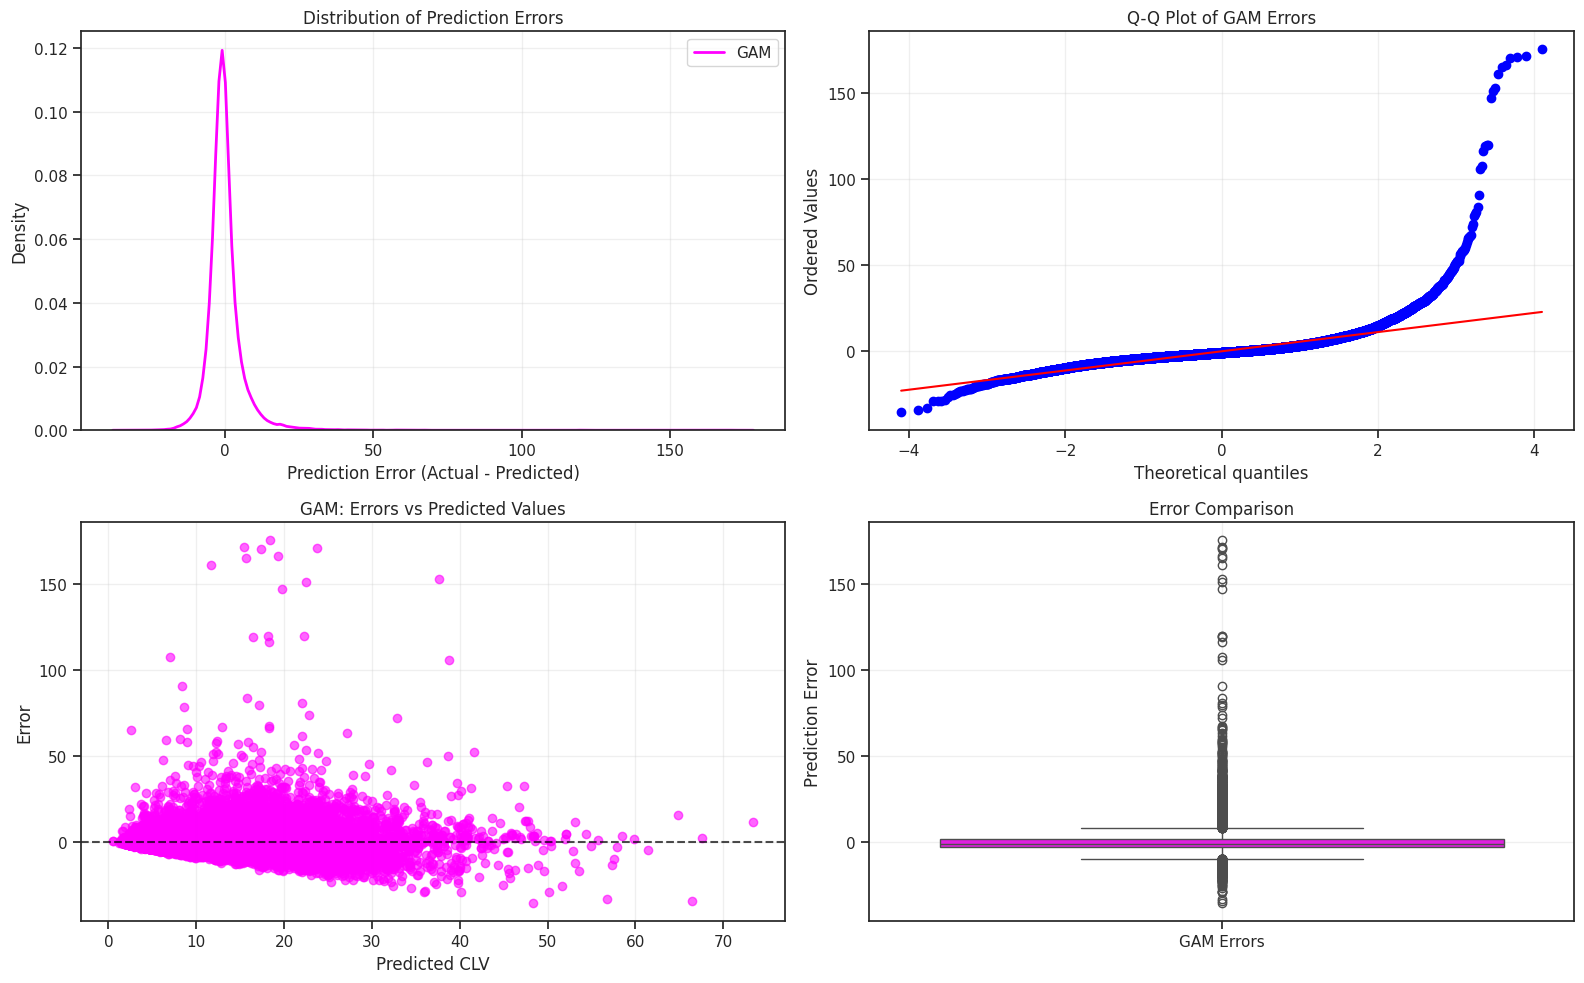

In [ ]:
# Error analysis of stacked model
colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

# Calculate prediction errors
stack_preds = meta_model.predict(stack_X)

gam_errors = y_valid_stack - stack_preds

# Create a figure for prediction residula analysis
plt.figure(figsize=(16, 10))

# 1. Error distributions with KDE
plt.subplot(2, 2, 1)
sns.kdeplot(gam_errors, color=colours[4], linewidth=2, label='GAM')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Q-Q plot
plt.subplot(2, 2, 2)
from scipy import stats
fig = stats.probplot(gam_errors, plot=plt, fit=True)
plt.title('Q-Q Plot of GAM Errors')
plt.grid(True, alpha=0.3)

# 3. Errors vs Predicted Values (to check heteroscedasticity)
plt.subplot(2, 2, 3)
plt.scatter(stack_preds, gam_errors, alpha=0.6, color=colours[4])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.title('GAM: Errors vs Predicted Values')
plt.xlabel('Predicted CLV')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)

# 4. Error boxplots for comparison
plt.subplot(2, 2, 4)
error_df = pd.DataFrame({
    'GAM Errors': gam_errors})
sns.boxplot(data=error_df, palette=[colours[4], colours[0]])
plt.title('Error Comparison')
plt.ylabel('Prediction Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 11. Forecasting Predictions on Test Data

## 11.1. MLR Performance on Test Data:

In [ ]:
# Encode categorical variables in test data
categorical_cols_to_encode = ['payment_type', 'product_category_name_english', 'customer_state', 'seller_state']

test_processed = test.drop(columns=categorical_cols_to_encode, errors='ignore').copy()
test_encoded = pd.get_dummies(test[categorical_cols_to_encode], prefix=categorical_cols_to_encode)
test_processed = pd.concat([test_processed, test_encoded], axis=1)

# Select only the predictor columns from the processed test data that were used for training
test_X = pd.DataFrame(columns=all_predictor_variables, index=test_processed.index)
for col in all_predictor_variables:
    if col in test_processed.columns:
        test_X[col] = test_processed[col]
    else:
        test_X[col] = 0

# Ensure columns are numeric
test_X = test_X.astype(float)
test_subset = test.copy()

# Add engineered features to the test_subset
test_subset['customer_seller_distance_km_capped_squared'] = test_subset['customer_seller_distance_km_capped'] ** 2
test_subset['order_purchase_timestamp_hour'] = test_subset['order_purchase_timestamp'].dt.hour
test_subset['order_purchase_timestamp_day'] = test_subset['order_purchase_timestamp'].dt.dayofweek
test_subset['order_purchase_timestamp_month'] = test_subset['order_purchase_timestamp'].dt.month

# Merge the encoded categorical features back into test_subset
test_subset = test_subset.drop(columns=categorical_cols_to_encode, errors='ignore')
test_subset = pd.concat([test_subset, test_encoded], axis=1)

# Ensure test_subset contains all columns in all_predictor_variables + the target
for col in all_predictor_variables:
    if col not in test_subset.columns:
        test_subset[col] = 0

# Ensure target variable is present
if 'number_of_delivery_days' not in test_subset.columns:
     print("Warning: 'number_of_delivery_days' not found in test_subset. Cannot evaluate.")
     # Handle this case, e.g., skip evaluation or raise an error

# Drop rows with NaN values in the relevant columns from the test subset
columns_for_evaluation = ['number_of_delivery_days'] + all_predictor_variables
test_evaluated_data = test_subset.dropna(subset=columns_for_evaluation).copy()

# Extract the predictor variables (X) and target variable (y) from the cleaned subset
test_X_eval = test_evaluated_data[all_predictor_variables]
y_true_test = test_evaluated_data['number_of_delivery_days']

# Make predictions using the cleaned test data
y_test_pred = mlr_model_3.predict(test_X_eval)

# Evaluate performance
mae_mlr_3_test = mean_absolute_error(y_true_test, y_test_pred)
r2_mlr_3_test = r2_score(y_true_test, y_test_pred)
rmse_mlr_3_test = np.sqrt(mean_squared_error(y_true_test, y_test_pred))

print(f"Multiple Linear Regression Performance on Test Set (Model 3):")
print(f"RMSE: {rmse_mlr_3_test:.3f}")
print(f"MAE: {mae_mlr_3_test:.3f}")
print(f"R²: {r2_mlr_3_test:.3f}")

Multiple Linear Regression Performance on Test Set (Model 3):
RMSE: 8.056
MAE: 4.978
R²: 0.260


## 11.2. LightGBM Performance on Test Data:

In [ ]:
train_lightgbm = train.copy()
valid_lightgbm = valid.copy()
test_lightgbm = test.copy()


target_lightgbm = ['number_of_delivery_days']

predictors_lightgbm = ['freight_value',
                       'customer_seller_distance_km',
                       'average_seller_process_time',
                       'seller_shipping_delay',
                       'customer_city',
                       'customer_state',
                       'seller_city',
                       'seller_state',
                       'payment_type',
                       'order_quantity',
                       'order_purchase_timestamp_month',
                       'order_approved_at_month',
                       'order_delivered_carrier_date_month',
                       'shipping_limit_date_month']


#Encoding in test set:
# Ensure datetime columns are in datetime format for the test set
test_lightgbm['order_purchase_timestamp'] = pd.to_datetime(test_lightgbm['order_purchase_timestamp'])
test_lightgbm['order_approved_at'] = pd.to_datetime(test_lightgbm['order_approved_at'])
test_lightgbm['order_delivered_carrier_date'] = pd.to_datetime(test_lightgbm['order_delivered_carrier_date'])
test_lightgbm['shipping_limit_date'] = pd.to_datetime(test_lightgbm['shipping_limit_date'])

# Extract month for the test set
test_lightgbm['order_purchase_timestamp_month'] = test_lightgbm['order_purchase_timestamp'].dt.month
test_lightgbm['order_approved_at_month'] = test_lightgbm['order_approved_at'].dt.month
test_lightgbm['order_delivered_carrier_date_month'] = test_lightgbm['order_delivered_carrier_date'].dt.month
test_lightgbm['shipping_limit_date_month'] = test_lightgbm['shipping_limit_date'].dt.month

# Create seller_shipping_delay for the test test_lightgbm
test_lightgbm['seller_shipping_delay'] = (test['order_delivered_carrier_date'] - test['shipping_limit_date']).dt.days

X_test = test_lightgbm.loc[:, predictors_lightgbm].copy()
Y_test = test_lightgbm[target_lightgbm].copy()

In [ ]:
# Label Encoding of non-integer categorical features
from sklearn.preprocessing import OrdinalEncoder

categorical_lightgbm = ['customer_city',
                        'customer_state',
                        'seller_city',
                        'seller_state',
                        'payment_type']

# Use OrdinalEncoder to handle unknown values
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Apply Ordinal Encoding to each categorical column
for col in categorical_lightgbm:
    # Fit on the training data and transform both training and validation data
    X_train[col] = oe.fit_transform(X_train[[col]])
    X_test[col] = oe.transform(X_test[[col]])

# Convert encoded columns to integer type as OrdinalEncoder can return floats
for col in categorical_lightgbm:
    X_train[col] = X_train[col].astype(int)
    X_valid[col] = X_valid[col].astype(int)
    X_test[col] = X_test[col].astype(int)

In [ ]:
# Encoding of months columns
months_lightgbm = ['order_purchase_timestamp_month',
                   'shipping_limit_date_month']

# Apply sine and cosine transformations to the test data
for col in months_lightgbm:
    X_test[f'{col}_sin'] = np.sin(2 * np.pi * X_test[col] / 12)
    X_test[f'{col}_cos'] = np.cos(2 * np.pi * X_test[col] / 12)

# Drop the original integer month columns
X_test = X_test.drop(columns=months_lightgbm)

In [ ]:
# Update predictors list
predictors_lightgbm = ['freight_value',
                       'payment_type'
                       'customer_seller_distance_km',
                       'customer_city',
                       'customer_state',
                       'seller_city',
                       'seller_state',
                       'payment_type',
                       'order_quantity',
                       'product_size',
                       'order_purchase_timestamp_month',
                       'shipping_limit_date_month',
                       'average_seller_process_time',
                       'order_purchase_timestamp_month_sin',
                       'order_purchase_timestamp_month_cos',
                       'order_approved_at_month_sin',
                       'order_approved_at_month_cos',
                       'order_delivered_carrier_date_month_sin',
                       'order_delivered_carrier_date_month_cos',
                       'shipping_limit_date_month_sin',
                       'shipping_limit_date_month_cos',
                       'average_delivery_time_by_product']

# LightGBM with default settings
import lightgbm as lgb

# Ensure categorical columns are category dtype
categorical_cols = ['customer_city', 'customer_state', 'seller_city', 'seller_state', 'payment_type']
for col in categorical_cols:
    X_test[col] = X_test[col].astype('category')
#X_test now has same number of columns with validation and train (16 columns)

In [ ]:
# Test LightGBM:
y_test_lightgbm = best_lightgbm_model.predict(X_test)

mae_best_lightgbm_test = mean_absolute_error(Y_test, y_test_lightgbm)
r2_best_lightgbm_test = r2_score(Y_test, y_test_lightgbm)
rmse_best_lightgbm_test = np.sqrt(mean_squared_error(Y_test, y_test_lightgbm))

print(f"Optimized LightGBM Performance on Test Set:")
print(f"RMSE: {rmse_best_lightgbm_test:.3f}") # RMSE: 7.886
print(f"MAE: {mae_best_lightgbm_test:.3f}") #MAE: 5.518
print(f"R²: {r2_best_lightgbm_test:.3f}") #R²: 0.292

Optimized LightGBM Performance on Test Set:
RMSE: 7.886
MAE: 5.518
R²: 0.292


## 11.3. Model Stacking Performance on Test Data:

In [ ]:
y_test_stack = test[target]
y_test_mlr = mlr_model_3.predict(test_X_eval) ###need test_X_val
y_test_lightgbm = best_lightgbm_model.predict(X_test)

# Find minimum size across all prediction arrays
min_size = min(len(y_test_mlr), len(y_test_lightgbm), len(y_test_stack))

# Truncate all to the same size
y_test_mlr = y_test_mlr[:min_size]
y_test_lightgbm = y_test_lightgbm[:min_size]
y_test_stack = y_test_stack[:min_size]

# Stack
stack_X = np.vstack([y_test_mlr, y_test_lightgbm]).T

# Predict
stack_preds_test = meta_model.predict(stack_X)

# Evaluation metrics
stack_rmse_test = np.sqrt(np.mean((y_test_stack - stack_preds_test)**2))
stack_mae_test = mean_absolute_error(y_test_stack, stack_preds_test)
stack_r2_test = r2_score(y_test_stack, stack_preds_test)

print(f" Stacked Model RMSE : {stack_rmse_test:.4f}")
print(f" Stacked Model MAE  : {stack_mae_test:.4f}")
print(f" Stacked Model R2  : {stack_r2_test:.4f}")

 Stacked Model RMSE : 7.8731
 Stacked Model MAE  : 5.4809
 Stacked Model R2  : 0.2954
